In [2]:
import mqbench,torch,torchvision,numpy as np,matplotlib.pyplot as plt,torchvision,torchvision.models as models,timm,timm.models as models
%matplotlib inline
from torchmetrics import ConfusionMatrix
from mqbench.prepare_by_platform import prepare_by_platform
from mqbench.prepare_by_platform import BackendType
from mqbench.utils.state import enable_calibration
from mqbench.utils.state import enable_quantization
from mqbench.convert_deploy import convert_deploy
from tqdm import tqdm
from mqbench.fake_quantize.lsq import LearnableFakeQuantize
from dataset import get_dataloader
device = torch.device('cuda:3')
mean=np.array([123.675, 116.28, 103.53])/255
std=np.array([58.395, 57.12, 57.375])/255

dataloader = get_dataloader()

extra_qconfig_dict = {
    'w_observer': 'MinMaxObserver',
    'a_observer': 'EMAMinMaxObserver',
    'w_fakequantize': 'FixedFakeQuantize',
    'a_fakequantize': 'LearnableFakeQuantize',
    'w_qscheme': {
        'bit': 8,
        'symmetry': True,
        'per_channel': True,
        'pot_scale': False
    },
    'a_qscheme': {
        'bit': 8,
        'symmetry': True,
        'per_channel': False,
        'pot_scale': False
    }
}
model = timm.create_model('swin_base_patch4_window7_224',pretrained=True).to(device) #
prepare_custom_config_dict = {'extra_qconfig_dict': extra_qconfig_dict}
model = prepare_by_platform(model, BackendType.Vitis, prepare_custom_config_dict).to(device)
ori= timm.create_model('swin_base_patch4_window7_224',pretrained=True).to(device) #
model

[MQBENCH] INFO: Quantize model Scheme: BackendType.Vitis Mode: Training
[MQBENCH] INFO: Weight Quant Scheme is overrided!
[MQBENCH] INFO: Activation Quant Scheme is overrided!
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MinMaxObserver Params: Symmetric: True / Bitwidth: 8 / Per channel: True / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: LearnableFakeQuantize Params: {}
    Oberver:      EMAMinMaxObserver Params: Symmetric: True / Bitwidth: 8 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Bias Qconfig:
    TqtFakeQuantize with MinMaxObserver
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Add matmul_1 to output quantize
[MQBENCH] INFO: Add matmul_2 to output quantize
[MQBENCH] INFO: Add matmul_3 to output quantize
[MQBENCH] INFO: Add matmul_4 to output quantize
[MQBENCH] INFO: Add matmul_5 to output quantize
[MQBENCH] INFO: Add matmul_6 to output q

GraphModule(
  (patch_embed): Module(
    (proj): Conv2d(
      3, 128, kernel_size=(4, 4), stride=(4, 4)
      (weight_fake_quant): FixedFakeQuantize(
        fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric, ch_axis=0, scale=List, zero_point=List
        (activation_post_process): MinMaxObserver(min_val=List, max_val=List ch_axis=0 pot=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Module(
    (0): Module(
      (blocks): Module(
        (0): Module(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): Module(
            (qkv): Linear(
              in_features=128, out_features=384, bias=True
              (weight_fake_quant): FixedFakeQuantize(
                fake_quant_enable

In [6]:
model.eval() # 进行PTQ
enable_calibration(model)
with torch.no_grad():
    for i,(img,label) in enumerate(tqdm(dataloader)):
        if i>100 :
            break
        img = img.to(device)
        model(img)

[MQBENCH] INFO: Enable observer and Disable quantize.


  6%|▋         | 101/1563 [00:26<06:30,  3.75it/s]


In [1]:
enable_quantization(model) # 打开量化，准备好模拟后台推断的量化
ori.to(device)
ori.eval()
from torchmetrics import Accuracy
acc = Accuracy().to(device)
with torch.no_grad():
    for i,(img,label) in enumerate(tqdm(dataloader)):
        img = img.to(device)
        acc.update(torch.argmax(model(img),dim=-1),torch.argmax(ori(img),dim=-1))
        acc.update(model(img).detach().cpu(),label.cpu())
acc.compute()



NameError: name 'enable_quantization' is not defined

### 测试hooks能不能再GraphModel中使用

In [16]:
%matplotlib inline
import mqbench,torch,torchvision,numpy as np,matplotlib.pyplot as plt,torchvision,torchvision.models as models,timm,timm.models as models
from torchmetrics import ConfusionMatrix #  
from mqbench.prepare_by_platform import prepare_by_platform
from mqbench.prepare_by_platform import BackendType
from mqbench.utils.state import enable_calibration
from mqbench.utils.state import enable_quantization
from mqbench.convert_deploy import convert_deploy
from tqdm import tqdm
from mqbench.utils.logger import logger as log
from mqbench.fake_quantize.lsq import LearnableFakeQuantize
from dataset import get_dataloader
import torch.fx as fx
from torch.fx import Interpreter
from logger import get_logger
from mqbench.utils.registry import DEFAULT_MODEL_QUANTIZER
from torch.fx.graph_module import GraphModule
print(DEFAULT_MODEL_QUANTIZER)
logger,workdir = get_logger("SwinQuant-qkv+Conv+Linear(tensorrt-default)")
device = torch.device('cuda:1')
# device = torch.device('cpu')
mean=np.array([123.675, 116.28, 103.53])/255
std=np.array([58.395, 57.12, 57.375])/255


dataloader = get_dataloader()
extra_qconfig_dict = {
    'w_observer': 'MinMaxObserver',
    # 'a_observer': 'EMAMinMaxObserver',
    'a_observer': 'MinMaxObserver',
    'w_fakequantize': 'FixedFakeQuantize',
    'a_fakequantize': 'LearnableFakeQuantize',
    # 'a_fakequantize': 'FixedFakeQuantize',
    'w_qscheme': {
        'bit': 8,
        'symmetry': True,
        'per_channel': True,
        'pot_scale': False
    },
    'a_qscheme': {
        'bit': 16,
        'symmetry': True,
        'per_channel': False,
        'pot_scale': False
    }
}
logger.info(extra_qconfig_dict) #  

model = timm.create_model('swin_base_patch4_window7_224',pretrained=True).to(device) #
prepare_custom_config_dict = {'extra_qconfig_dict': extra_qconfig_dict}
# model = prepare_by_platform(model, BackendType.Tensorrt, prepare_custom_config_dict).to(device)
model = prepare_by_platform(model, BackendType.Tensorrt,prepare_custom_config_dict).to(device)
ori= timm.create_model('swin_base_patch4_window7_224',pretrained=True).to(device) #
ori = fx.symbolic_trace(ori)
model.eval() # 进行PTQ
enable_calibration(model) # 打开校准

# 校准
with torch.no_grad():
    for i,(img,label) in enumerate(tqdm(dataloader)):
        if i>=256:
            break
        img = img.to(device)
        model(img)

# 分别为model和ori 都注册hooks
from collections import defaultdict
quant_dict = defaultdict(list)
ori_dict = defaultdict(list)
def hook_generator(d,name):
    def hook(module,input,output):
        d[name].append(input[0].detach().cpu().numpy())
        return output
    return hook
# for name,m in model.named_modules():
#     if 'mid' in name:
#         m.register_forward_hook(hook_generator(quant_dict,name))
# for name,m in ori.named_modules(): 
#     if 'mi' in name:
#         m.register_forward_hook(hook_generator(ori_dict,name))
# 为tensor注册hook

# 量化计算
enable_quantization(model) # 打开量化，准备好模拟后台推断的量化
ori.to(device)
ori.eval()
from torchmetrics import Accuracy

# model = ori
acc = Accuracy()
ori_acc = Accuracy()

class FindInput(Interpreter):
    def __init__(self,d, *args):
        super().__init__(*args)
        self.d  = d

    @staticmethod
    def _tensor2numpy(args):
        return list(map(lambda x:x.detach().cpu().numpy(),args))
    def call_function(self, target , args , kwargs):
        ret = super().call_function(target,args,kwargs) # 首先得到最后的输出结果用来返回
        if target==torch.matmul:
            self.d[self.name].append(self._tensor2numpy(args)+[ret.detach().cpu().numpy()])
            # for a in args:
            #     print(a.shape)
            # print(kwargs)
            pass
        return ret

    pass

find = FindInput(quant_dict,model.eval())
find_ori = FindInput(ori_dict,ori.eval())
with torch.no_grad():
    for i,(img,label) in enumerate(tqdm(dataloader)):
        if i>4:
            break
        img = img.to(device)
        acc.update(find.run(img).detach().cpu(),label.cpu())
        ori_acc.update(find_ori.run(img).detach().cpu(),label.cpu())


## 原本的hook形式，后来发现行不通
# with torch.no_grad():
#     for i,(img,label) in enumerate(tqdm(dataloader)):
#         if i>32:
#             break
#         img = img.to(device)
#         # acc.update(torch.argmax(model(img),dim=-1),torch.argmax(ori(img),dim=-1))
#         acc.update(model(img).detach().cpu(),label.cpu())
#         ori_acc.update(ori(img).detach().cpu(),label.cpu())
print(f"最终的精度是：{acc.compute()}")
print(f"ori的精度:{ori_acc.compute()}")



SwinQuant-qkv+Conv+Linear(tensorrt-default)Log创建完成
SwinQuant-qkv+Conv+Linear(tensorrt-default)Log创建完成
SwinQuant-qkv+Conv+Linear(tensorrt-default)Log创建完成


OrderedDict([(<BackendType.NNIE: 'NNIE'>, <class 'mqbench.custom_quantizer.model_quantizer.ModelQuantizer'>), (<BackendType.Tensorrt: 'Tensorrt'>, <class 'mqbench.custom_quantizer.model_quantizer.ModelQuantizer'>), (<BackendType.Academic: 'Academic'>, <class 'mqbench.custom_quantizer.academic_quantizer.AcademicQuantizer'>), (<BackendType.OPENVINO: 'OPENVINO'>, <class 'mqbench.custom_quantizer.openvino_quantizer.OPENVINOQuantizer'>), (<BackendType.Vitis: 'Vitis'>, <class 'mqbench.custom_quantizer.vitis_quantizer.VitisQuantizer'>), (<BackendType.PPLW8A16: 'PPLW8A16'>, <class 'mqbench.custom_quantizer.total_int_quantizer.TotalINTQuantizer'>), (<BackendType.SNPE: 'SNPE'>, <class 'mqbench.custom_quantizer.total_int_quantizer.TotalINTQuantizer'>), (<BackendType.PPLCUDA: 'PPLCUDA'>, <class 'mqbench.custom_quantizer.total_int_quantizer.TotalINTQuantizer'>), (<BackendType.Tensorrt_NLP: 'Tensorrt_NLP'>, <class 'mqbench.custom_quantizer.tensorrt_quantizer.TensorrtNLPQuantizer'>), (<BackendType.Te

{'w_observer': 'MinMaxObserver', 'a_observer': 'MinMaxObserver', 'w_fakequantize': 'FixedFakeQuantize', 'a_fakequantize': 'LearnableFakeQuantize', 'w_qscheme': {'bit': 8, 'symmetry': True, 'per_channel': True, 'pot_scale': False}, 'a_qscheme': {'bit': 16, 'symmetry': True, 'per_channel': False, 'pot_scale': False}}
{'w_observer': 'MinMaxObserver', 'a_observer': 'MinMaxObserver', 'w_fakequantize': 'FixedFakeQuantize', 'a_fakequantize': 'LearnableFakeQuantize', 'w_qscheme': {'bit': 8, 'symmetry': True, 'per_channel': True, 'pot_scale': False}, 'a_qscheme': {'bit': 16, 'symmetry': True, 'per_channel': False, 'pot_scale': False}}
{'w_observer': 'MinMaxObserver', 'a_observer': 'MinMaxObserver', 'w_fakequantize': 'FixedFakeQuantize', 'a_fakequantize': 'LearnableFakeQuantize', 'w_qscheme': {'bit': 8, 'symmetry': True, 'per_channel': True, 'pot_scale': False}, 'a_qscheme': {'bit': 16, 'symmetry': True, 'per_channel': False, 'pot_scale': False}}


[MQBENCH] INFO: Quantize model Scheme: BackendType.Tensorrt Mode: Training
[MQBENCH] INFO: Weight Quant Scheme is overrided!
[MQBENCH] INFO: Activation Quant Scheme is overrided!
[MQBENCH] INFO: Weight Qconfig:
    FakeQuantize: FixedFakeQuantize Params: {}
    Oberver:      MinMaxObserver Params: Symmetric: True / Bitwidth: 8 / Per channel: True / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Activation Qconfig:
    FakeQuantize: LearnableFakeQuantize Params: {}
    Oberver:      MinMaxObserver Params: Symmetric: True / Bitwidth: 16 / Per channel: False / Pot scale: False / Extra kwargs: {}
[MQBENCH] INFO: Replace module to qat module.
[MQBENCH] INFO: Insert act quant mul_1_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant transpose_2_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant layers_0_blocks_0_attn_attn_drop_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant getitem_16_post_act_fake_quantizer
[MQBENCH] INFO: Insert act quant mul_2_post_act_fake_quanti

  2%|▏         | 256/12500 [00:41<33:06,  6.16it/s]

[MQBENCH] INFO: Disable observer and Enable quantize.



  0%|          | 5/12500 [00:08<5:35:56,  1.61s/it] 

最终的精度是：0.0
ori的精度:0.8500000238418579


(8028160,) (8028160,)
(8028160,) (8028160,)
(12293120,) (12293120,)


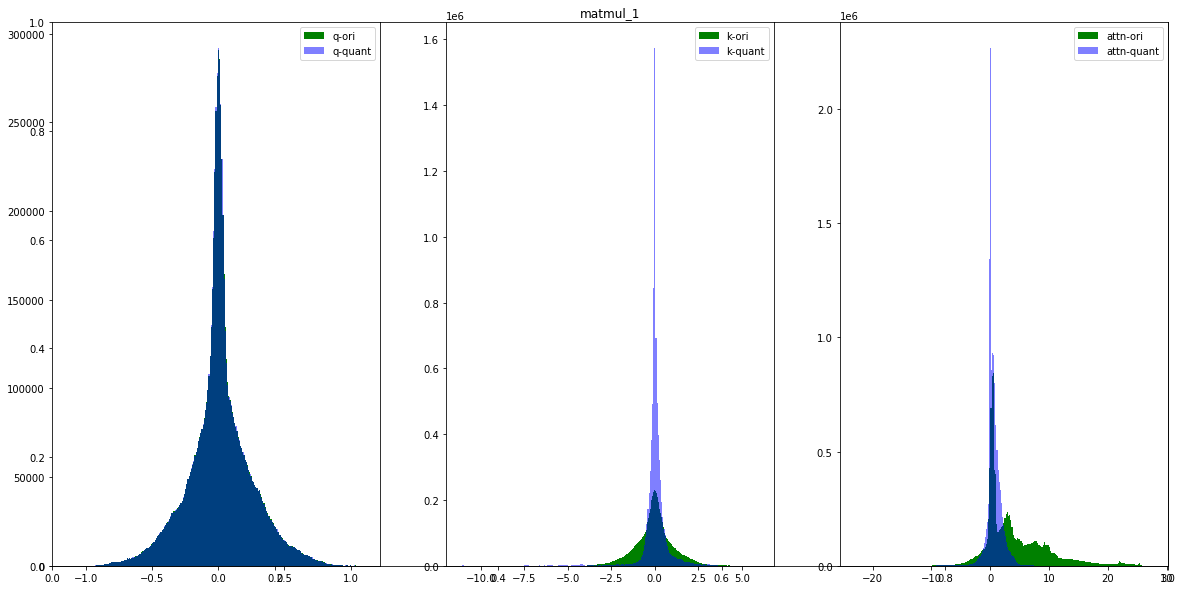

(12293120,) (12293120,)
(8028160,) (8028160,)
(8028160,) (8028160,)


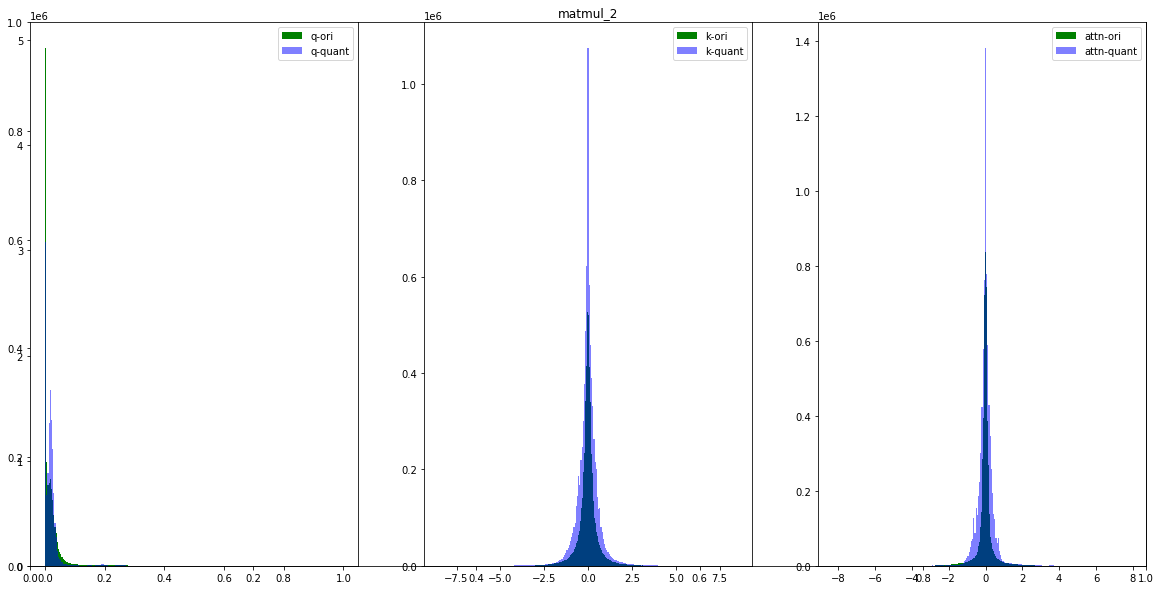

(8028160,) (8028160,)
(8028160,) (8028160,)
(12293120,) (12293120,)


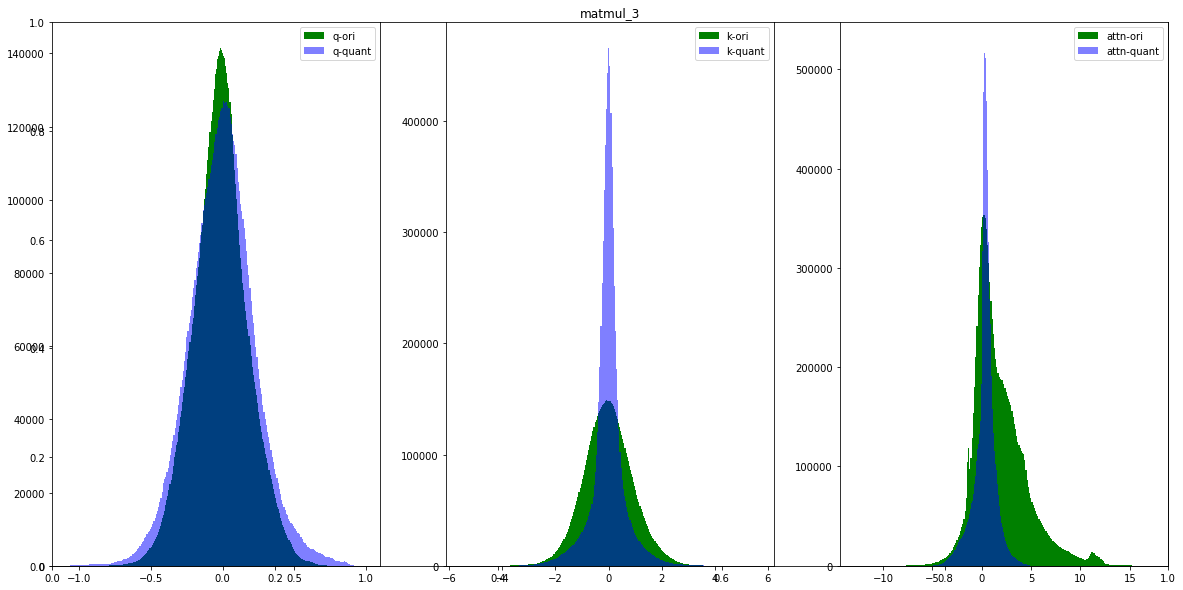

(12293120,) (12293120,)
(8028160,) (8028160,)
(8028160,) (8028160,)


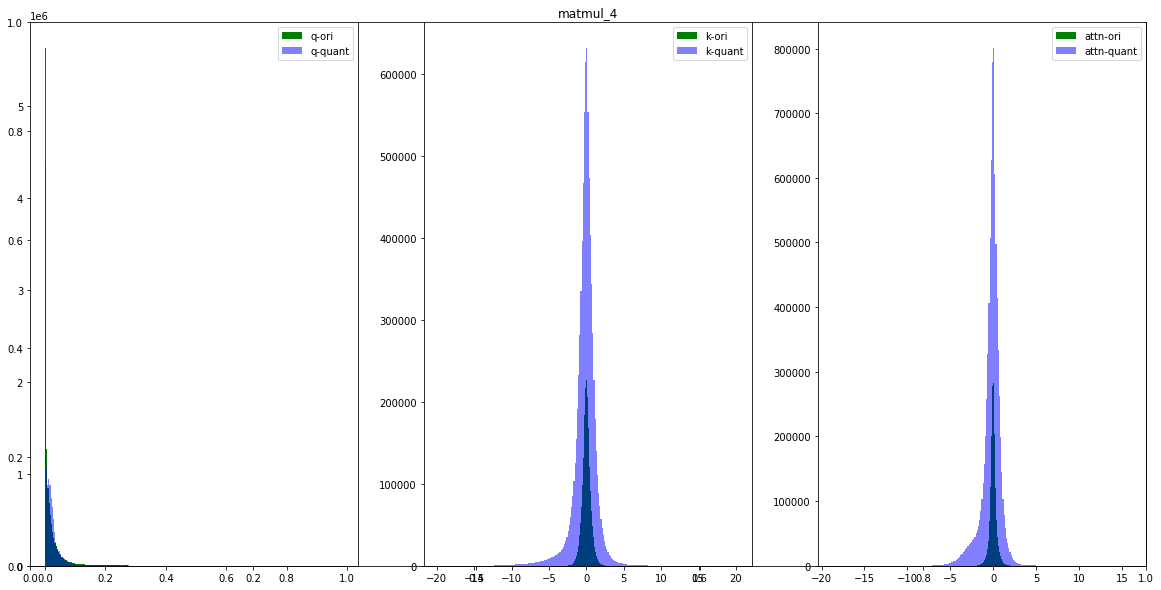

(4014080,) (4014080,)
(4014080,) (4014080,)
(6146560,) (6146560,)


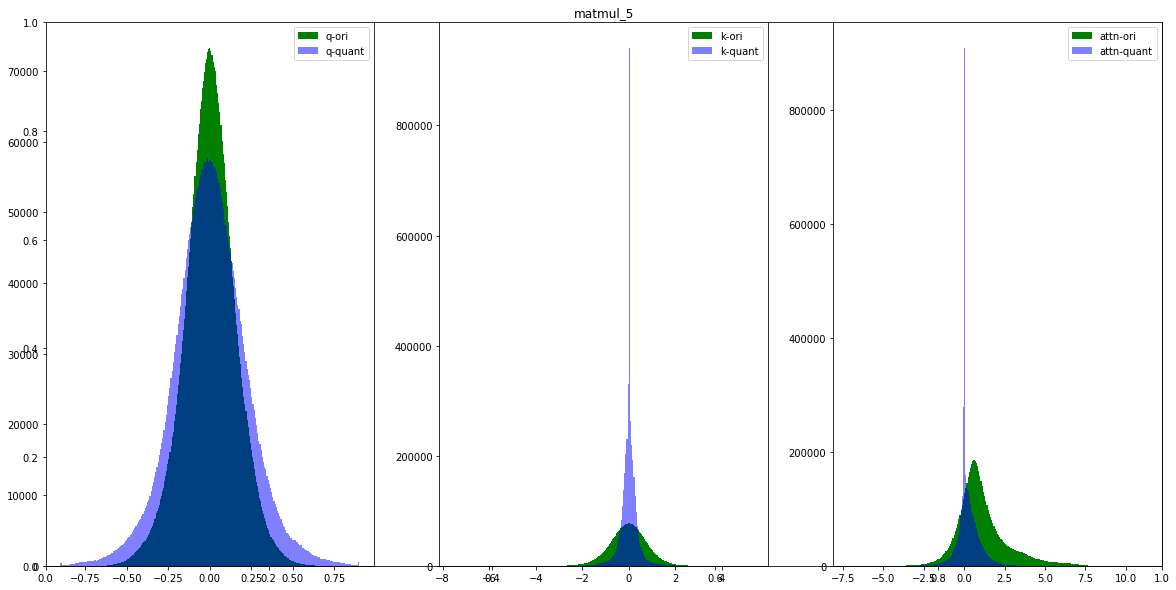

(6146560,) (6146560,)
(4014080,) (4014080,)
(4014080,) (4014080,)


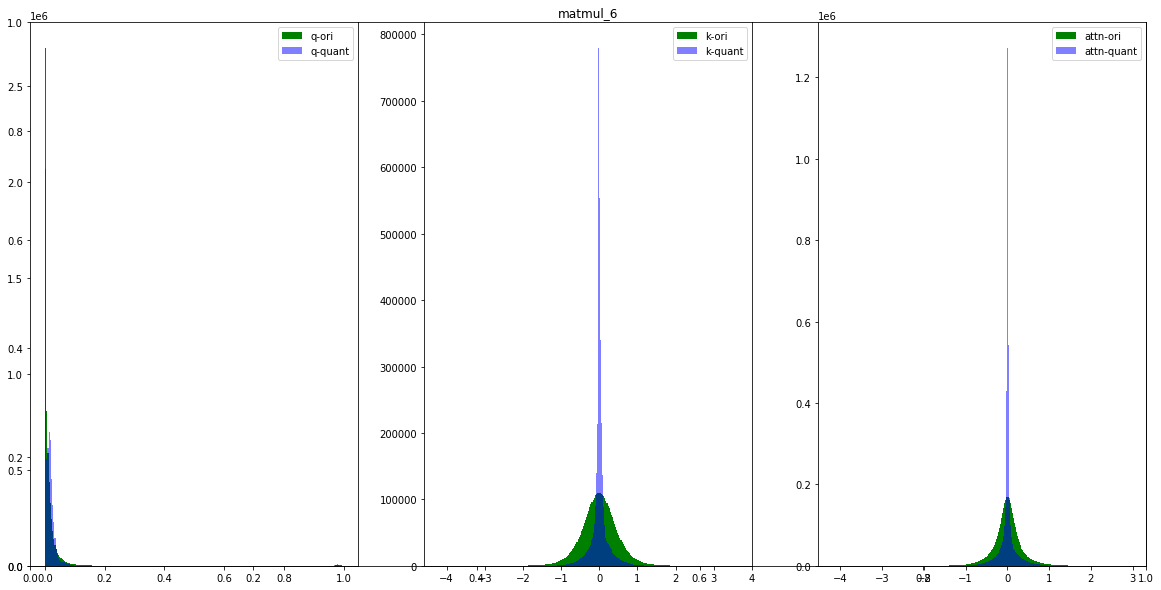

(4014080,) (4014080,)
(4014080,) (4014080,)
(6146560,) (6146560,)


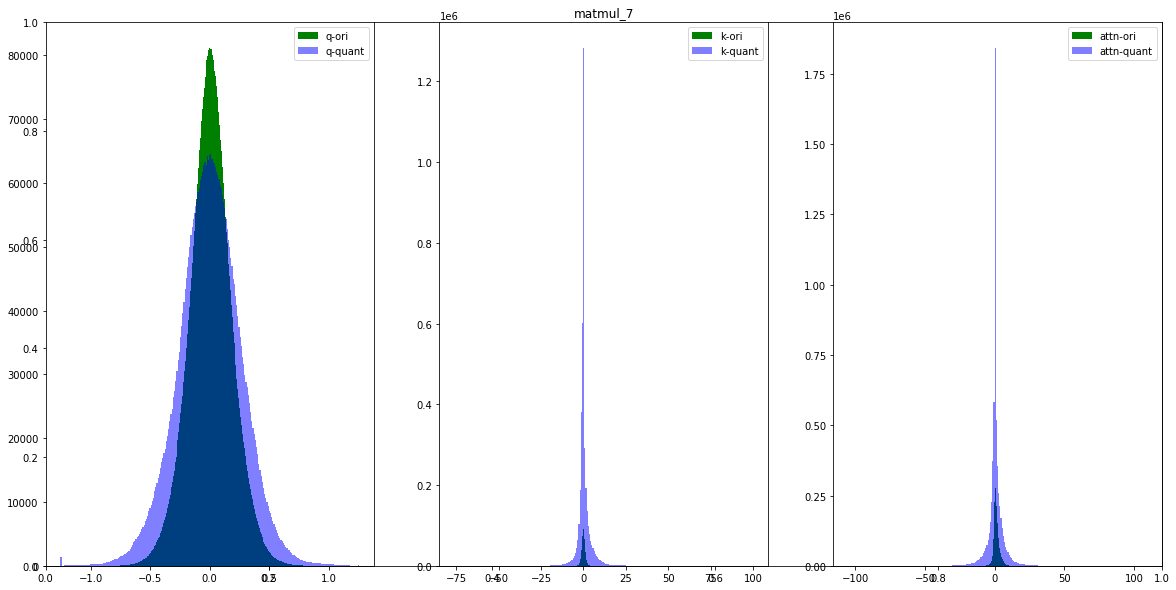

(6146560,) (6146560,)
(4014080,) (4014080,)
(4014080,) (4014080,)


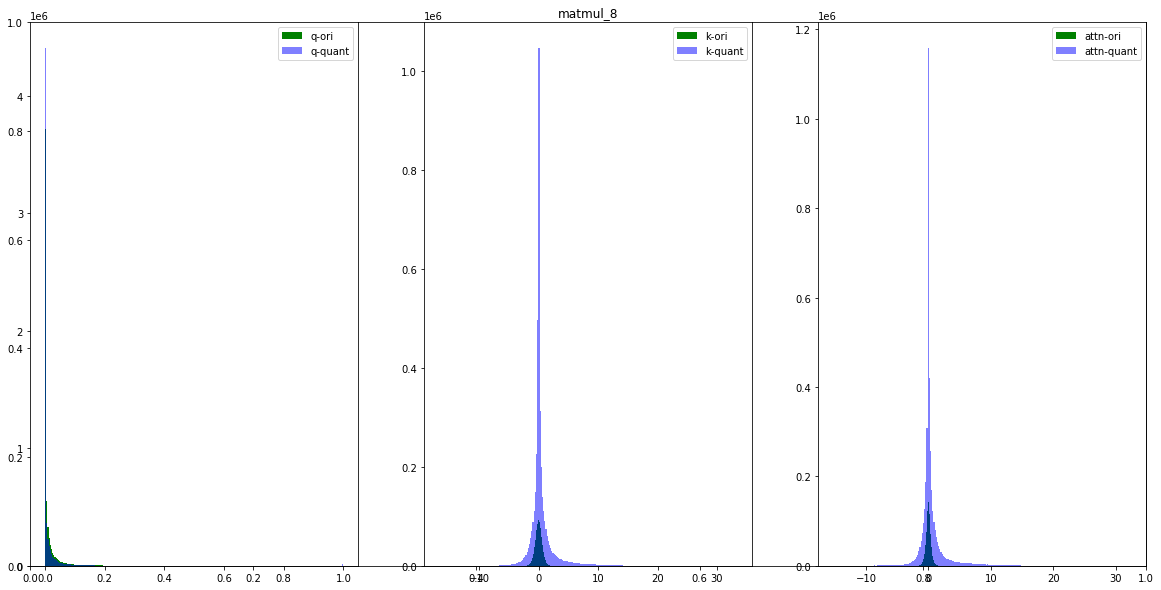

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


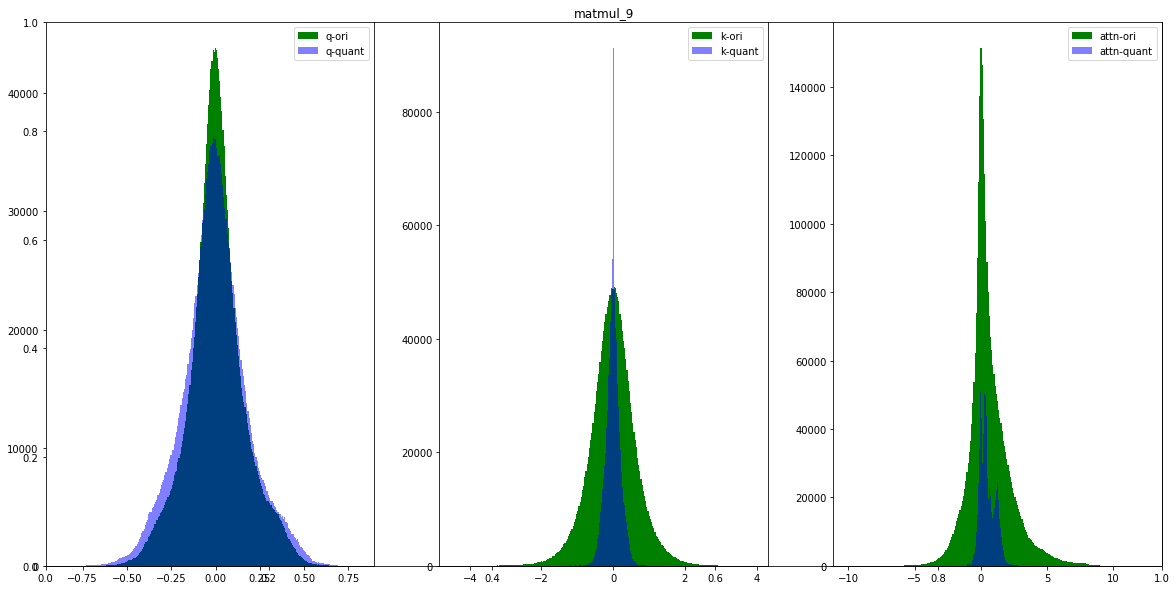

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


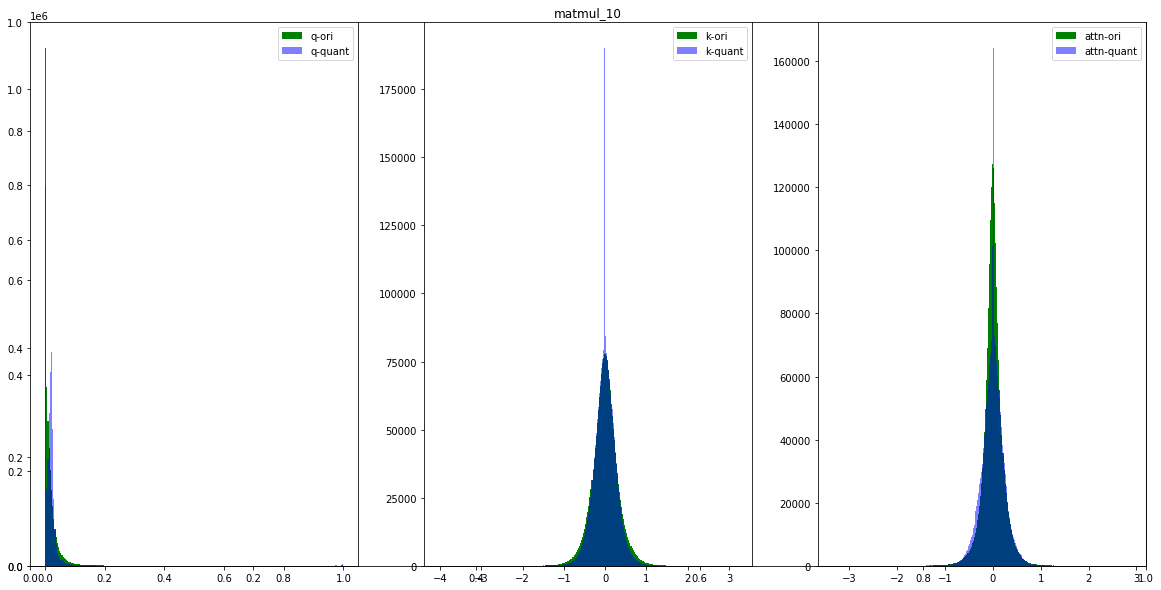

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


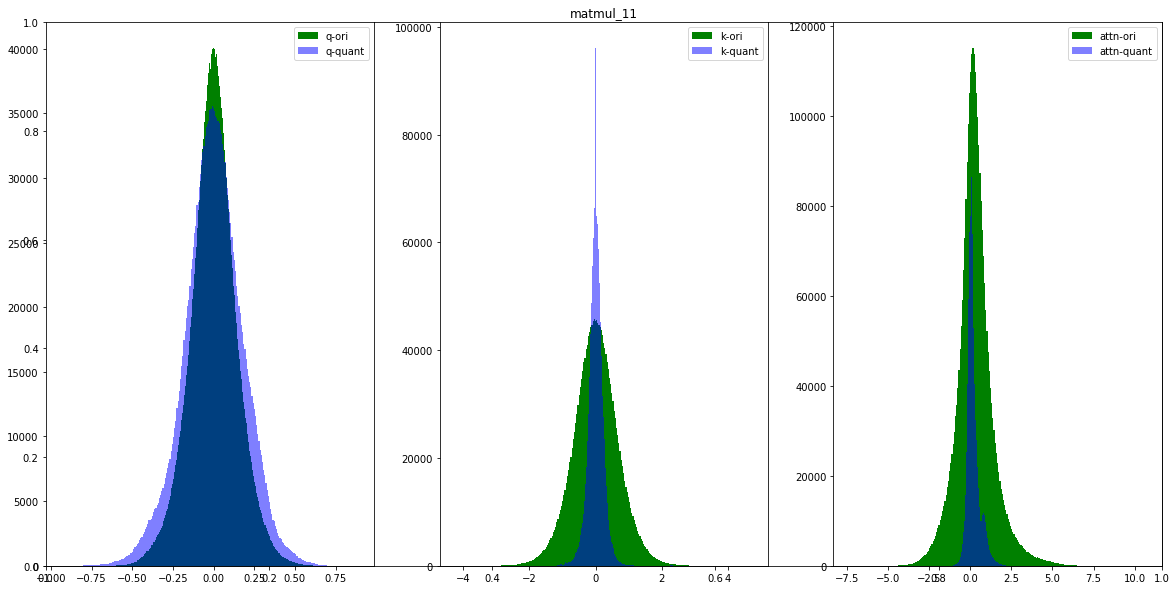

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


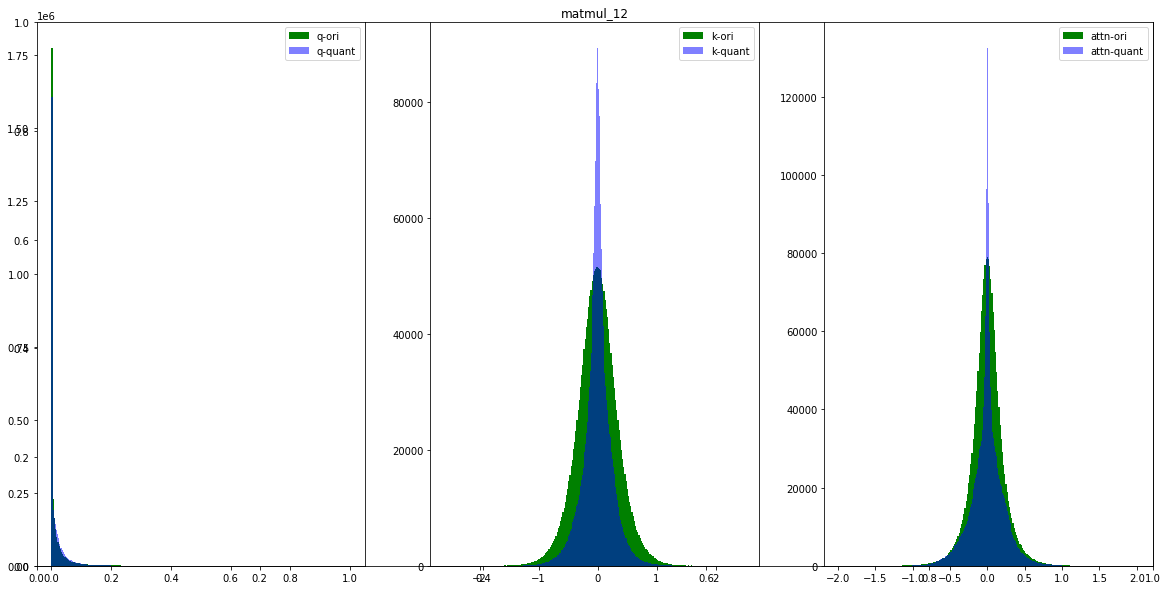

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


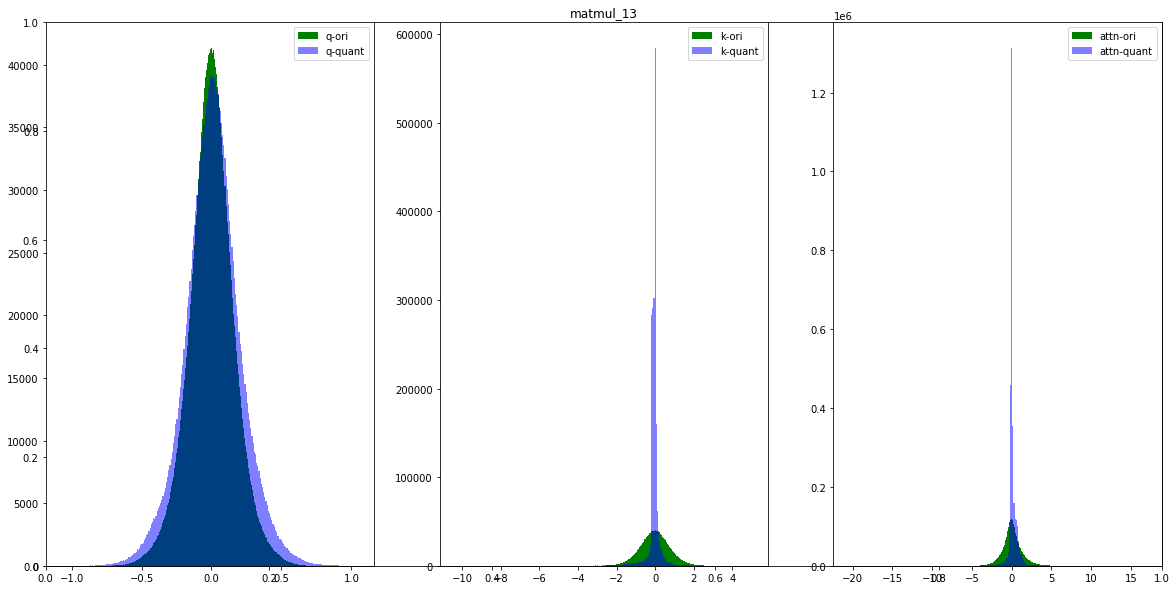

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


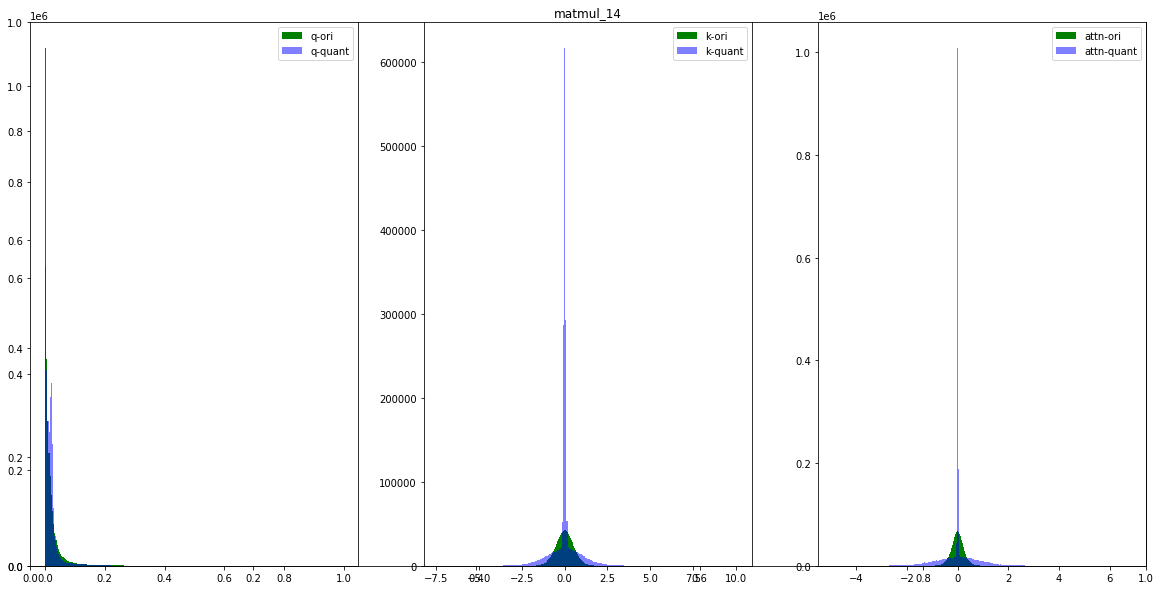

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


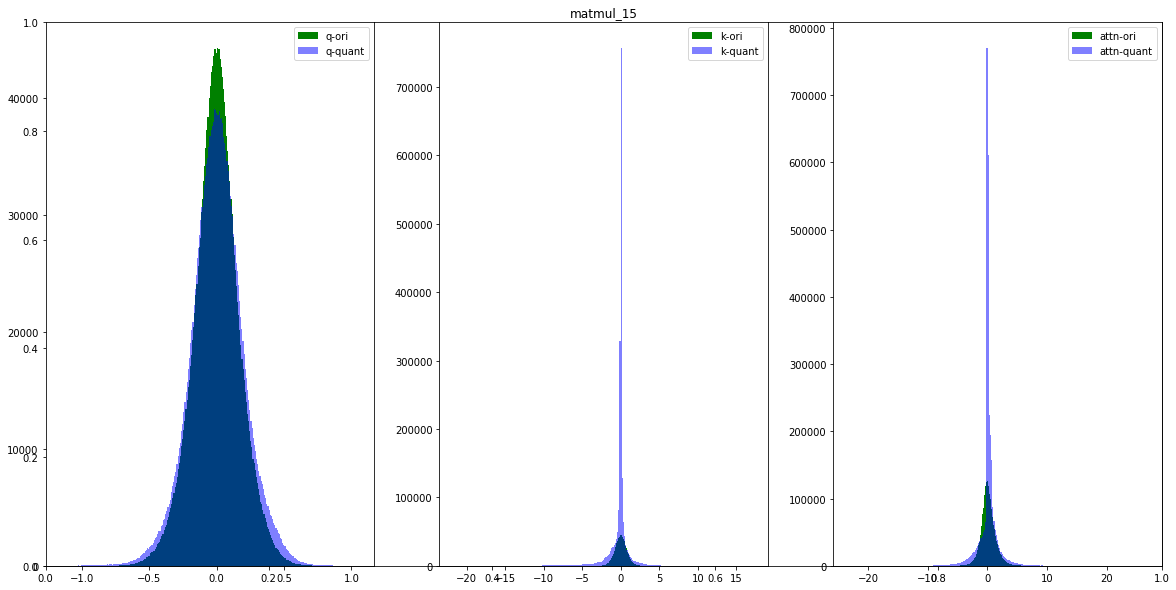

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


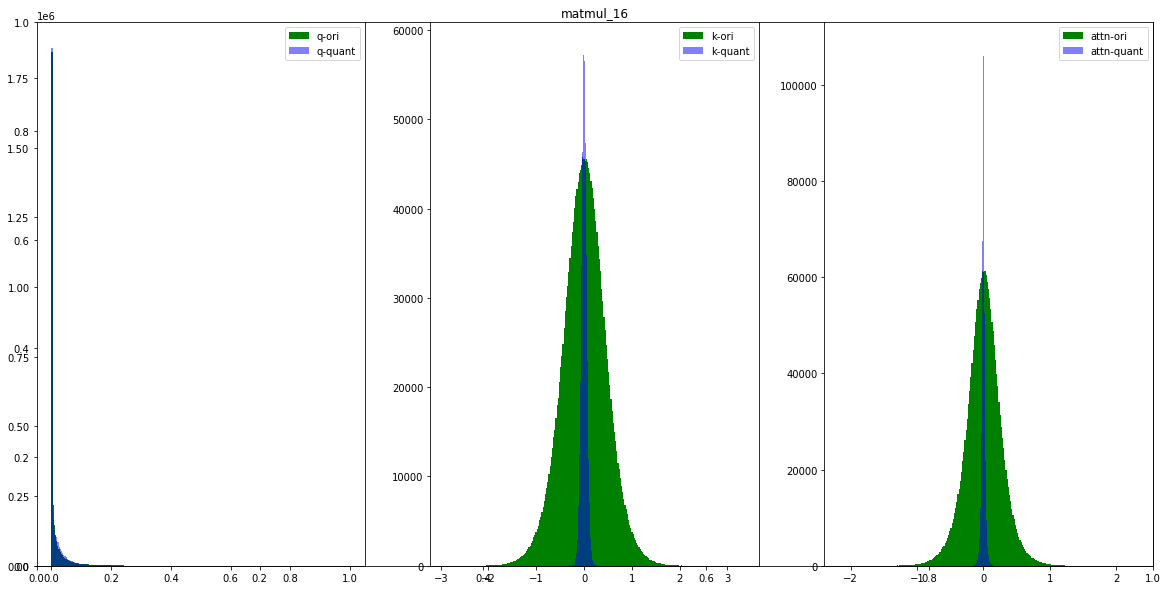

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


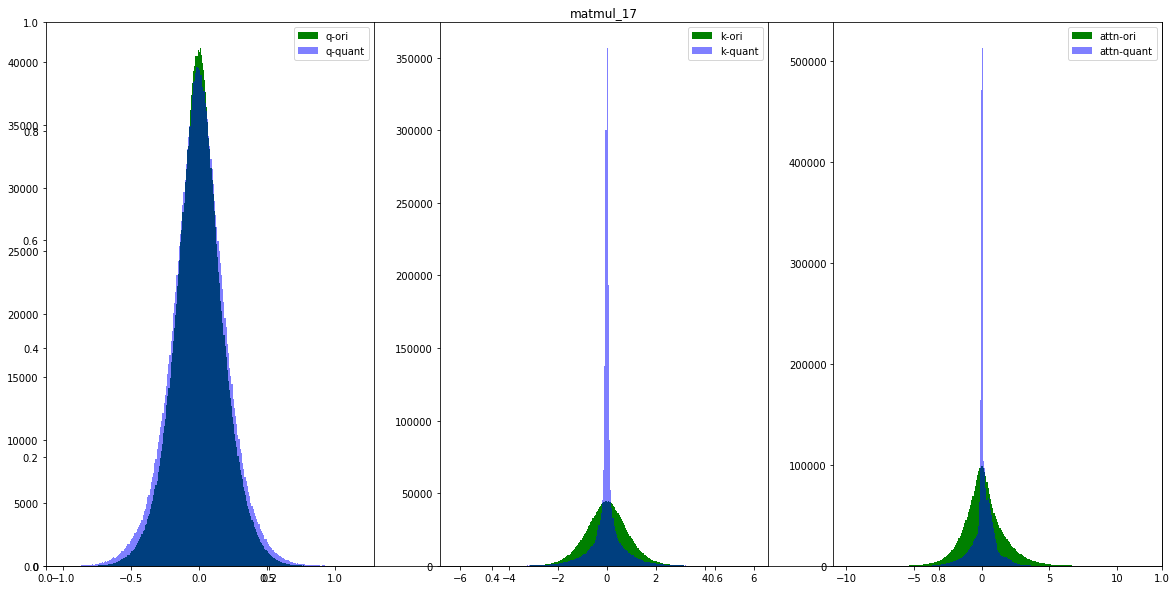

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


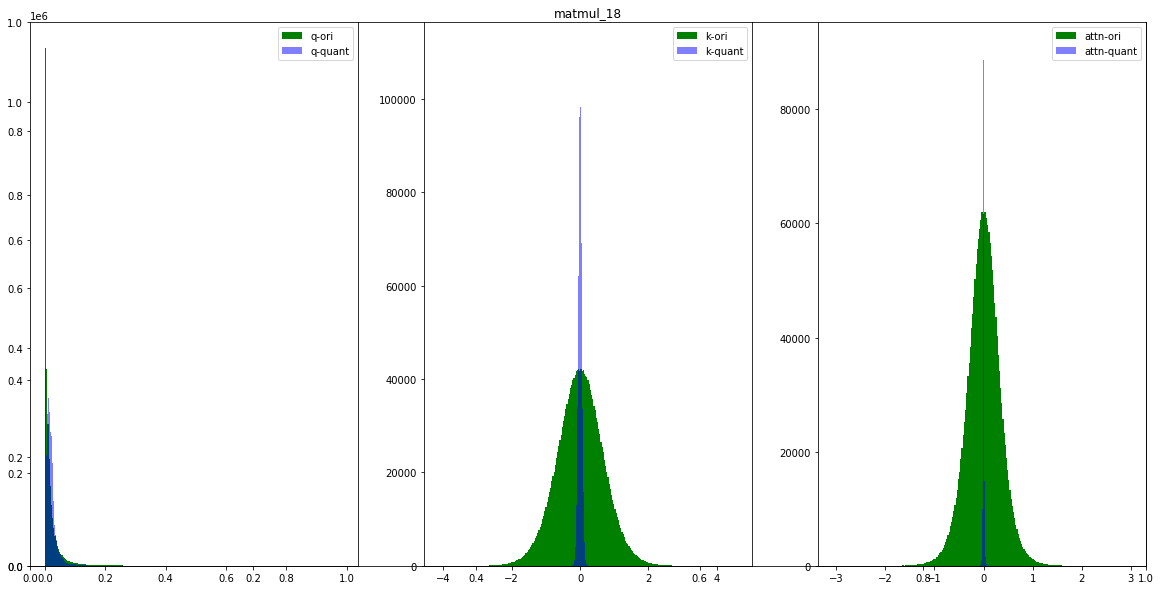

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


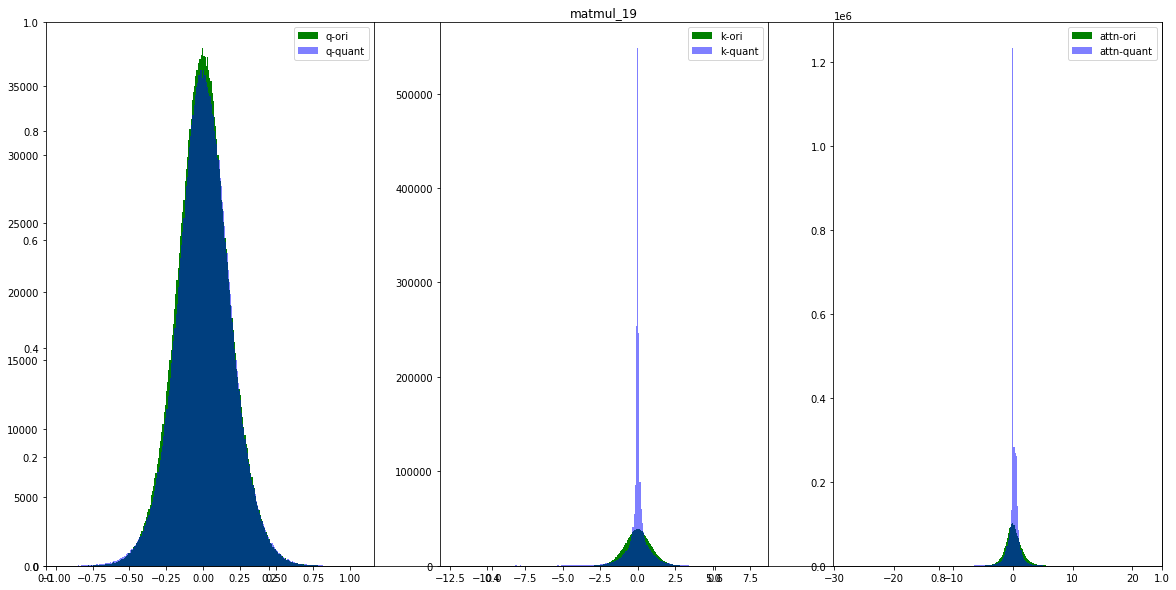

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


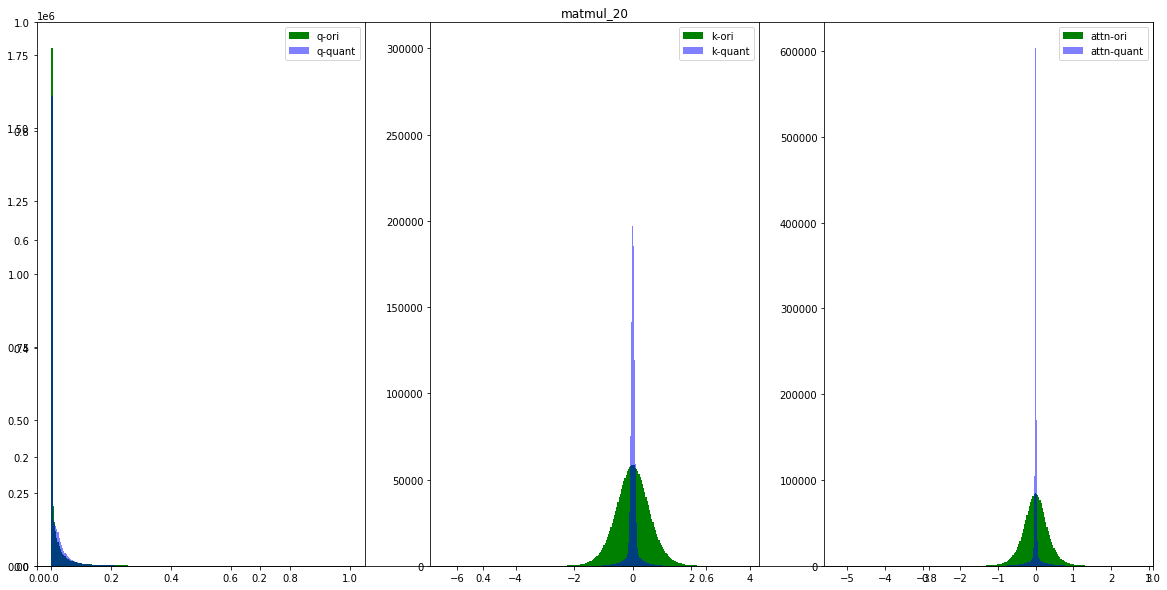

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


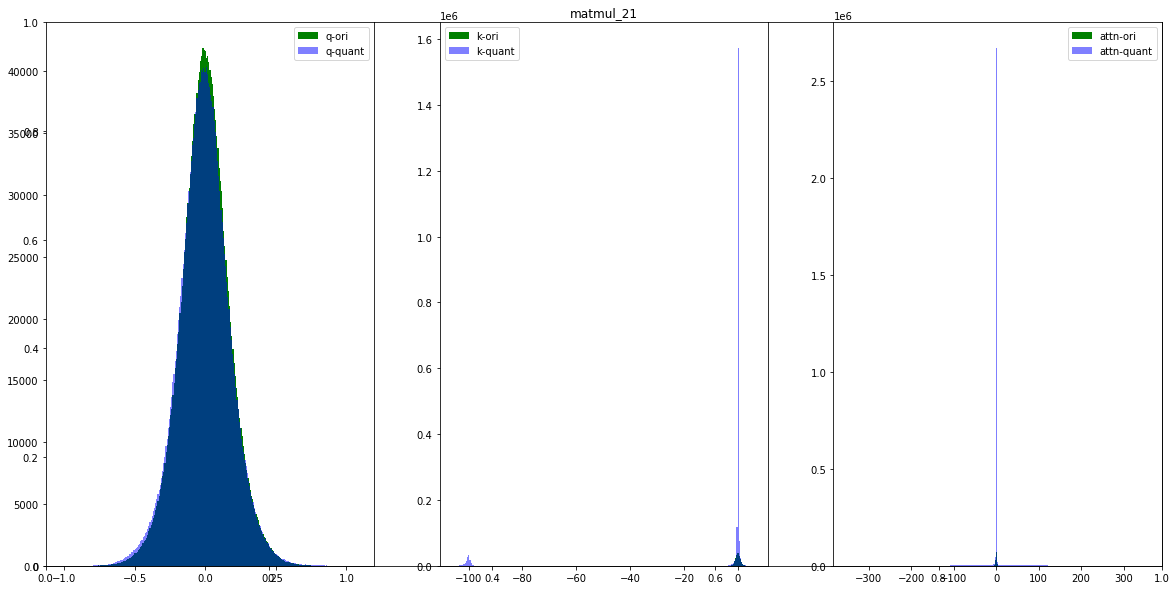

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


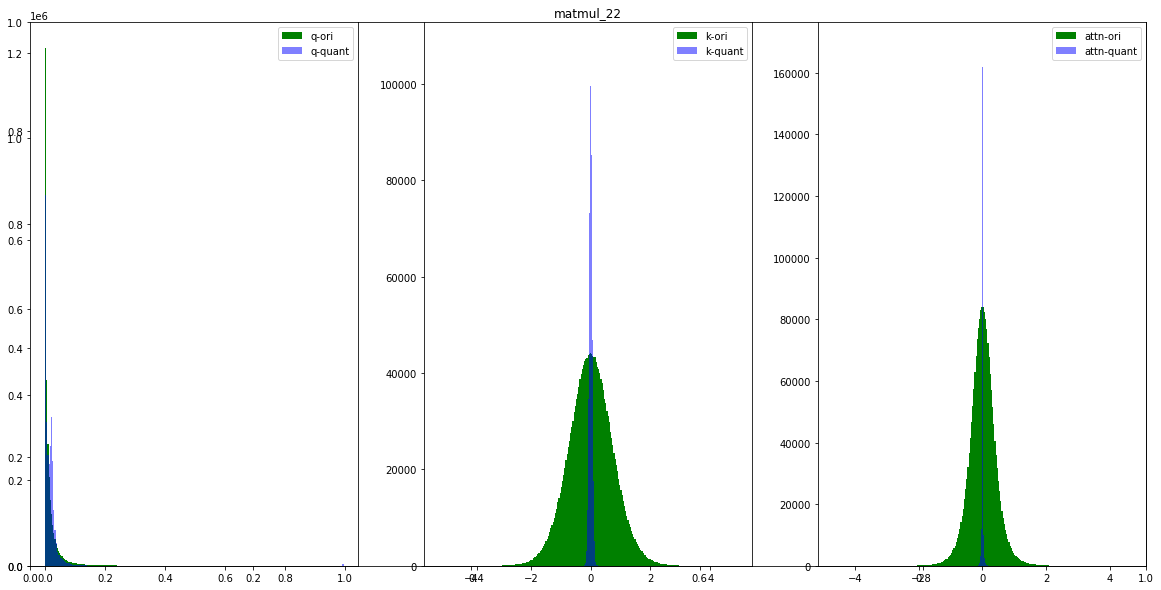

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


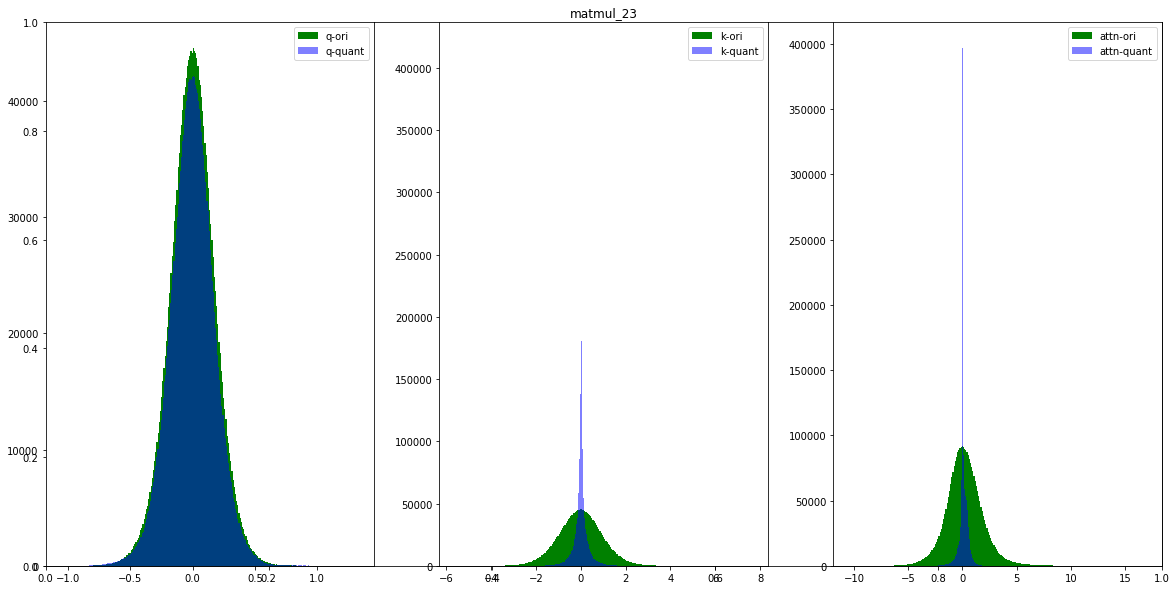

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


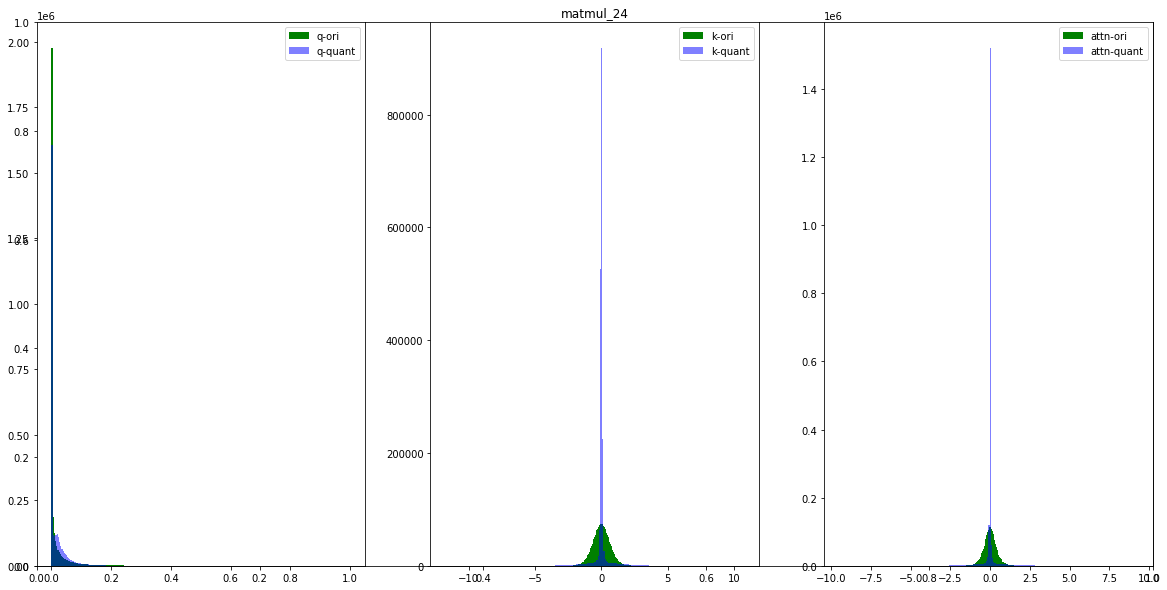

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


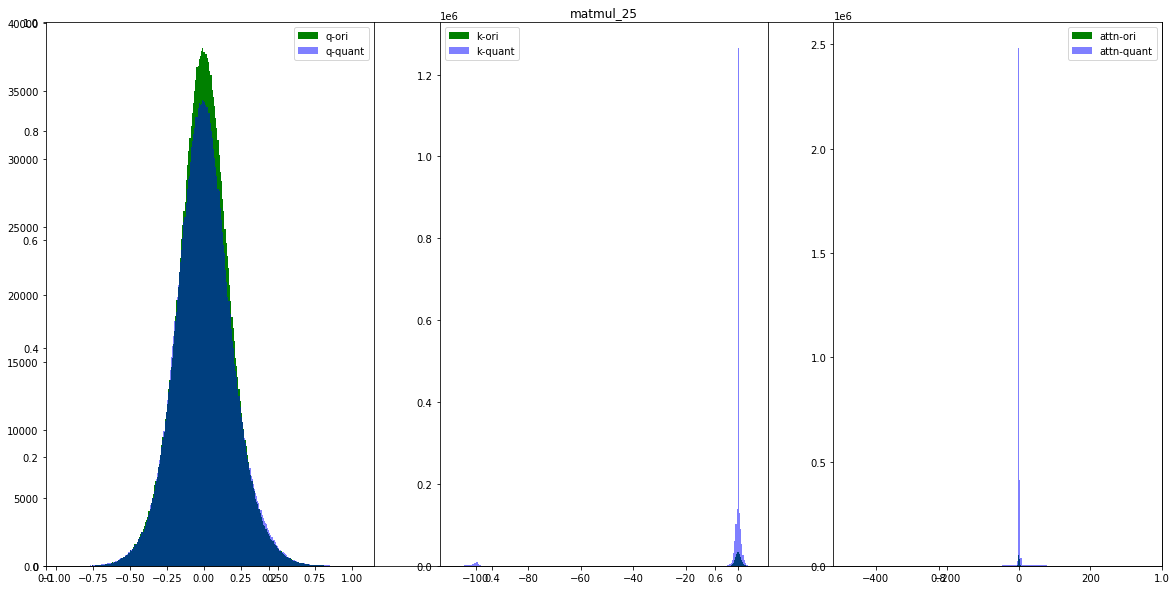

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


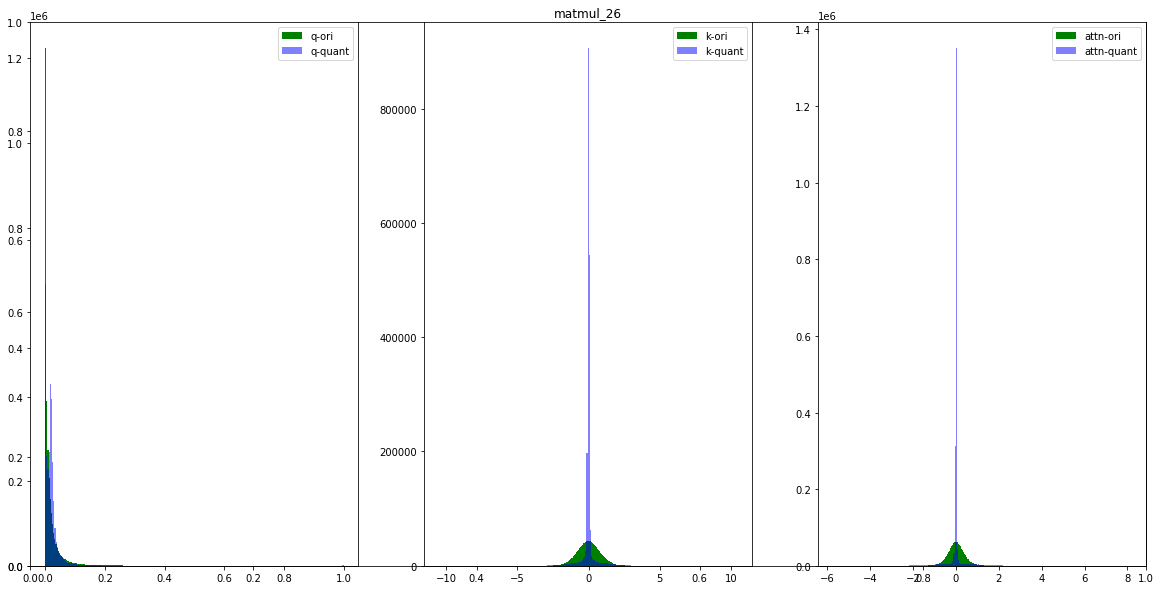

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


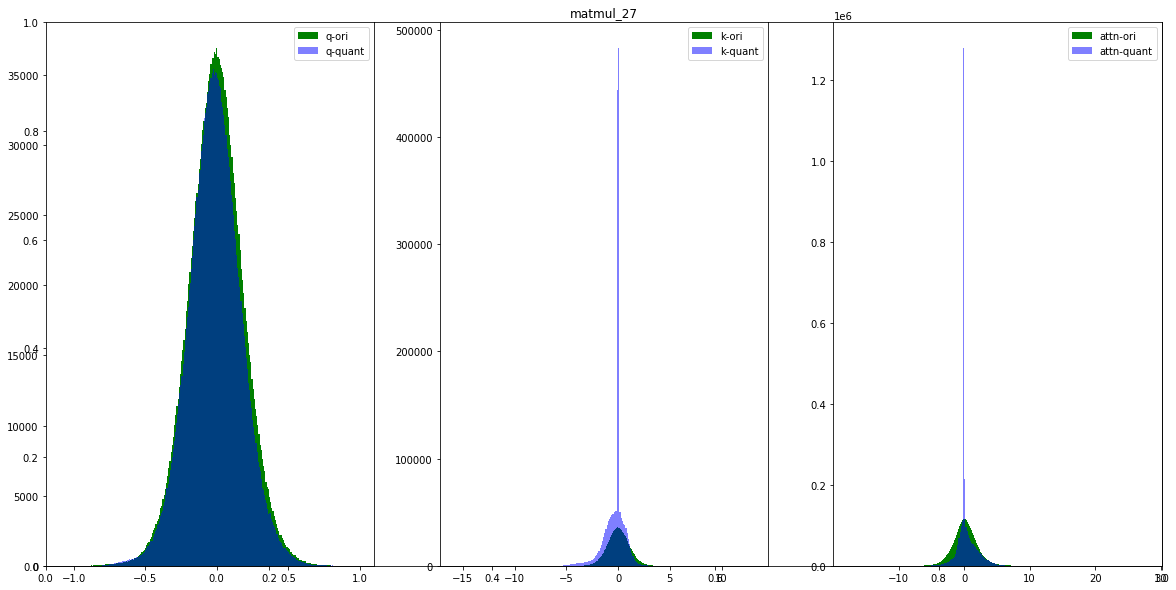

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


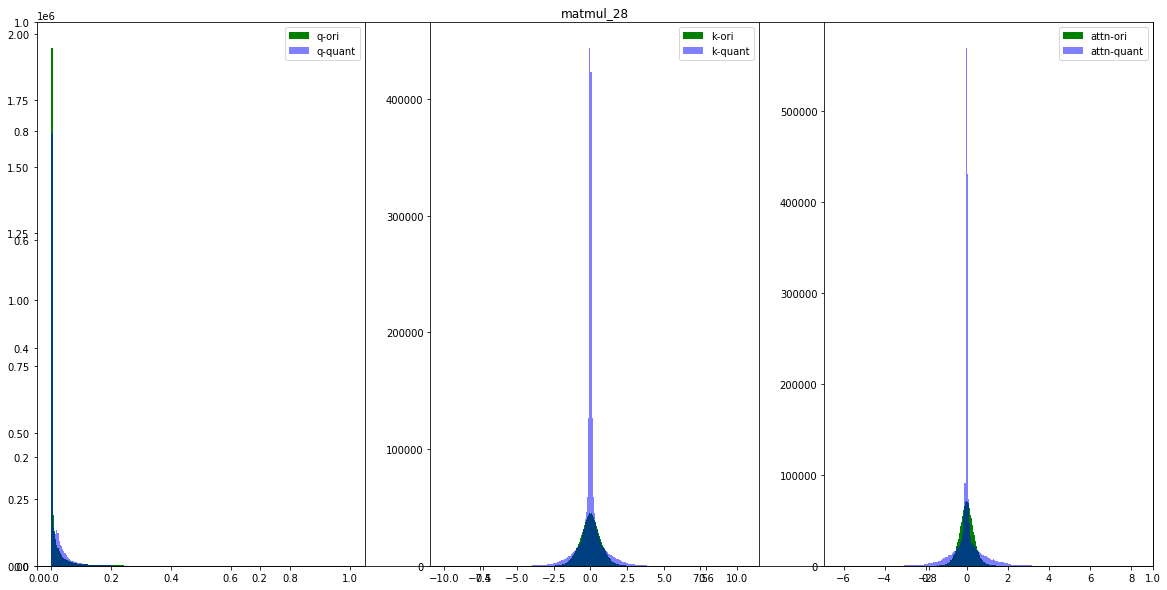

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


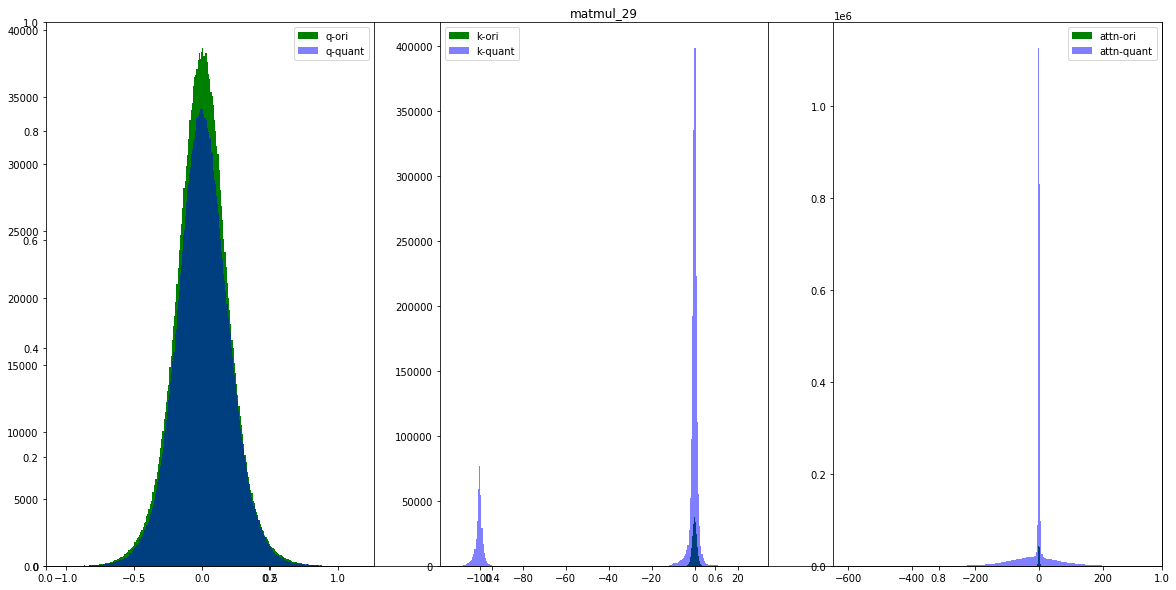

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


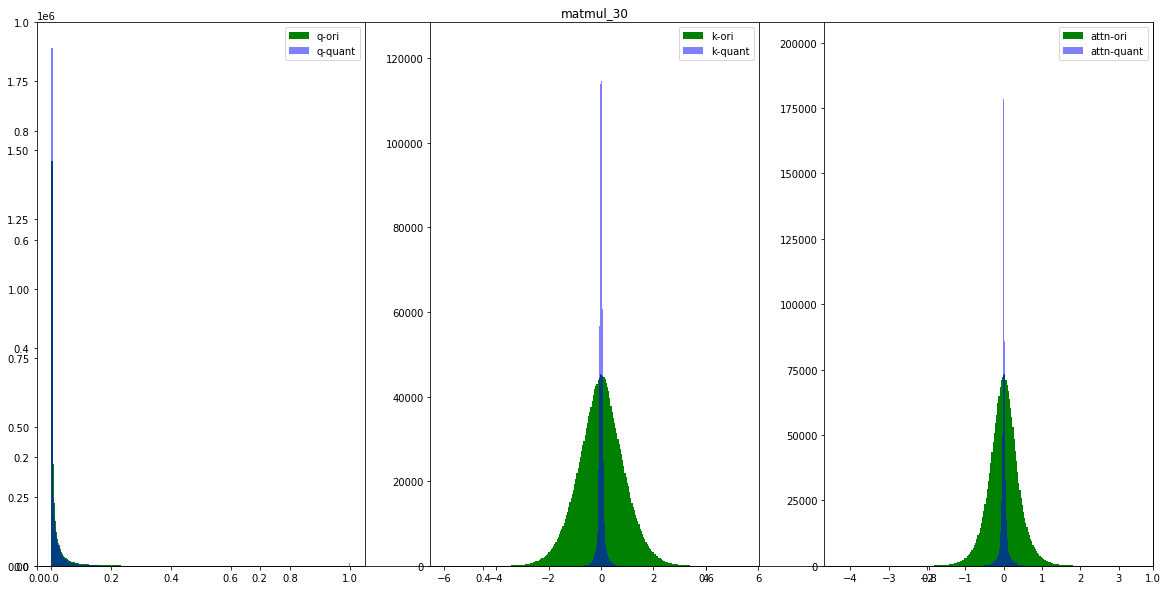

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


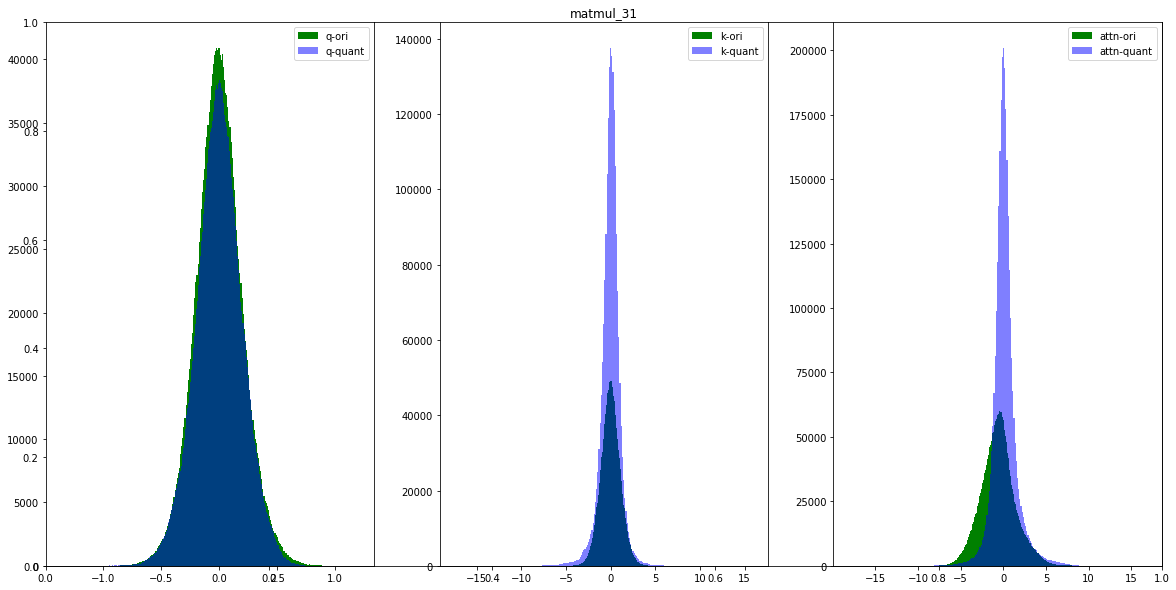

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


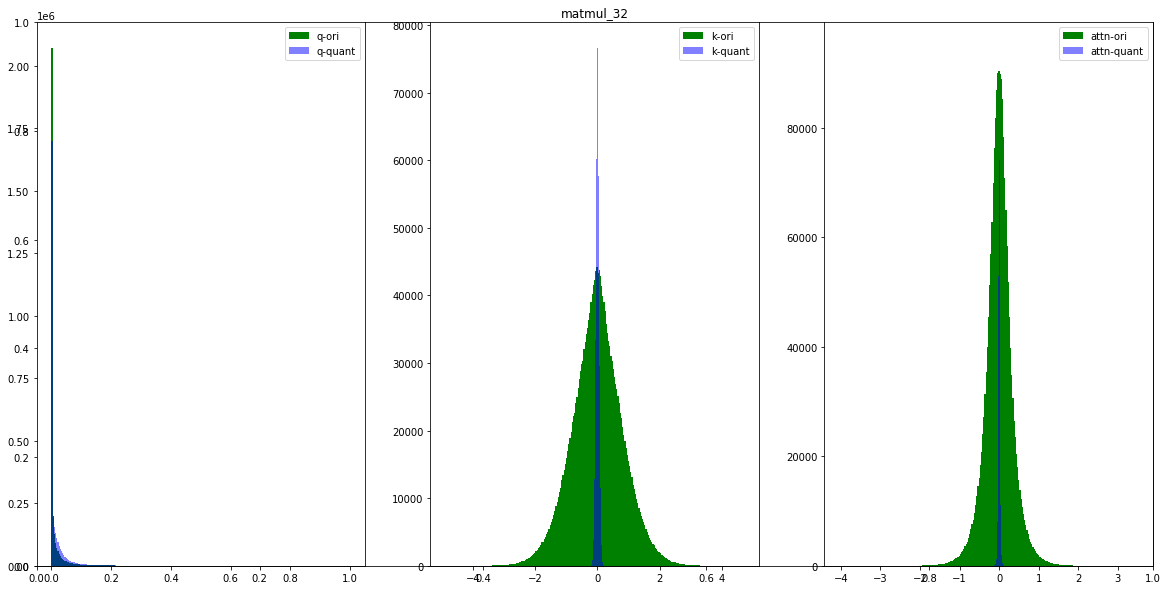

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


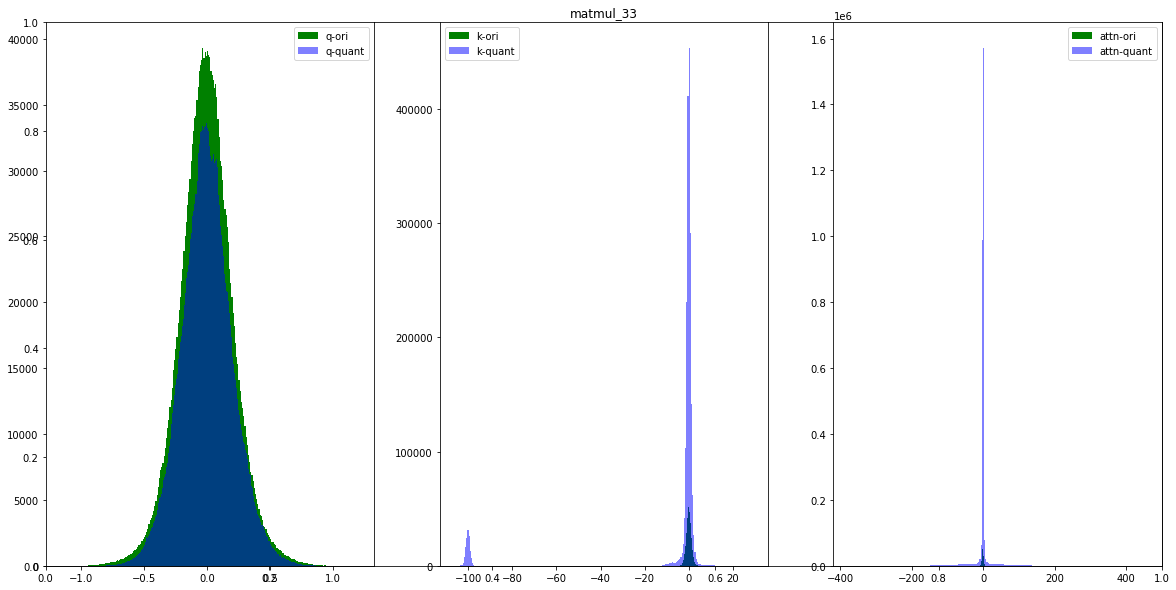

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


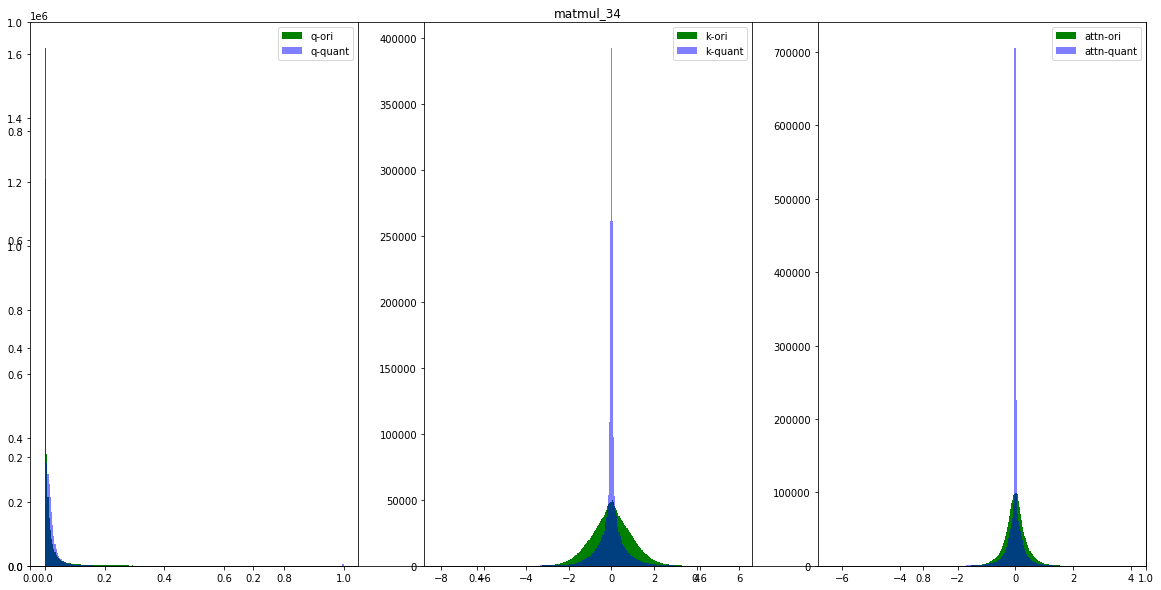

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


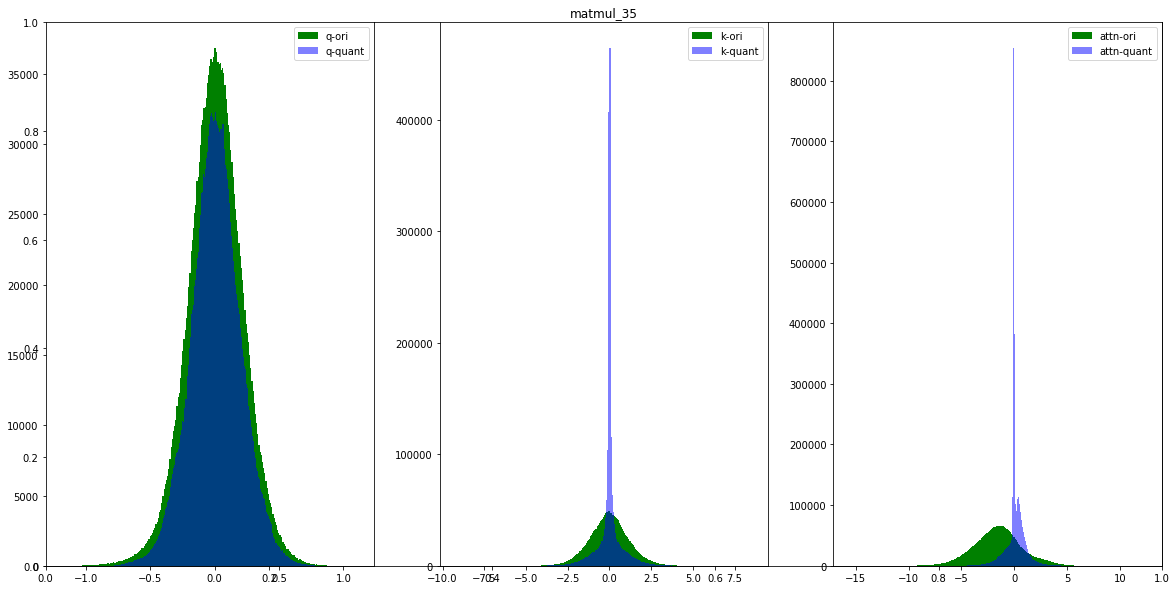

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


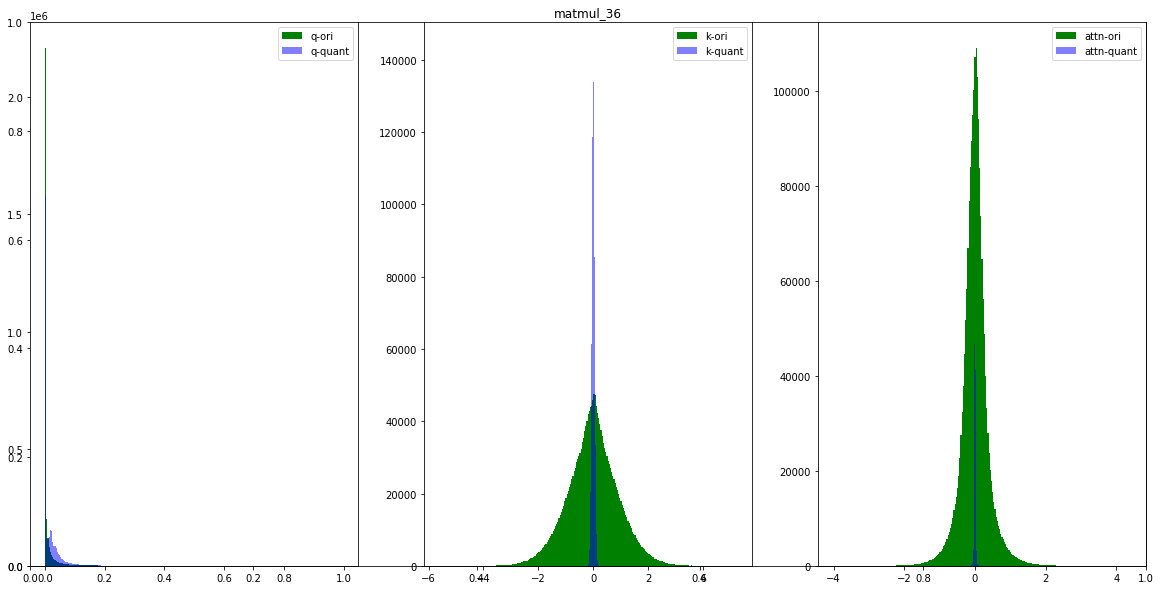

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


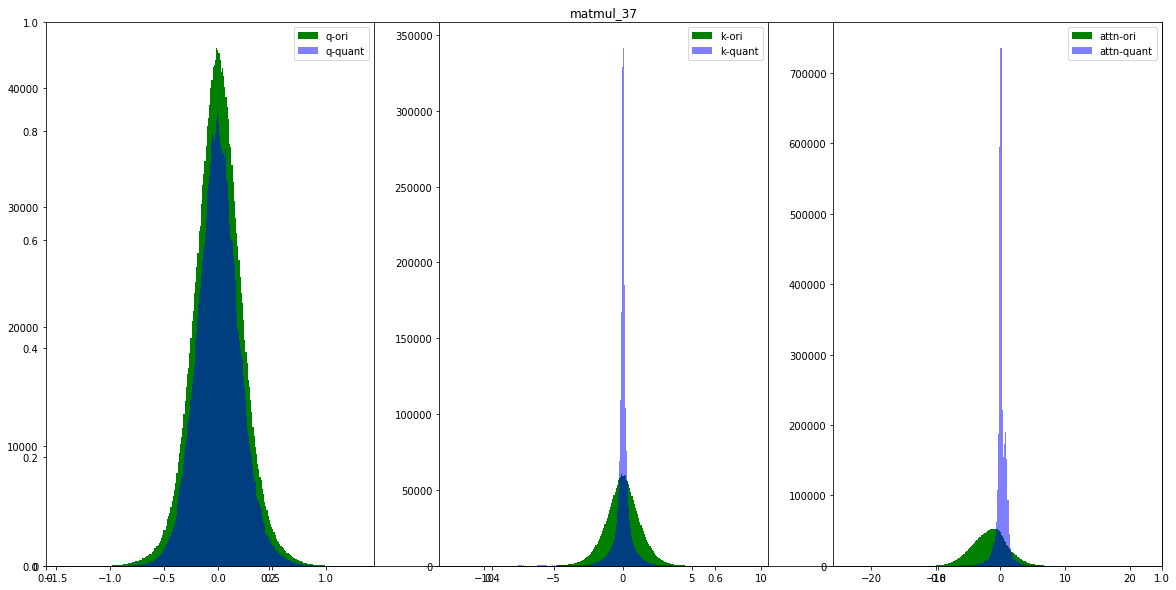

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


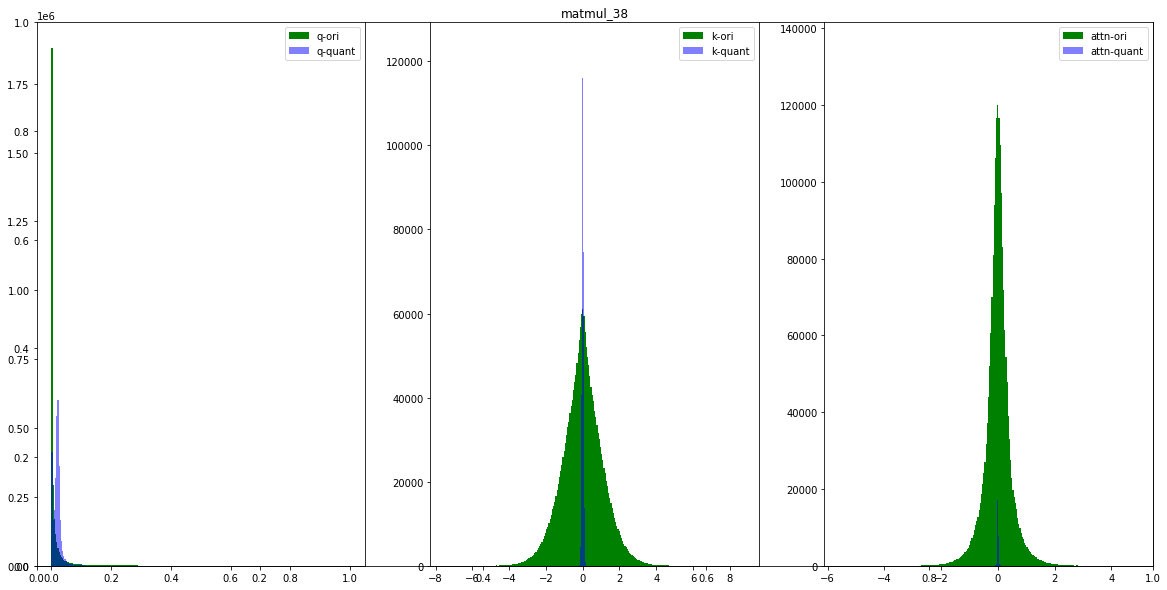

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


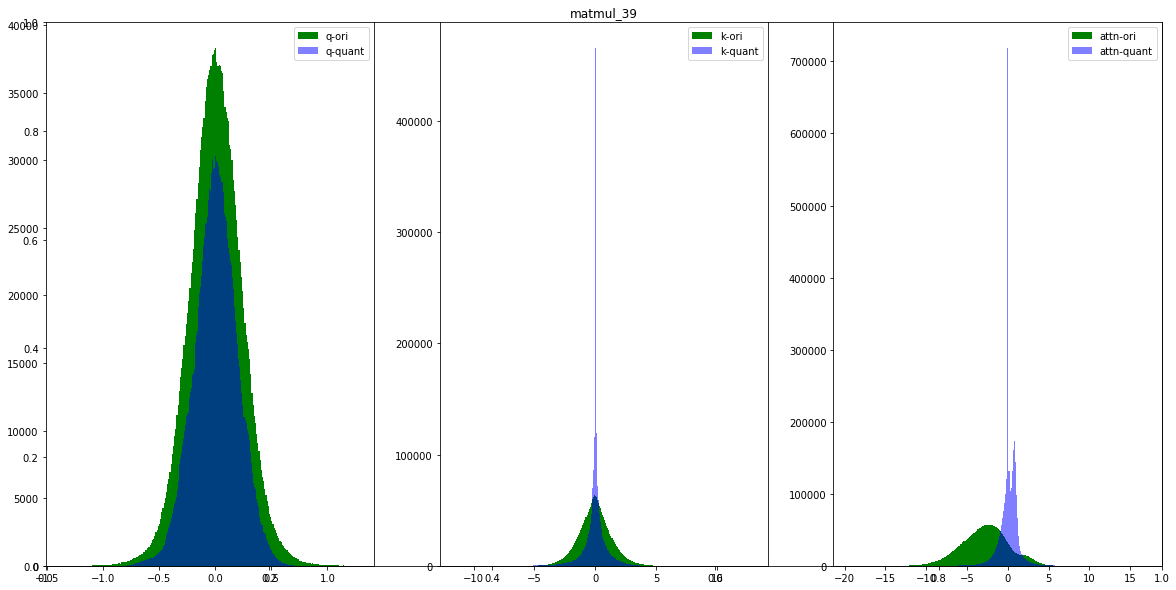

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


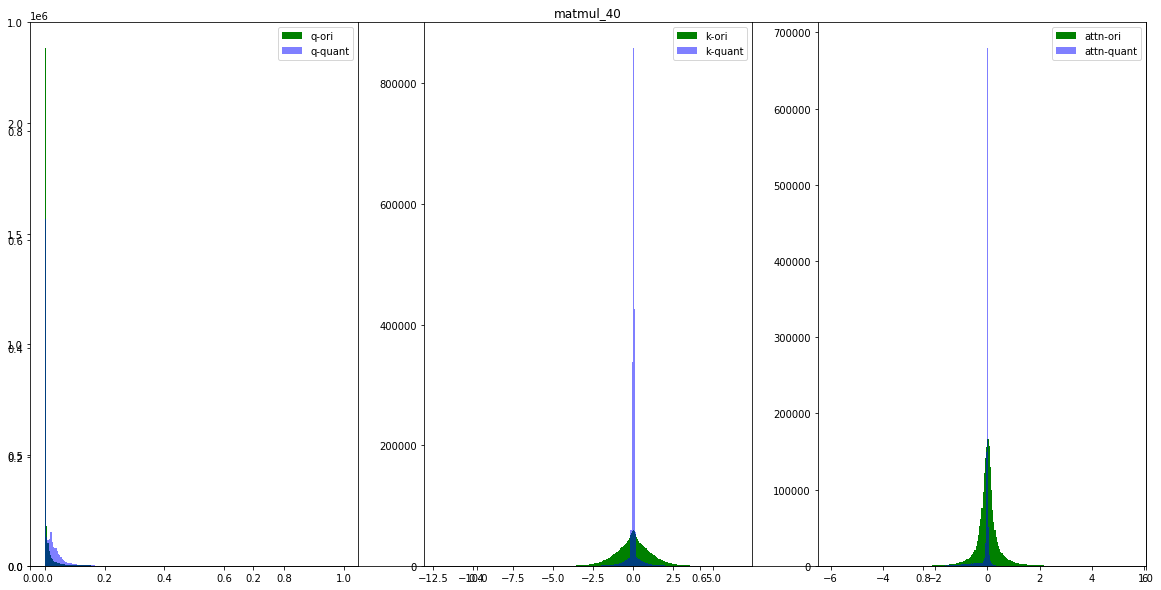

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


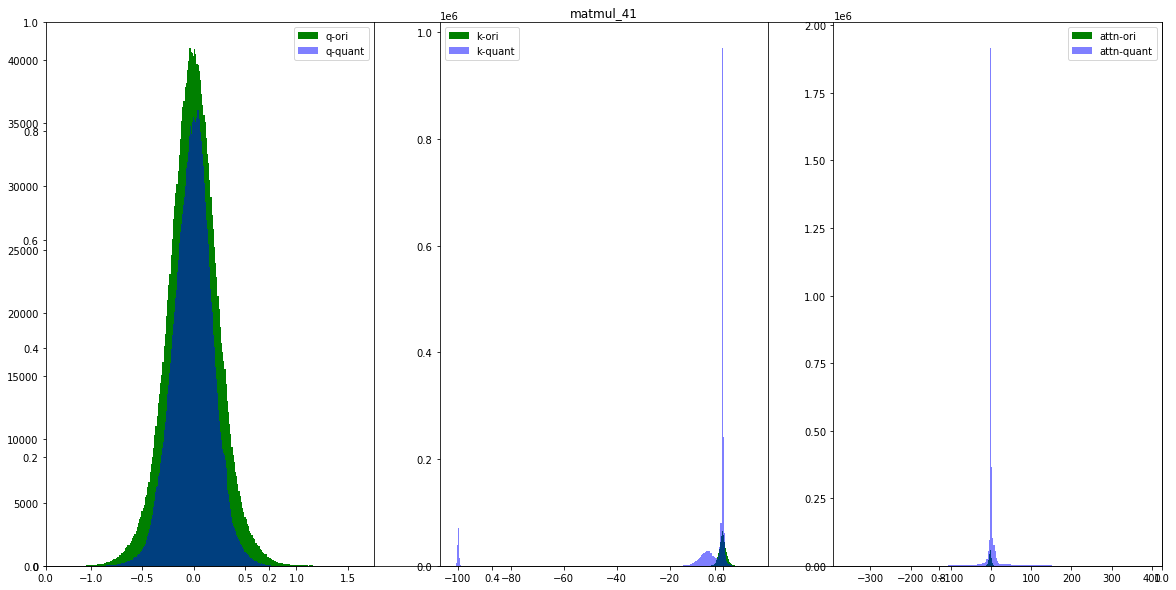

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


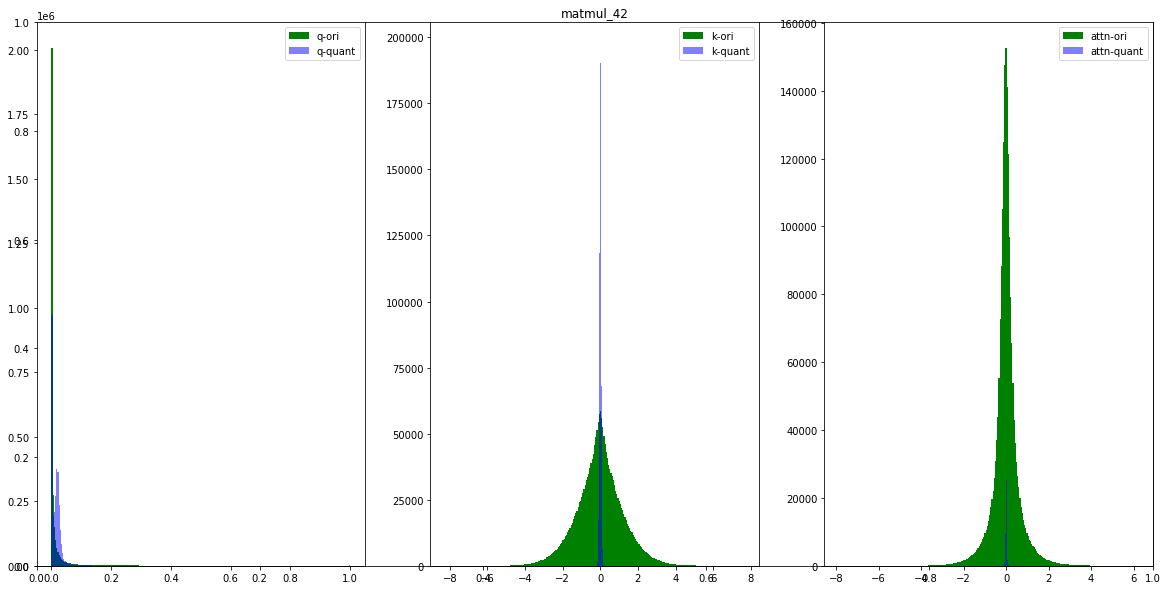

(2007040,) (2007040,)
(2007040,) (2007040,)
(3073280,) (3073280,)


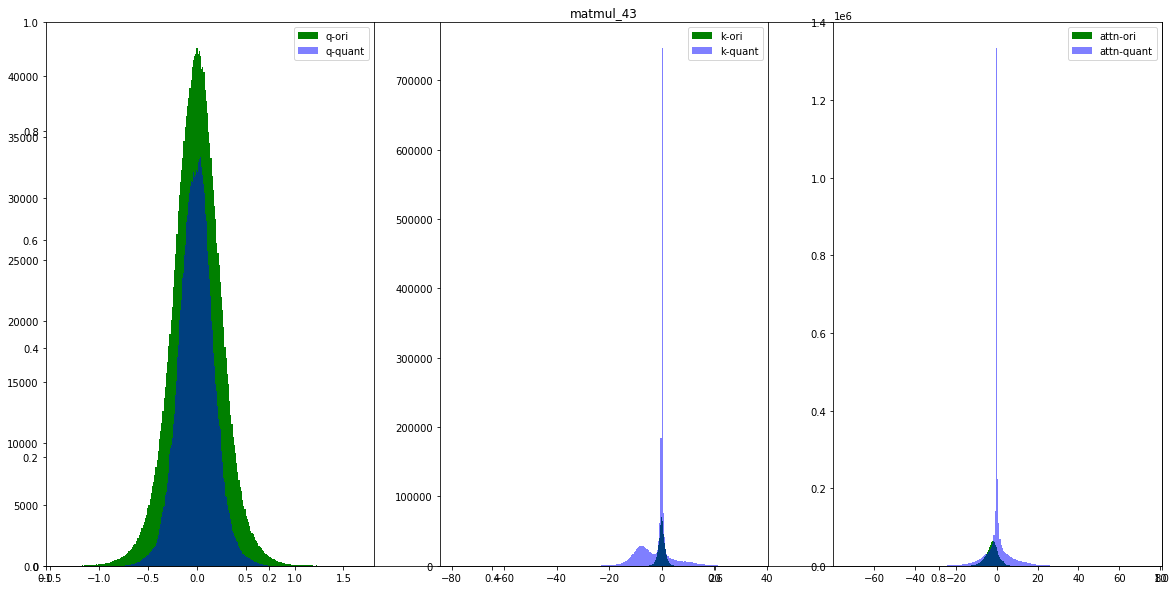

(3073280,) (3073280,)
(2007040,) (2007040,)
(2007040,) (2007040,)


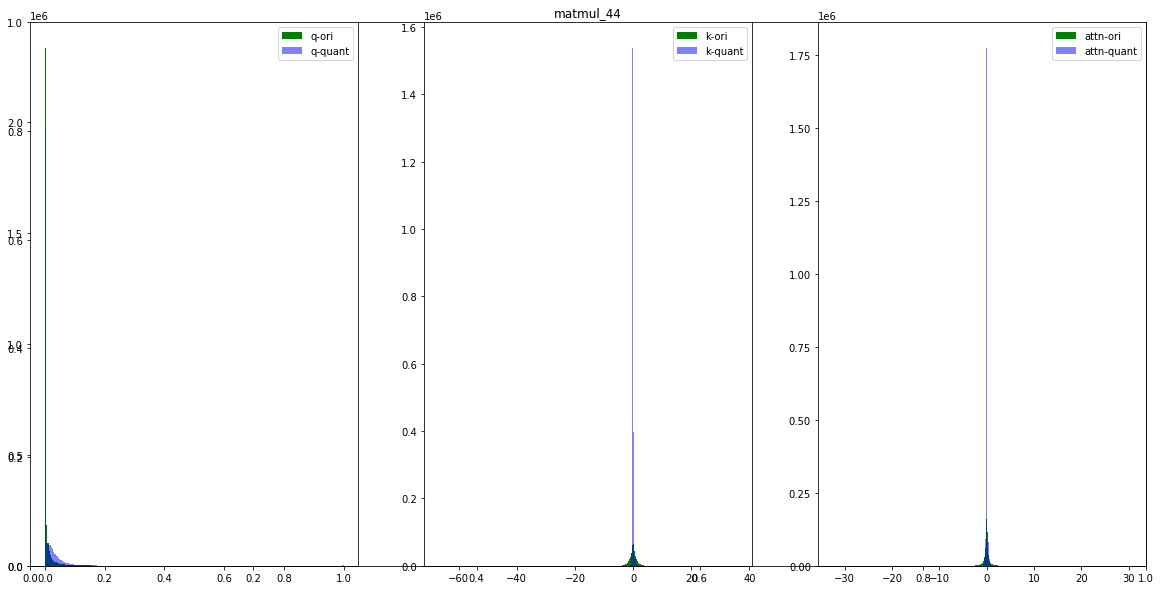

(1003520,) (1003520,)
(1003520,) (1003520,)
(1536640,) (1536640,)


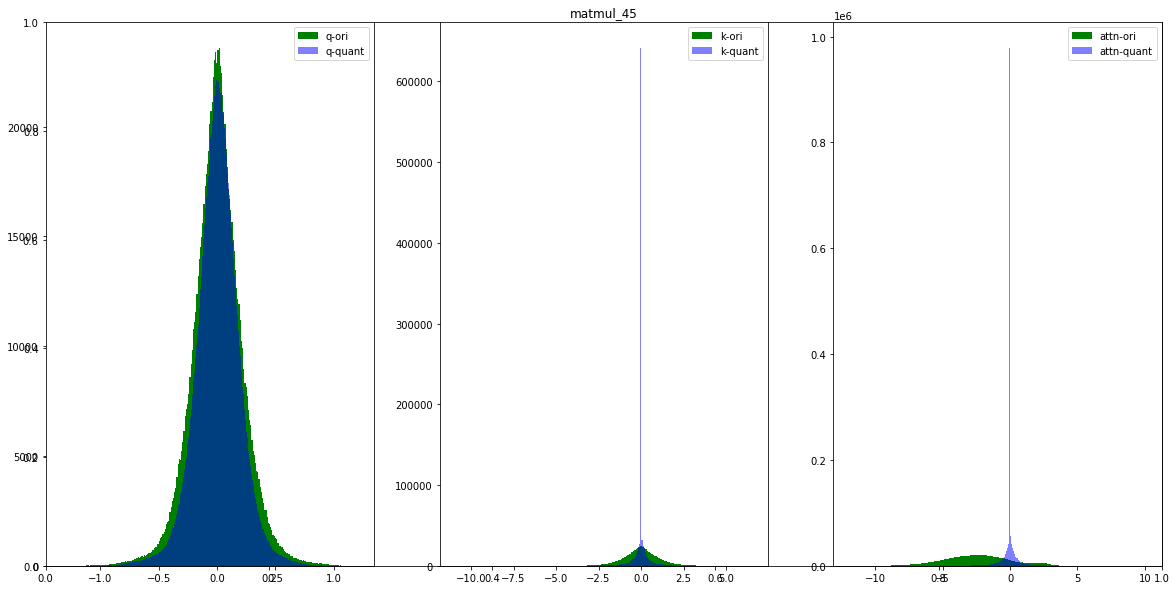

(1536640,) (1536640,)
(1003520,) (1003520,)
(1003520,) (1003520,)


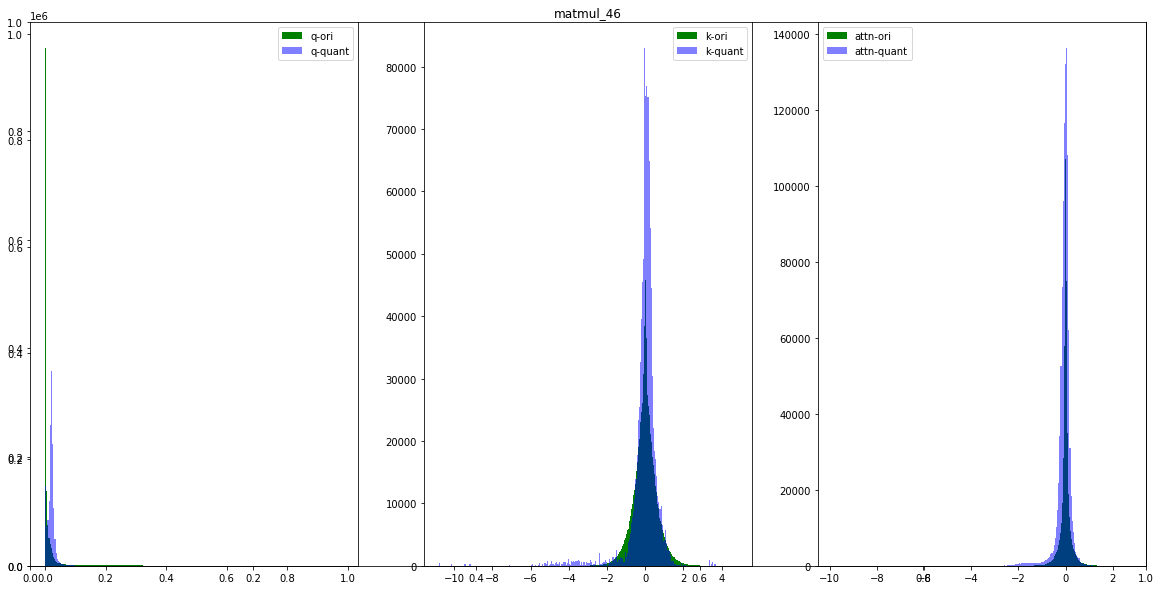

(1003520,) (1003520,)
(1003520,) (1003520,)
(1536640,) (1536640,)


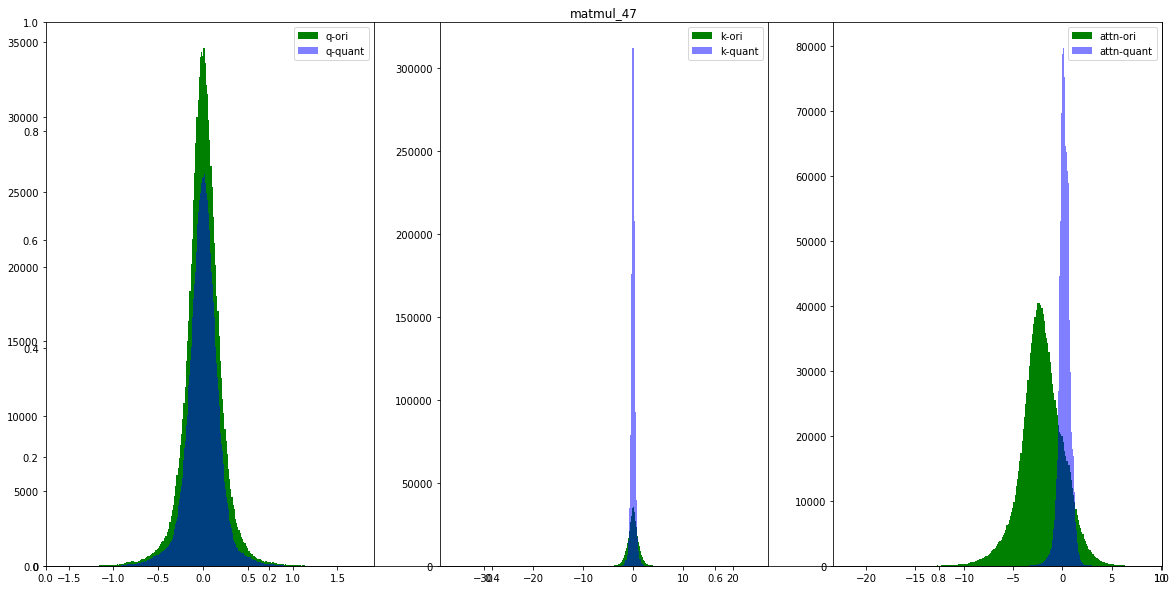

(1536640,) (1536640,)
(1003520,) (1003520,)
(1003520,) (1003520,)


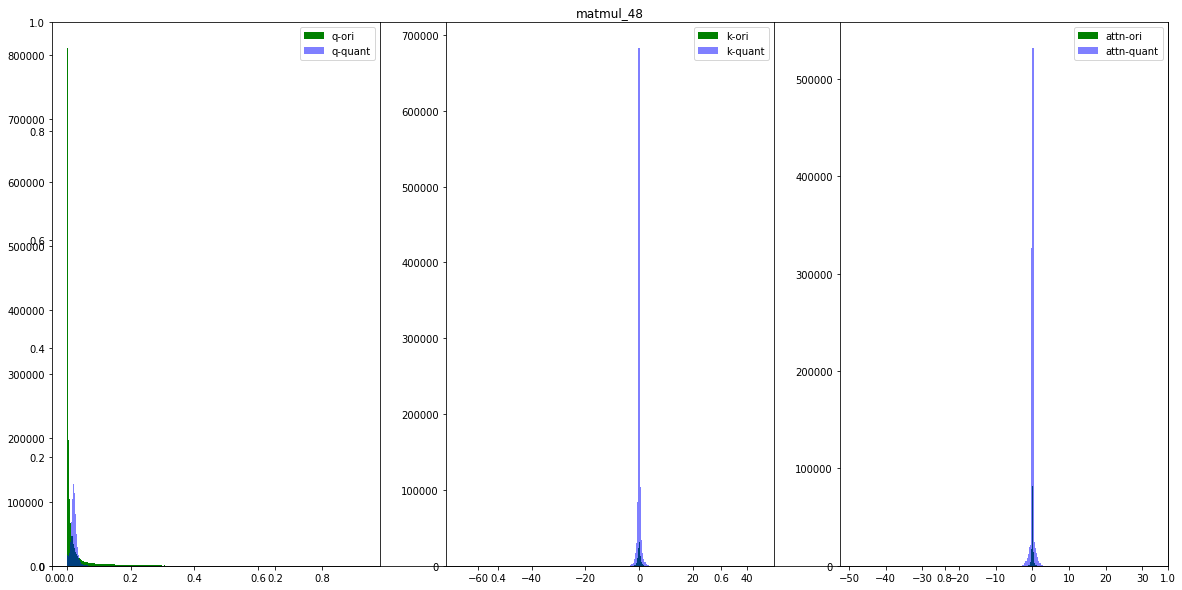

In [27]:
def plot2_hist(input1:list,input2,key): # input1:ori input2:quant
    alpha = 0.5
    c1 = 'green'
    c2 = 'blue'

    fig = plt.figure(figsize=(20,10),)
    plt.title(key)
    # fig.set_title(key)
    ax1,ax2,ax3 = fig.subplots(1,3)
    # ax1 = fig.subplot(131)
    # ax2 = fig.subplot(132)
    # ax3 = fig.subplot(133)
    
    # for q
    q_in_ori = np.concatenate([i[0] for i in input1]).flatten()
    q_in_quant = np.concatenate([i[0] for i in input2]).flatten()
    assert(q_in_ori.shape==q_in_quant.shape)
    print(q_in_ori.shape,q_in_quant.shape)
    ax1.hist(q_in_ori,bins=255,label='q-ori',color=c1)
    ax1.hist(q_in_quant,bins=255,label='q-quant',alpha=alpha,color=c2)
    ax1.legend()
    # ax1.hist(np.concatenate([i[0] for i in input2]).flatten(),bins=255,label='q-quant')

    # for k
    k_in_ori = np.concatenate([i[1] for i in input1]).flatten()
    k_in_quant = np.concatenate([i[1] for i in input2]).flatten()
    assert(k_in_ori.shape==k_in_quant.shape)
    print(k_in_ori.shape,k_in_quant.shape)
    ax2.hist(k_in_ori,bins=255,label='k-ori',color=c1)
    ax2.hist(k_in_quant,bins=255,label='k-quant',color=c2,alpha=alpha)
    ax2.legend()

    # ax2.hist(np.concatenate([i[1] for i in input1]).flatten(),bins=255,label='k-ori')
    # ax2.hist(np.concatenate([i[1] for i in input2]).flatten(),bins=255,label='k-quant')

    # for  q*k
    attn_in_ori = np.concatenate([i[2] for i in input1]).flatten()
    attn_in_quant = np.concatenate([i[2] for i in input2]).flatten()
    assert(attn_in_ori.shape==attn_in_quant.shape)
    print(attn_in_ori.shape,attn_in_quant.shape)
    ax3.hist(attn_in_ori,bins=255,label='attn-ori',color= c1)
    ax3.hist(attn_in_quant,bins=255,label='attn-quant',color=c2,alpha=alpha)
    ax3.legend()


    plt.pause(0.1)
    plt.show()

keys = ori_dict.keys()
for key in keys:
    plot2_hist(ori_dict[key],quant_dict[key],key)

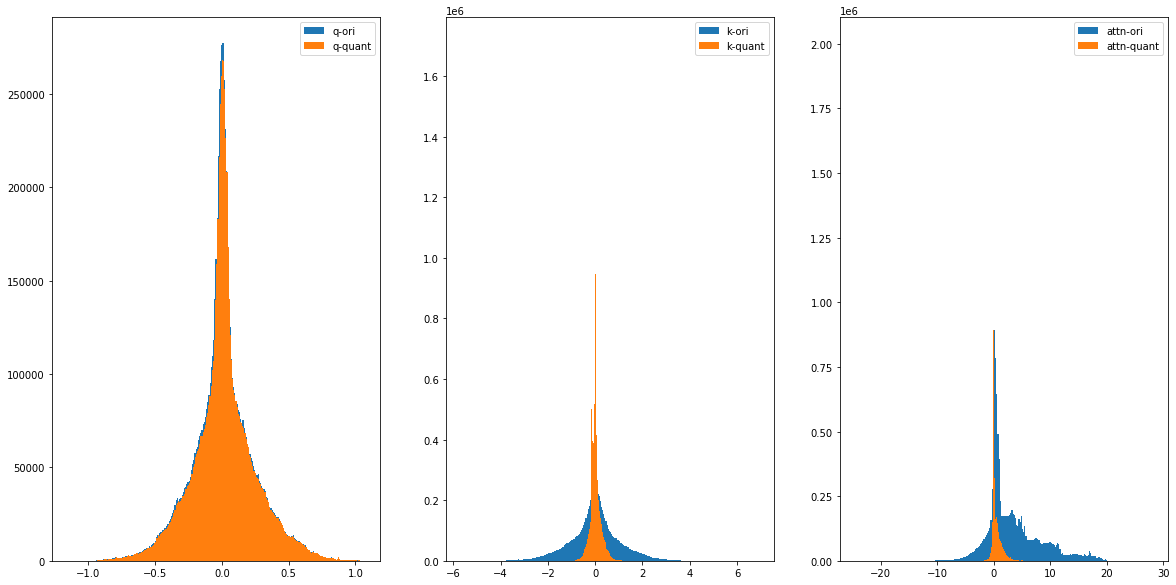

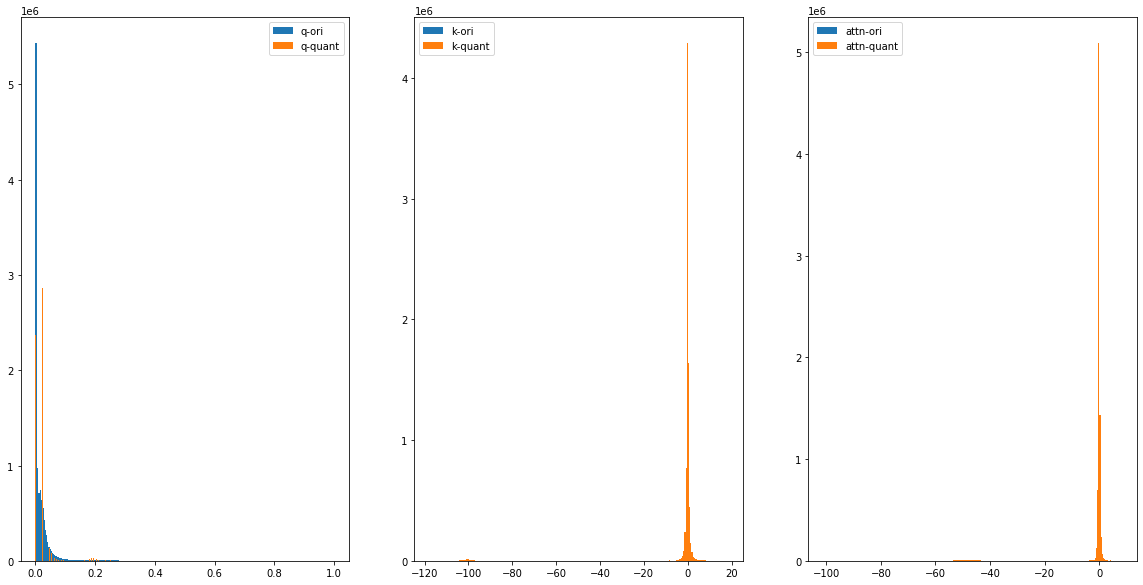

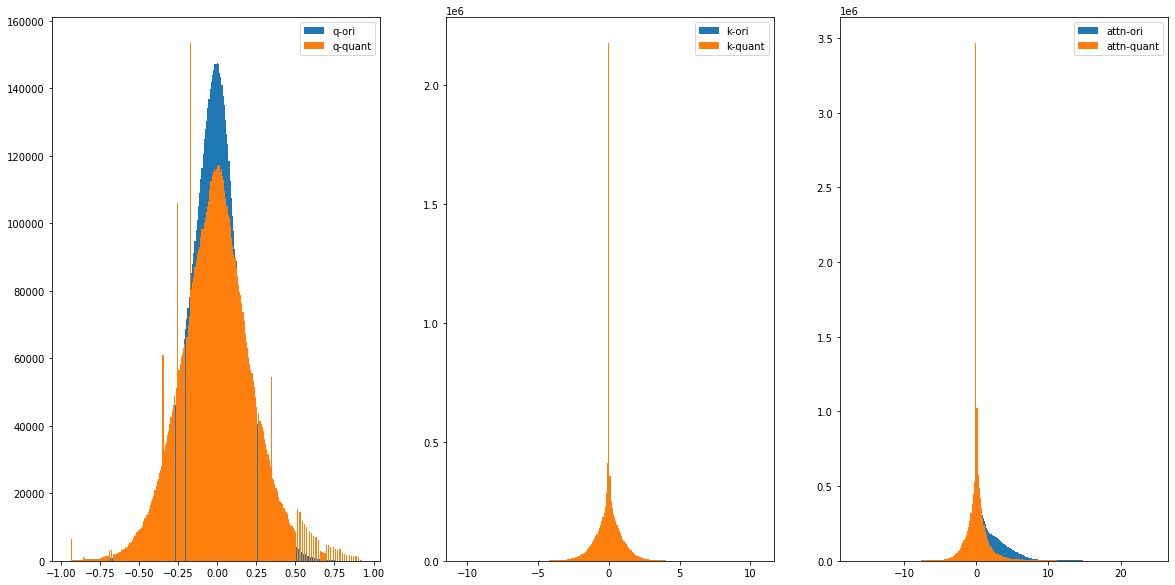

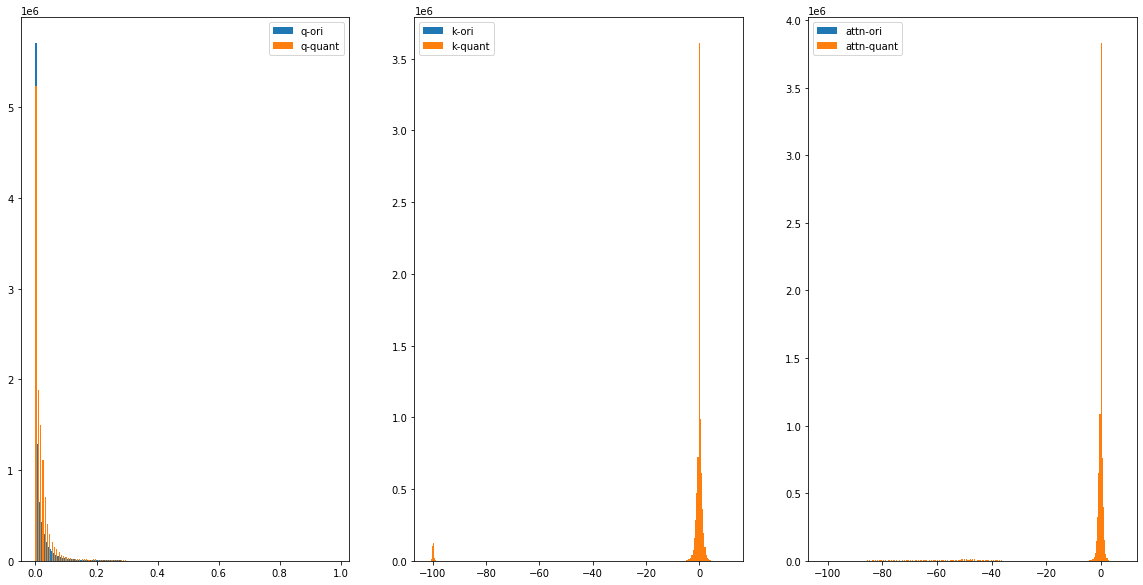

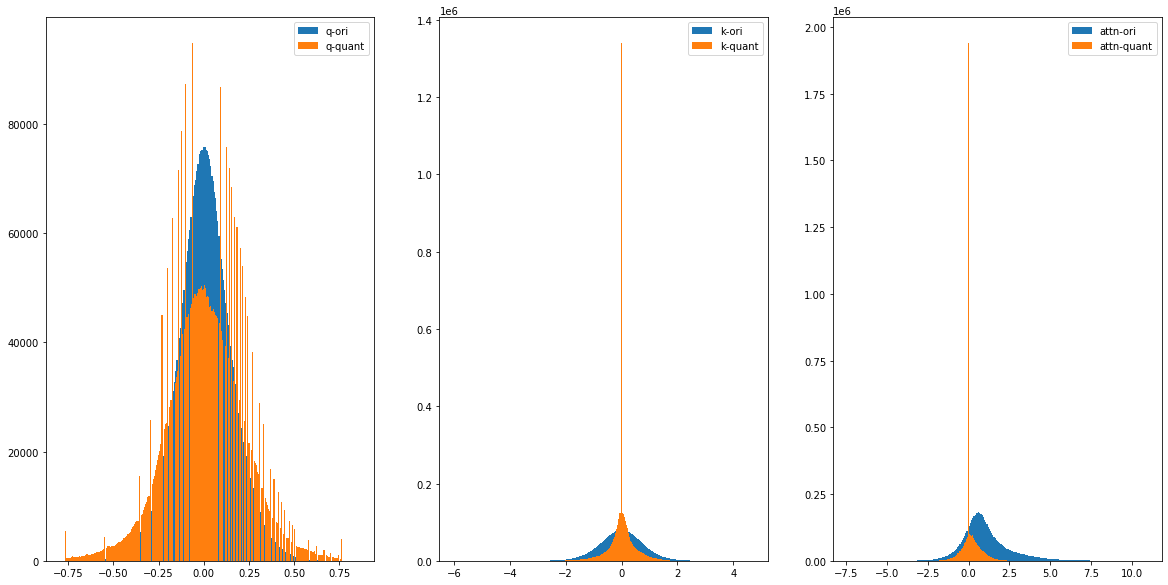

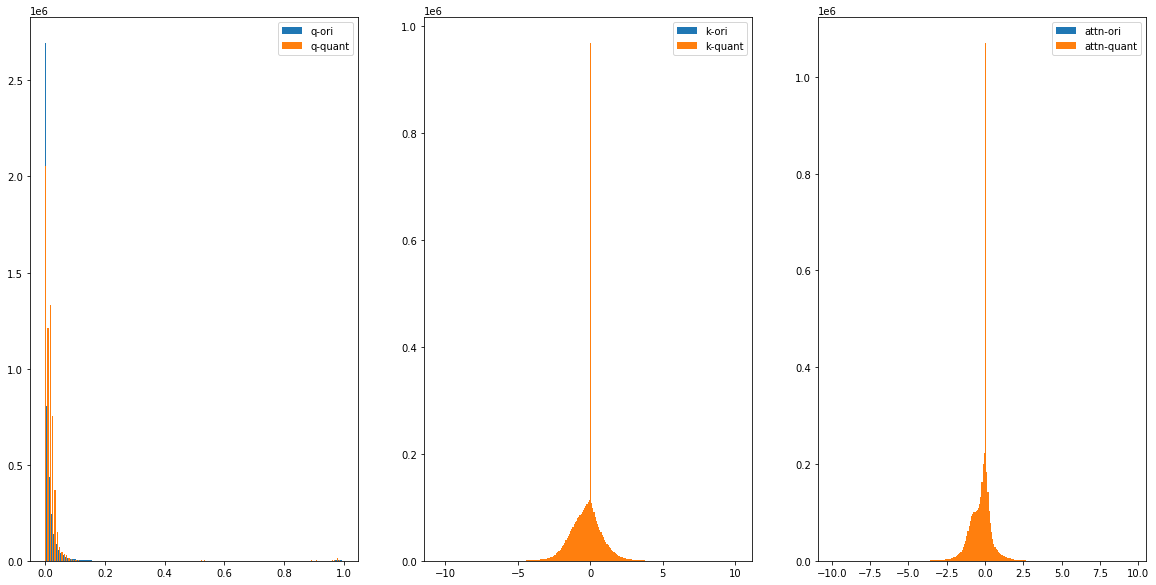

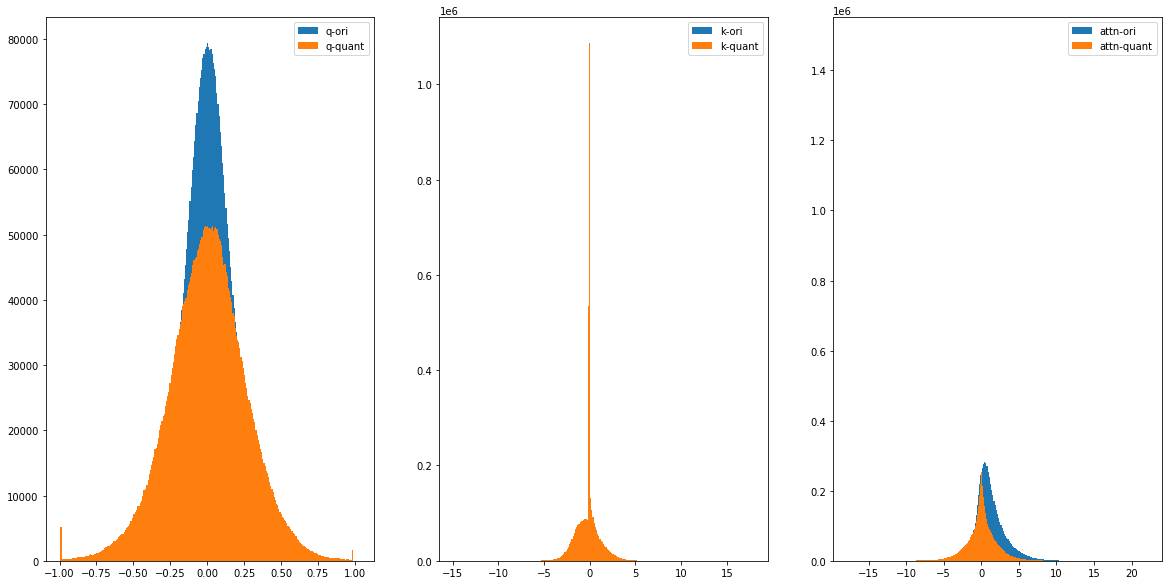

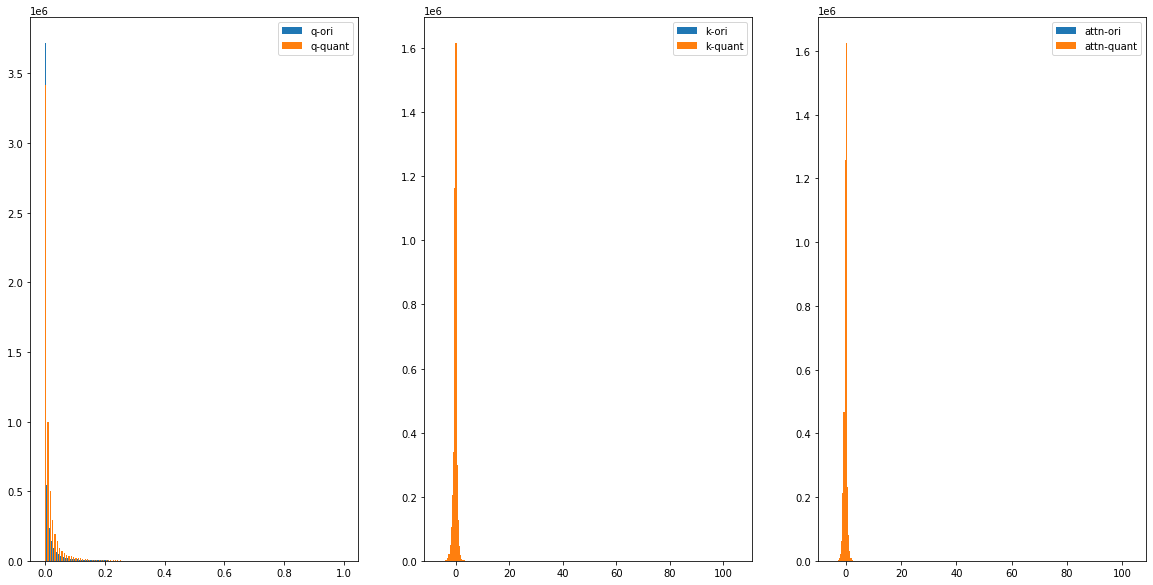

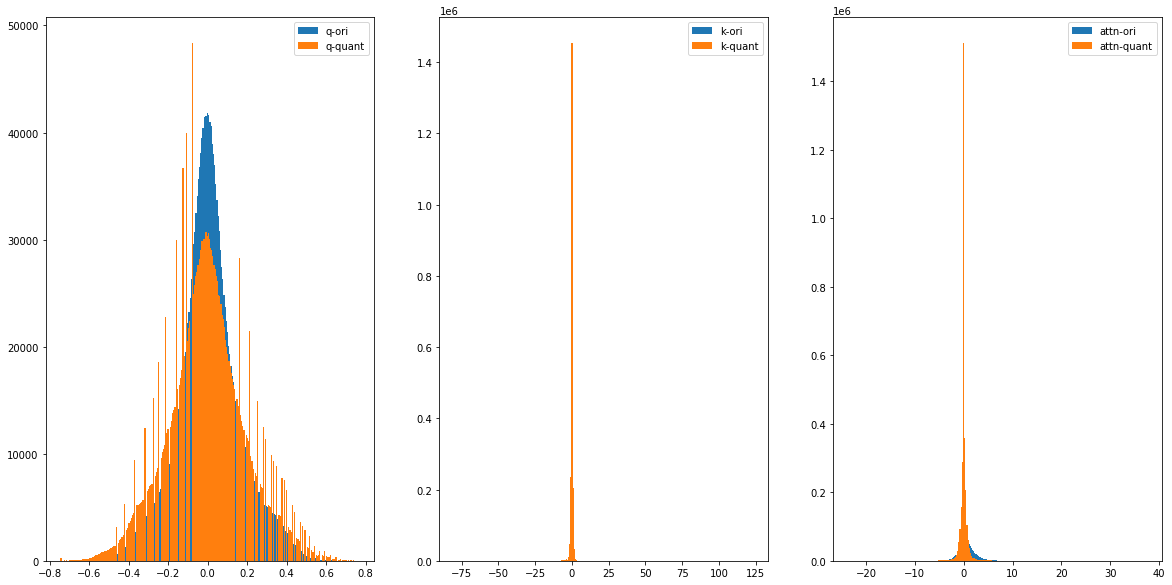

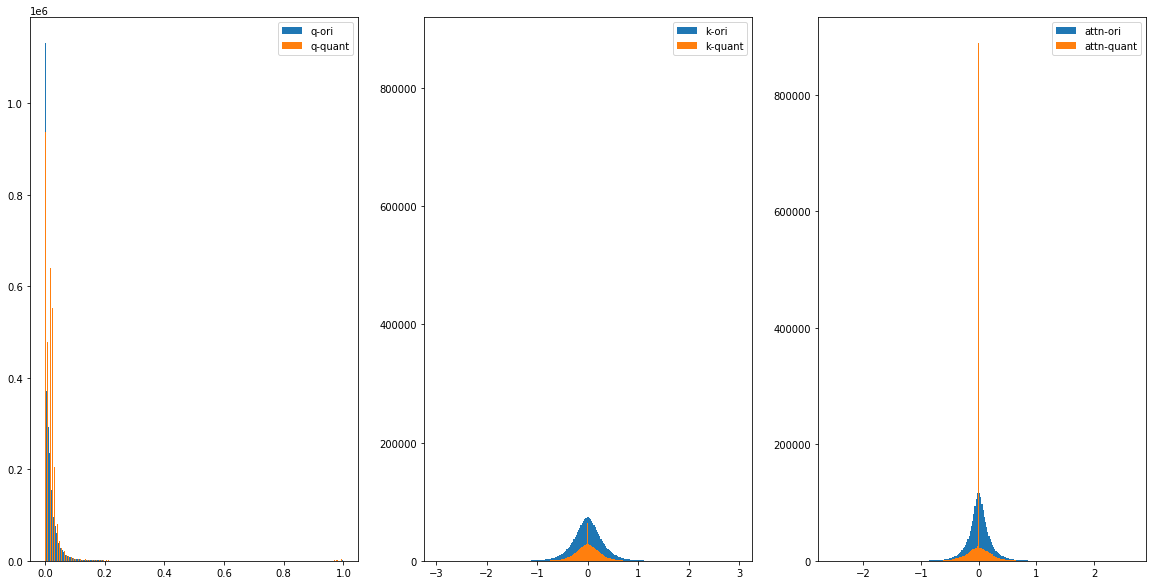

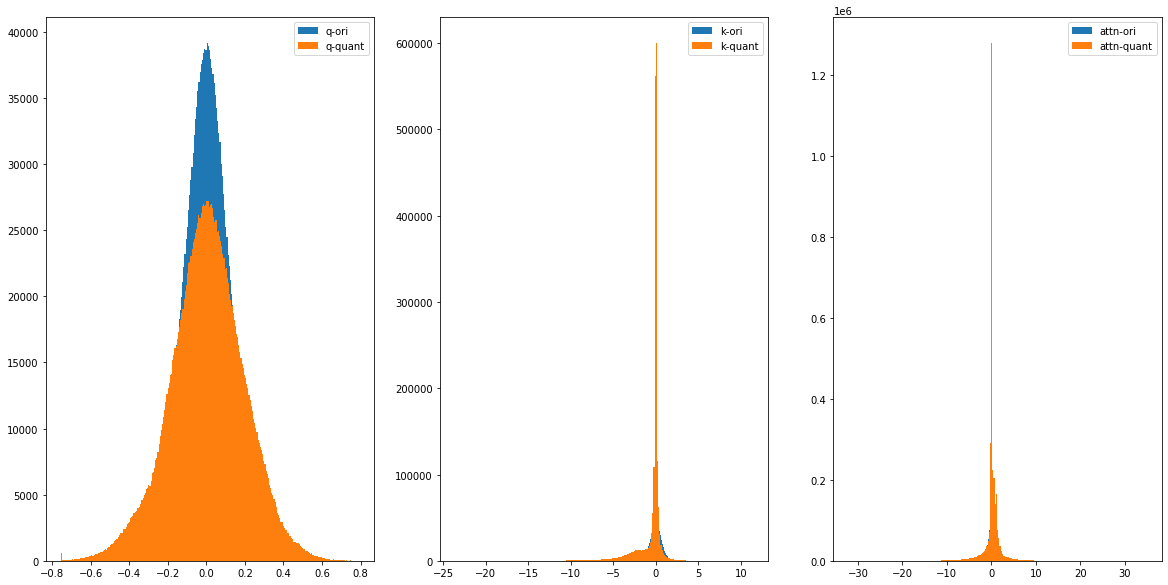

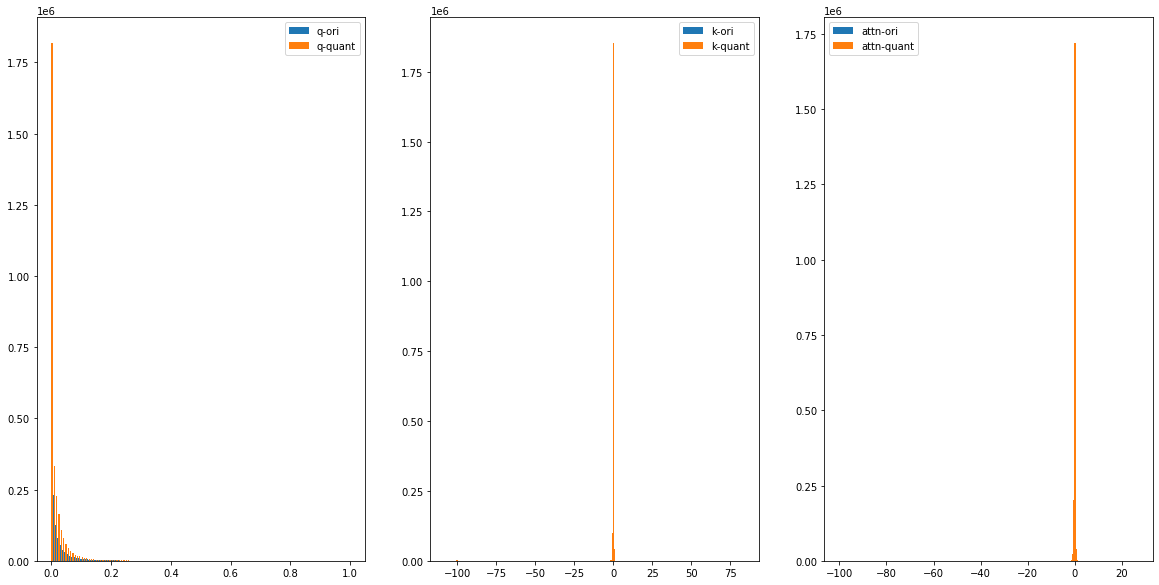

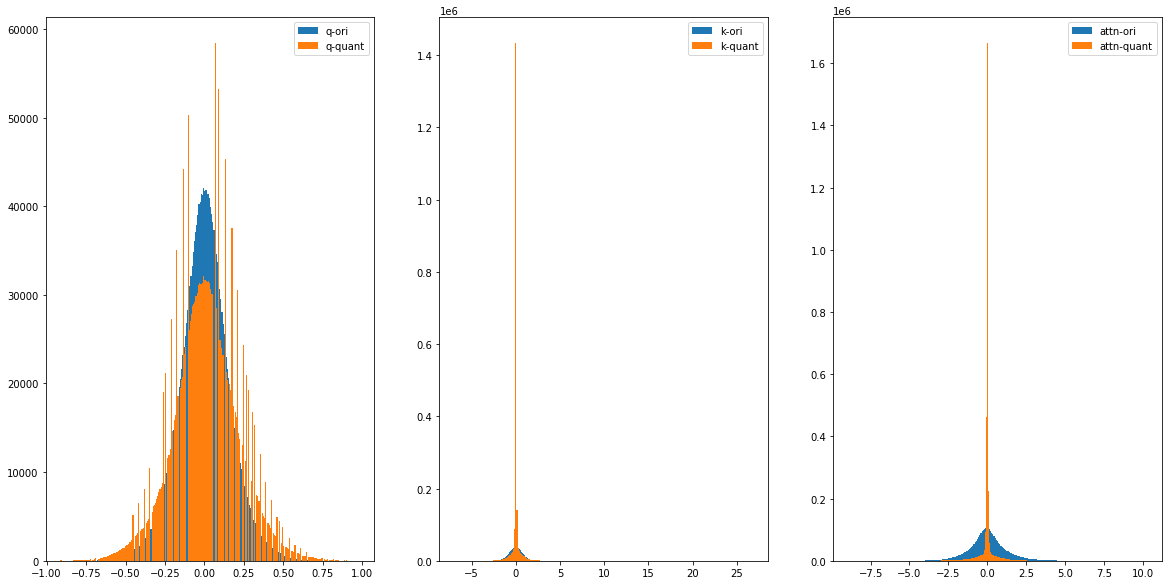

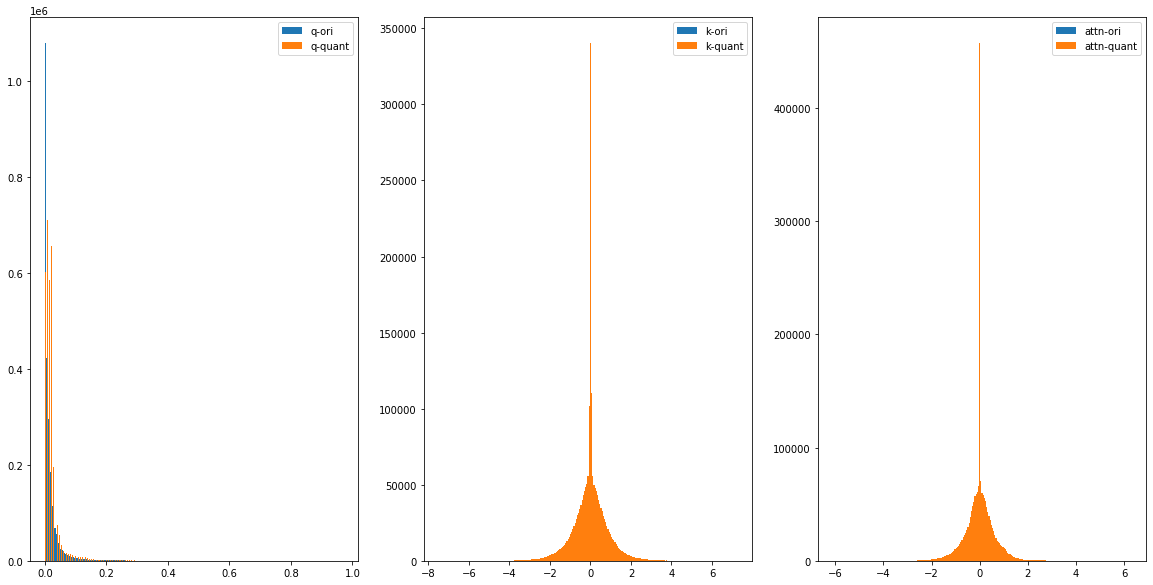

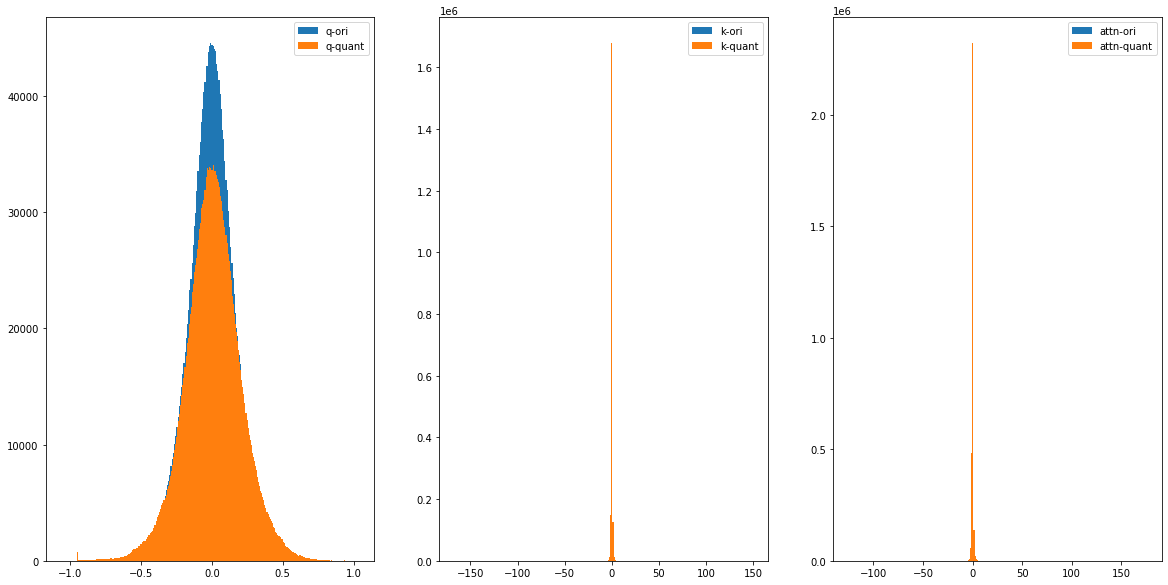

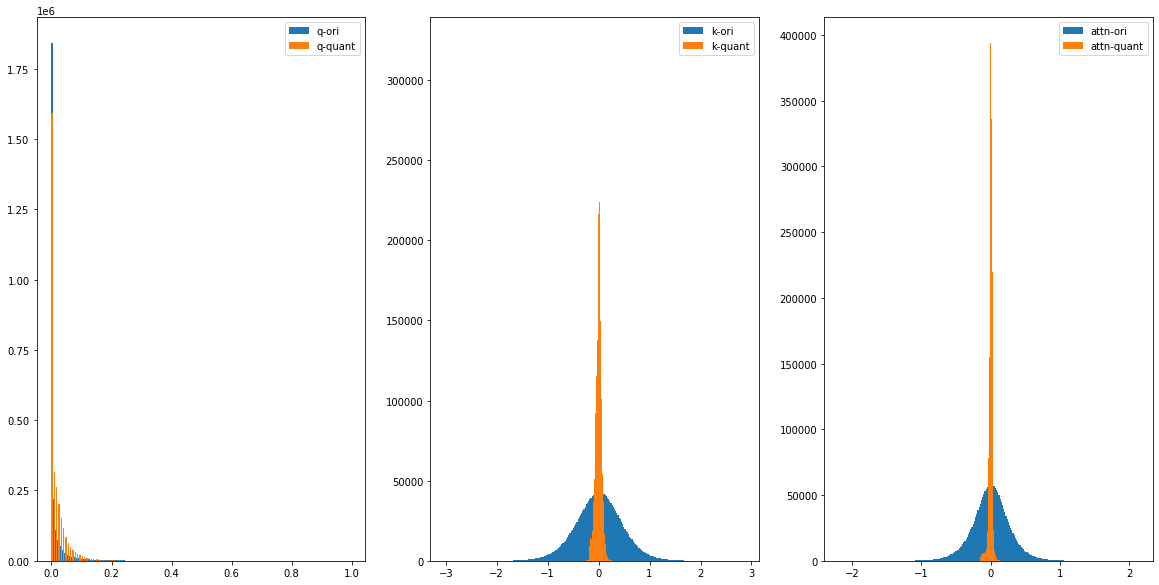

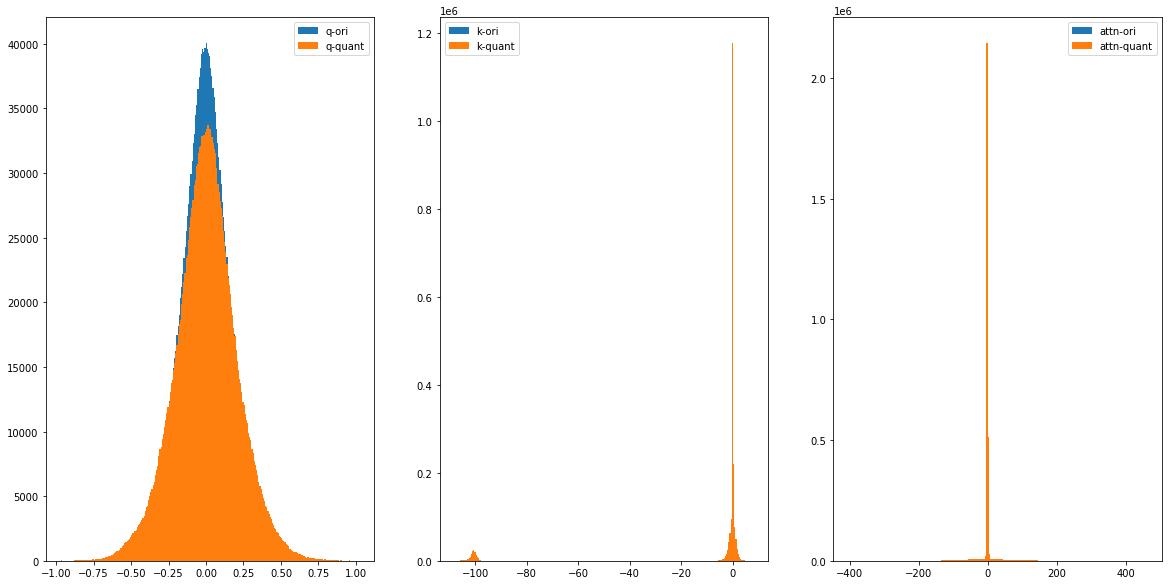

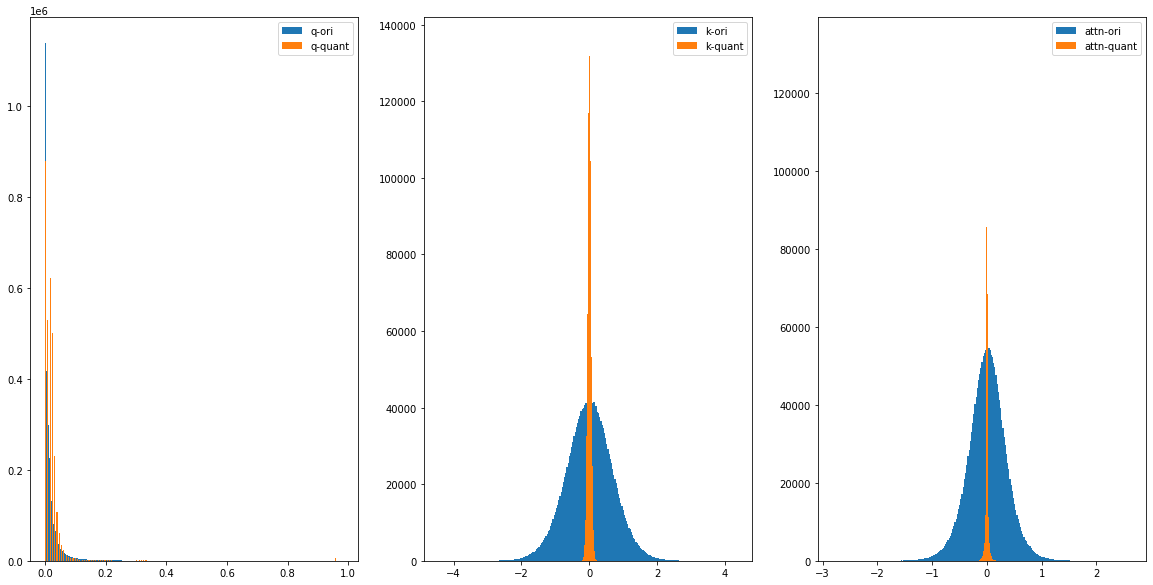

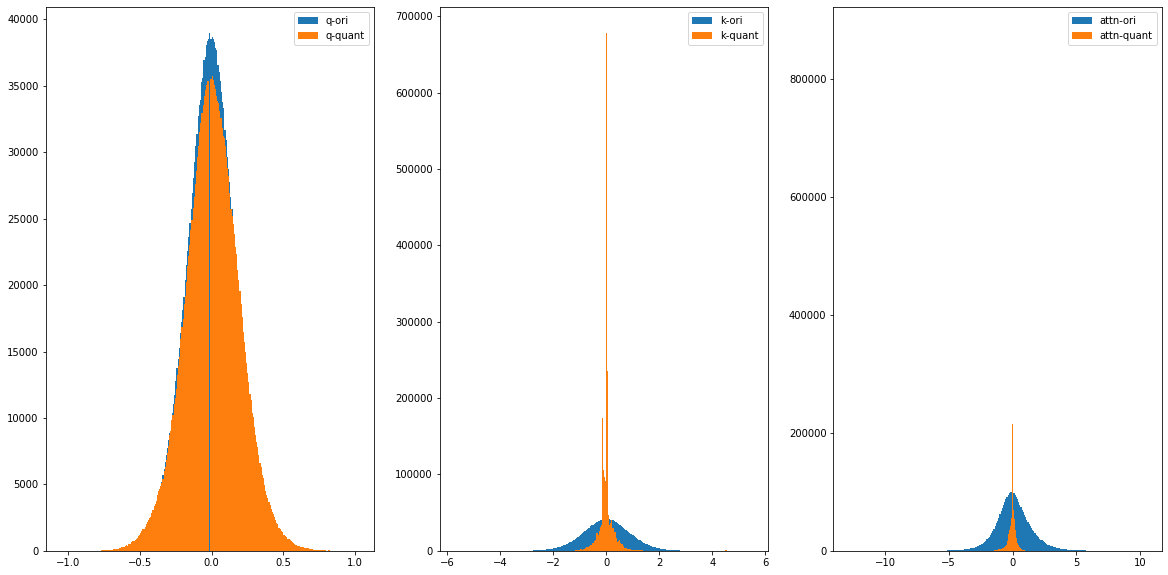

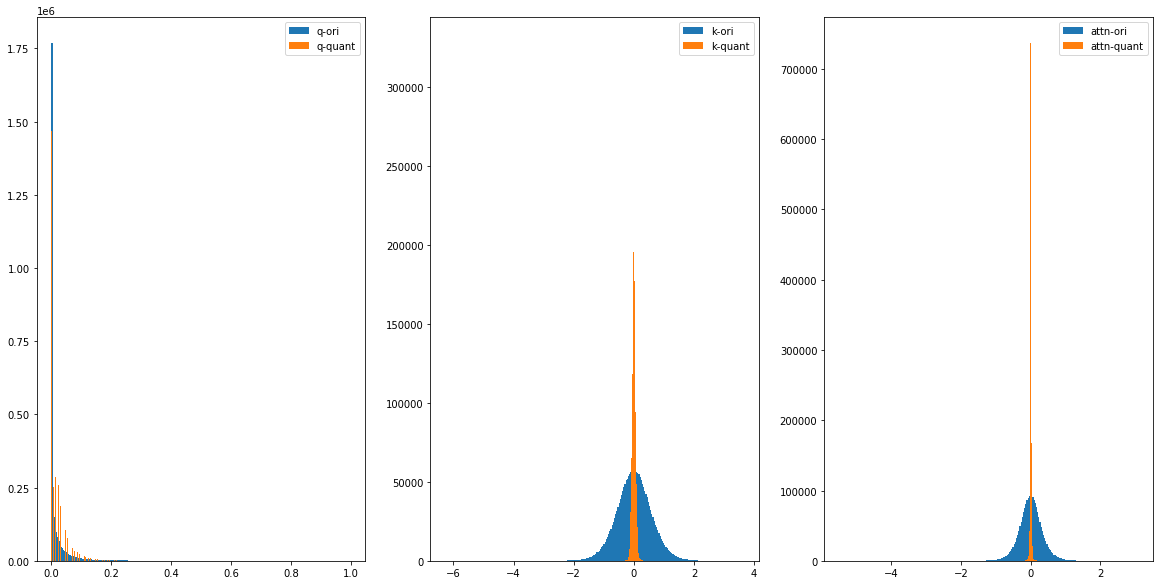

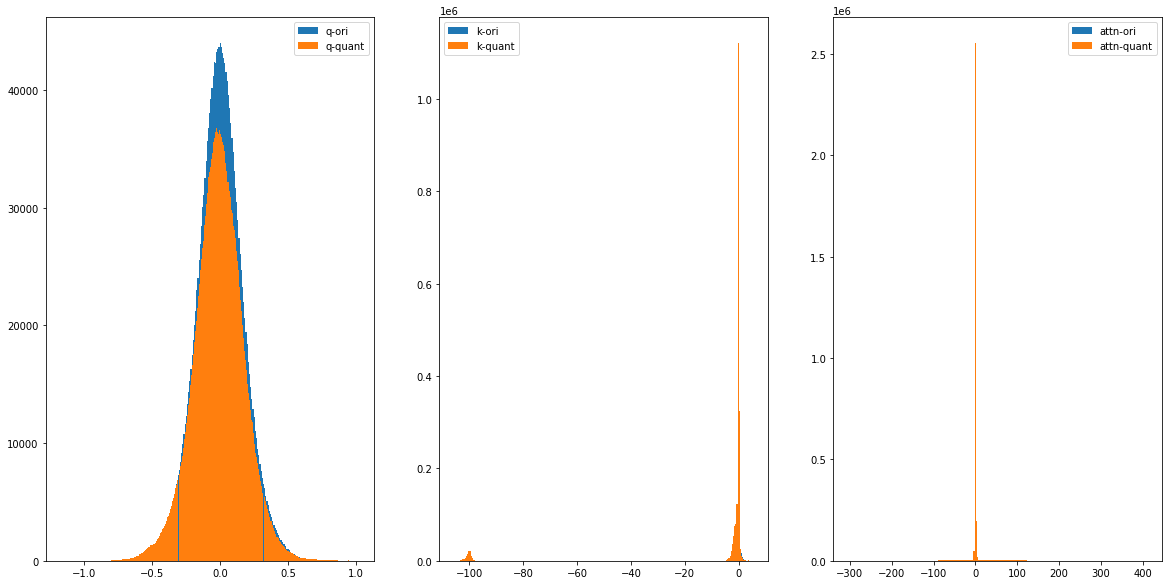

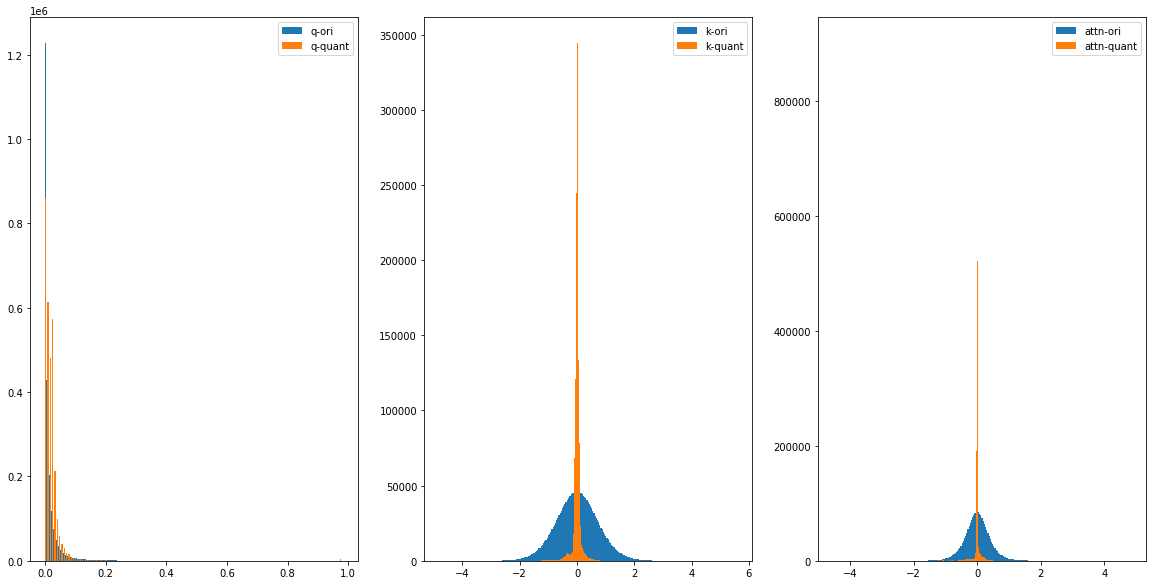

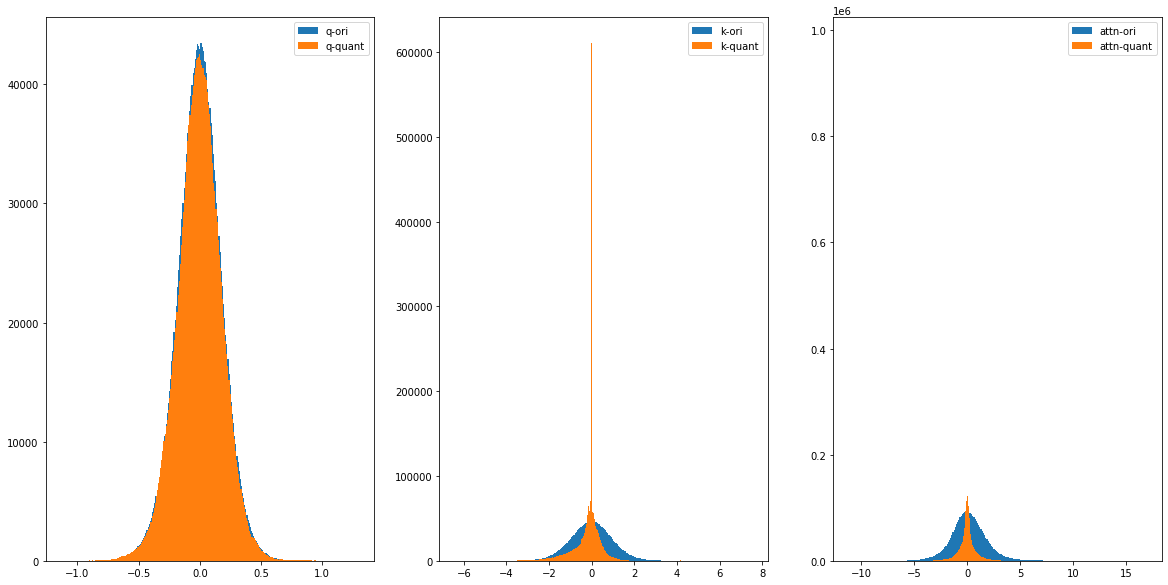

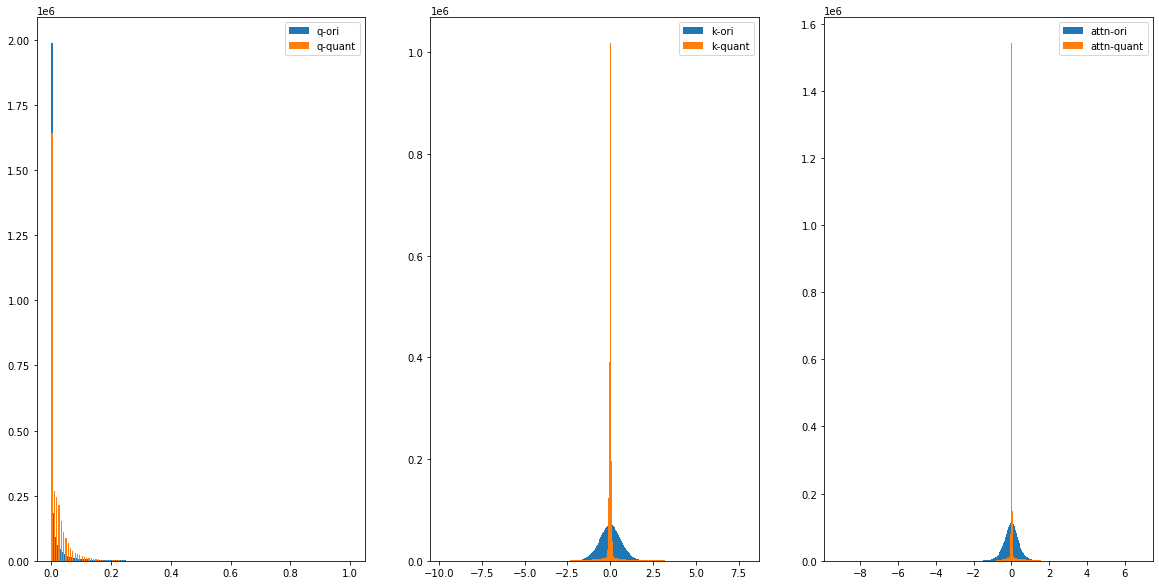

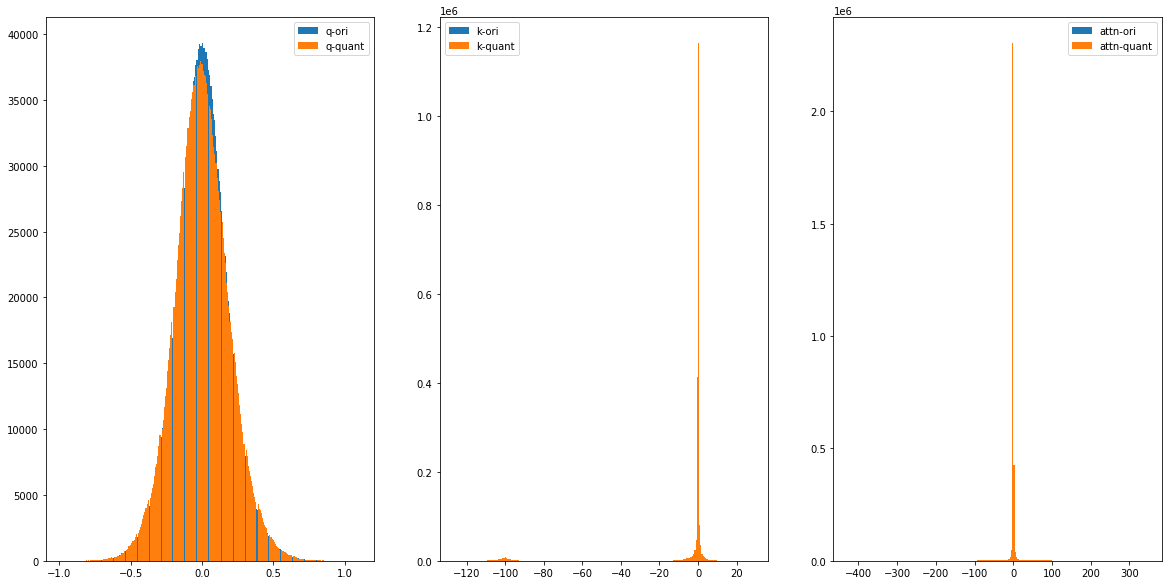

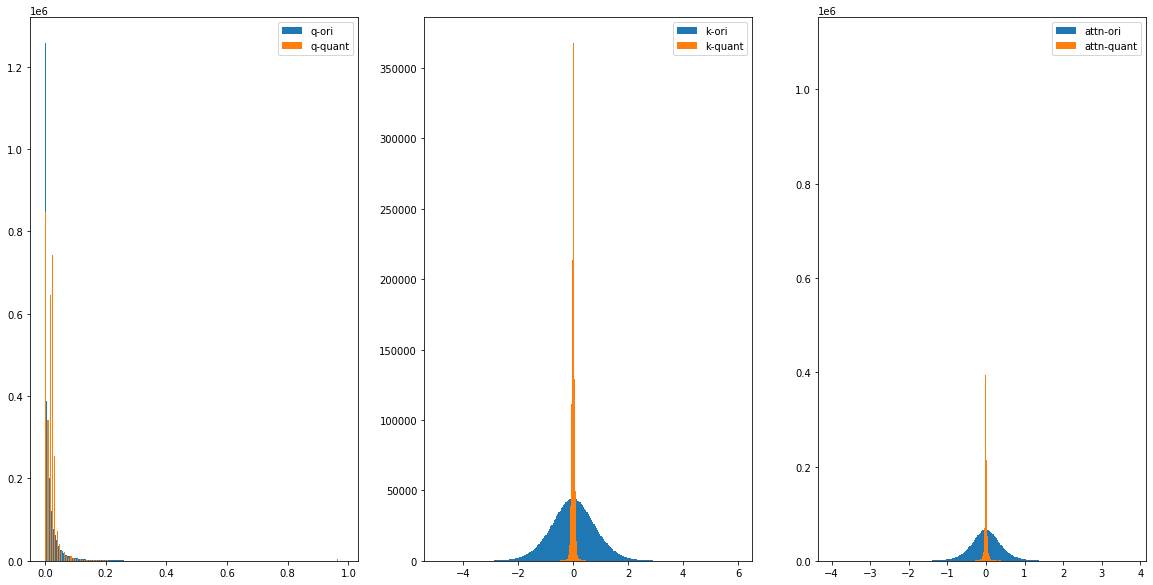

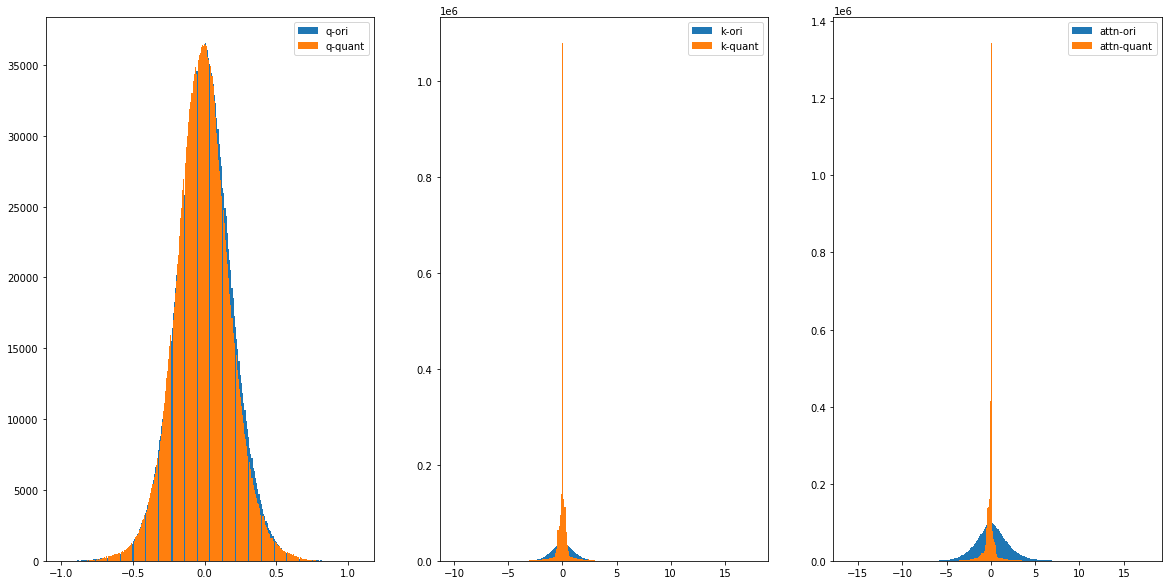

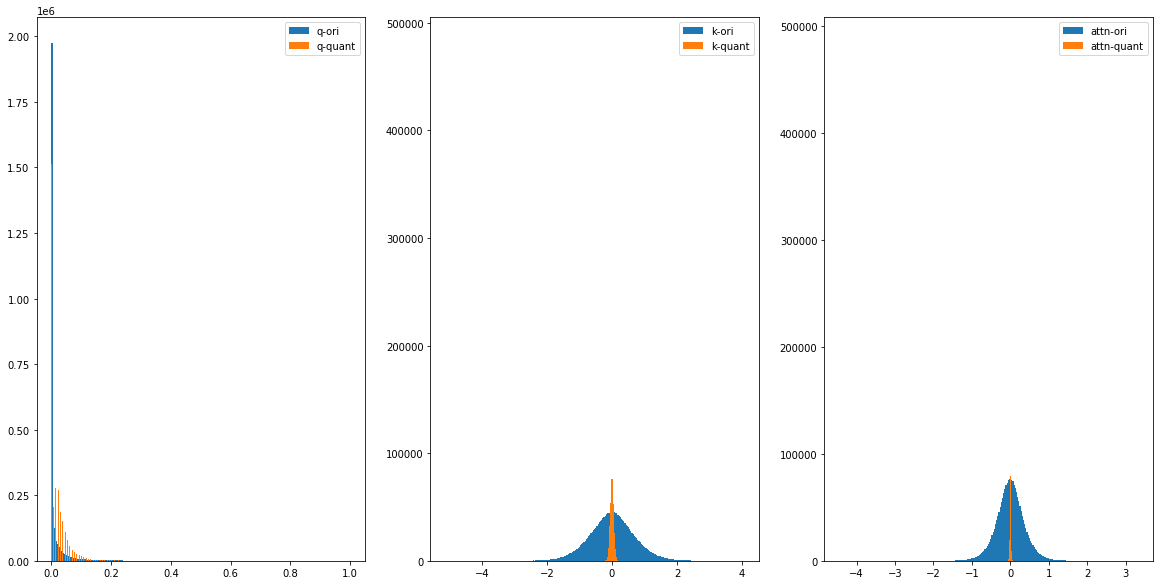

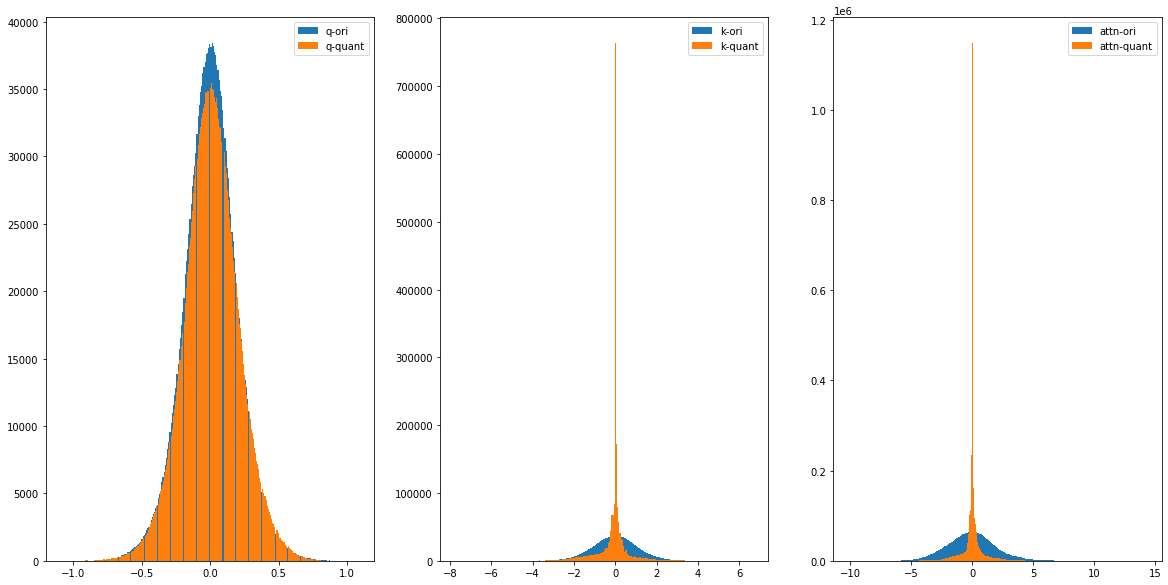

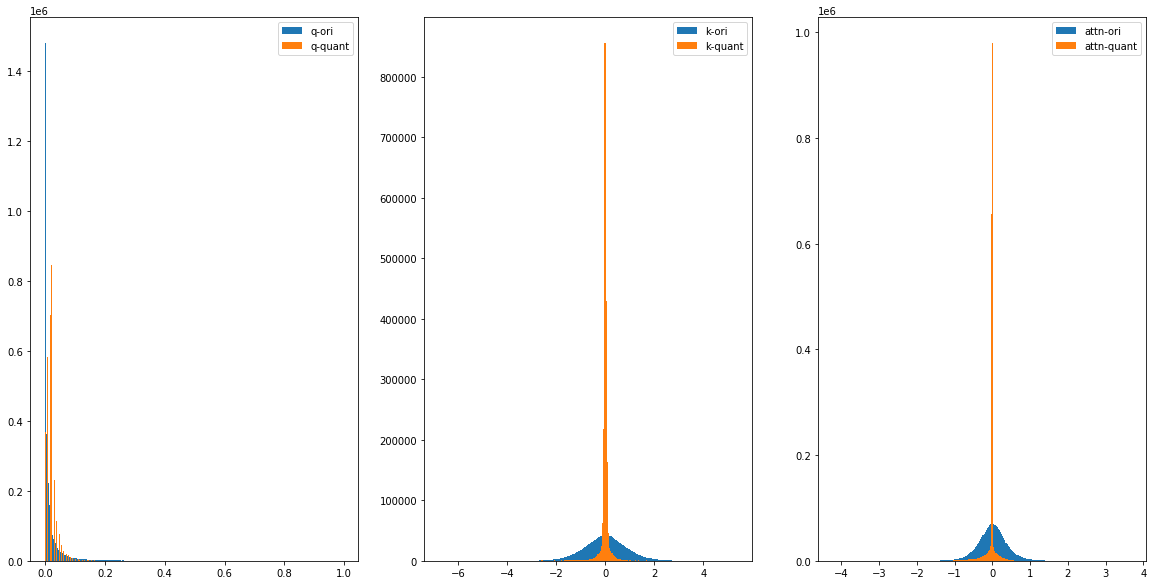

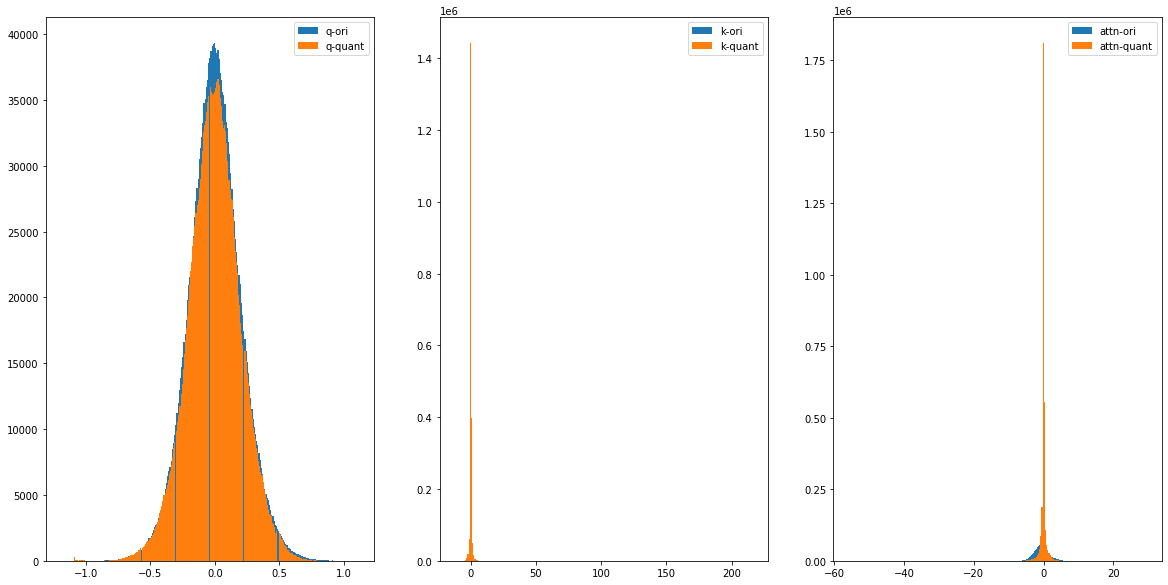

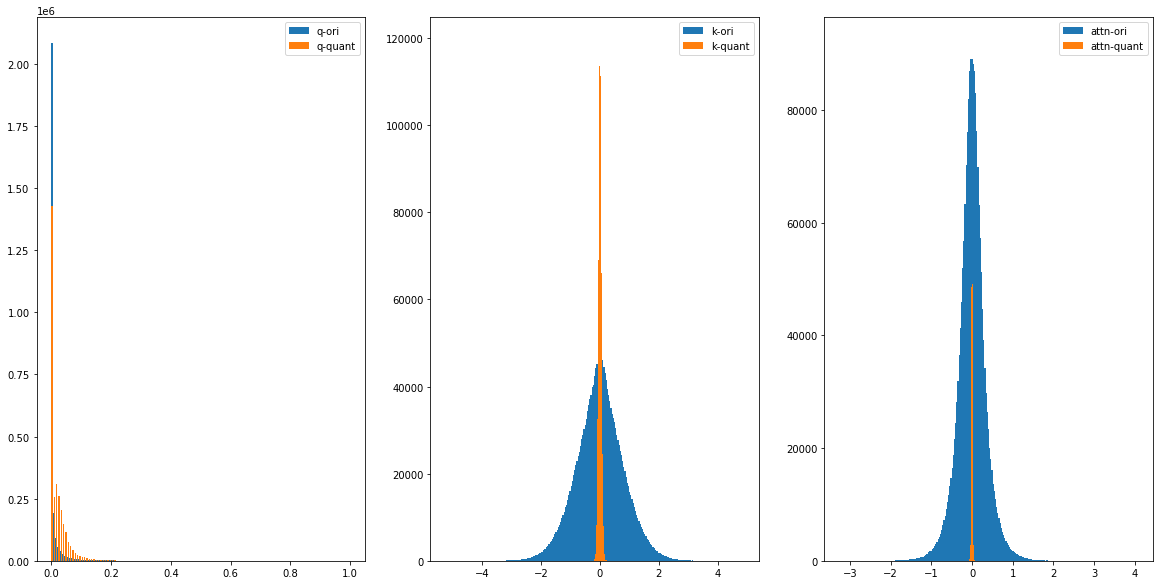

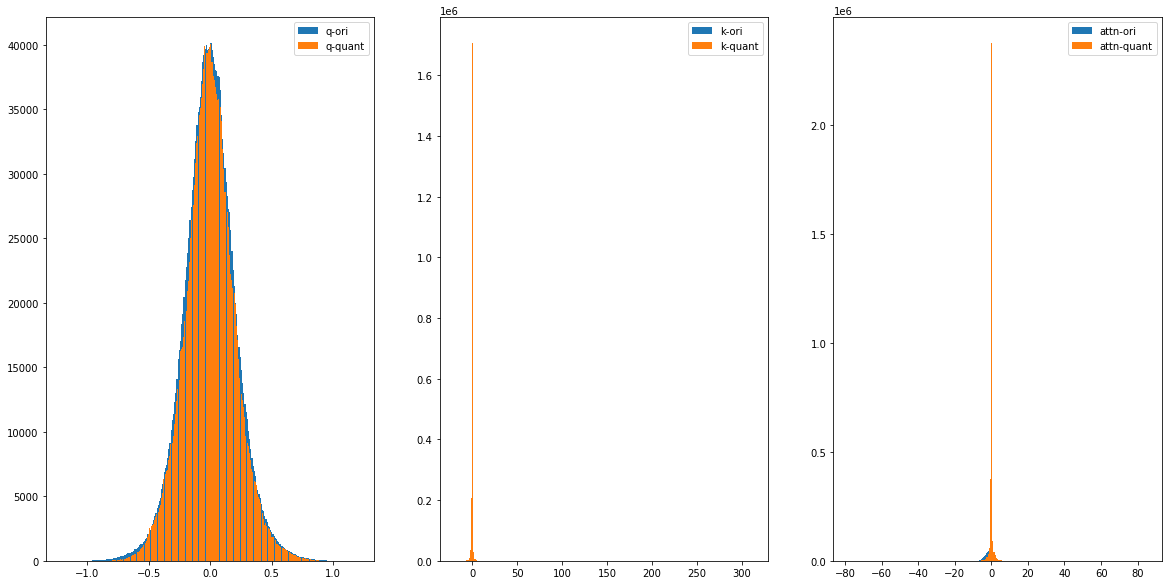

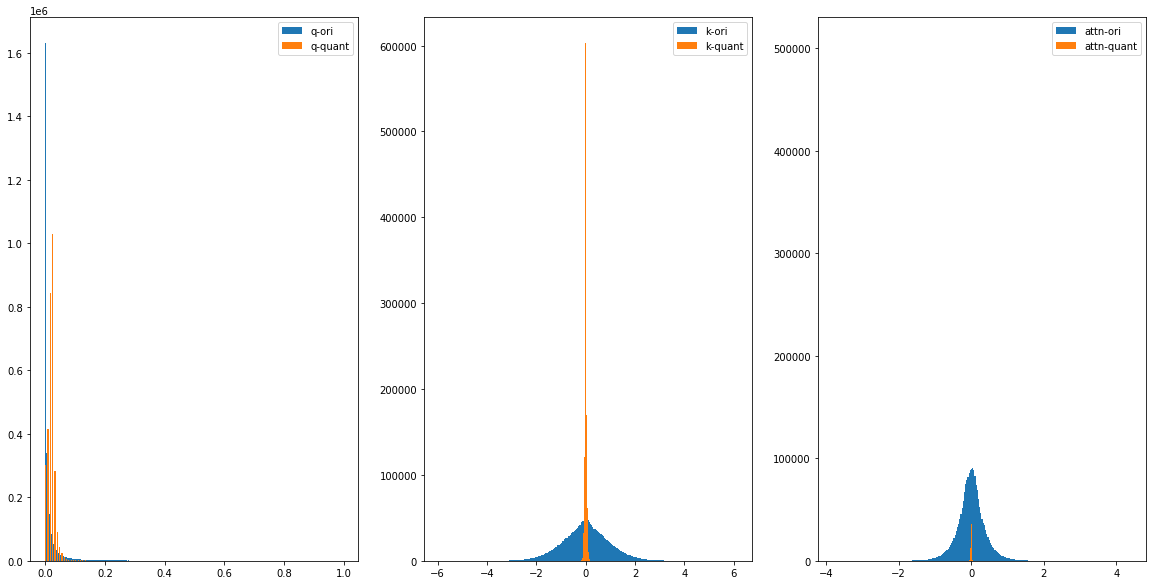

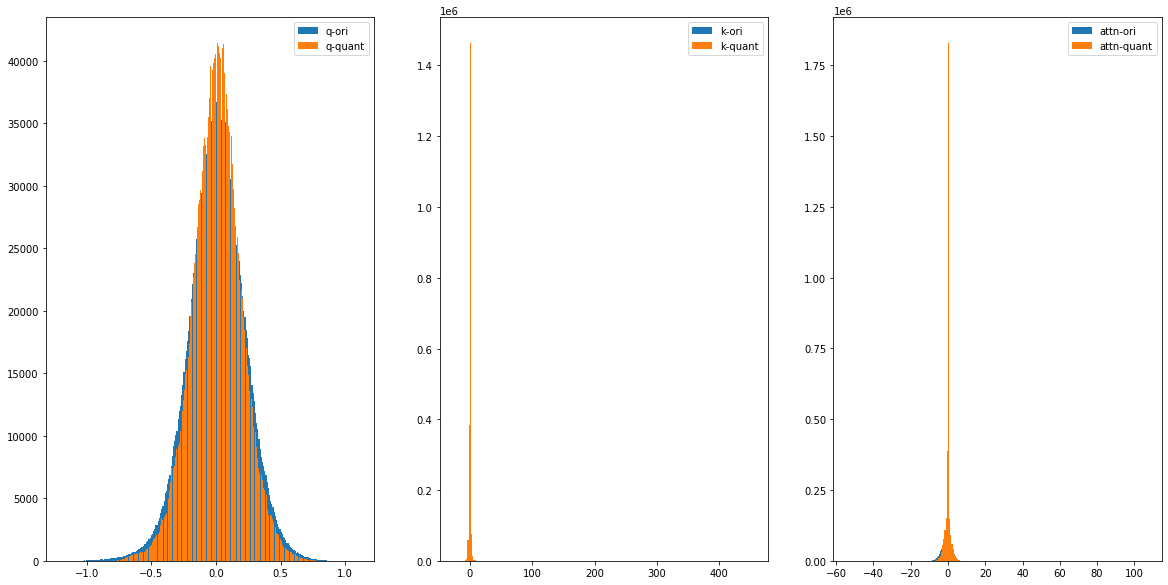

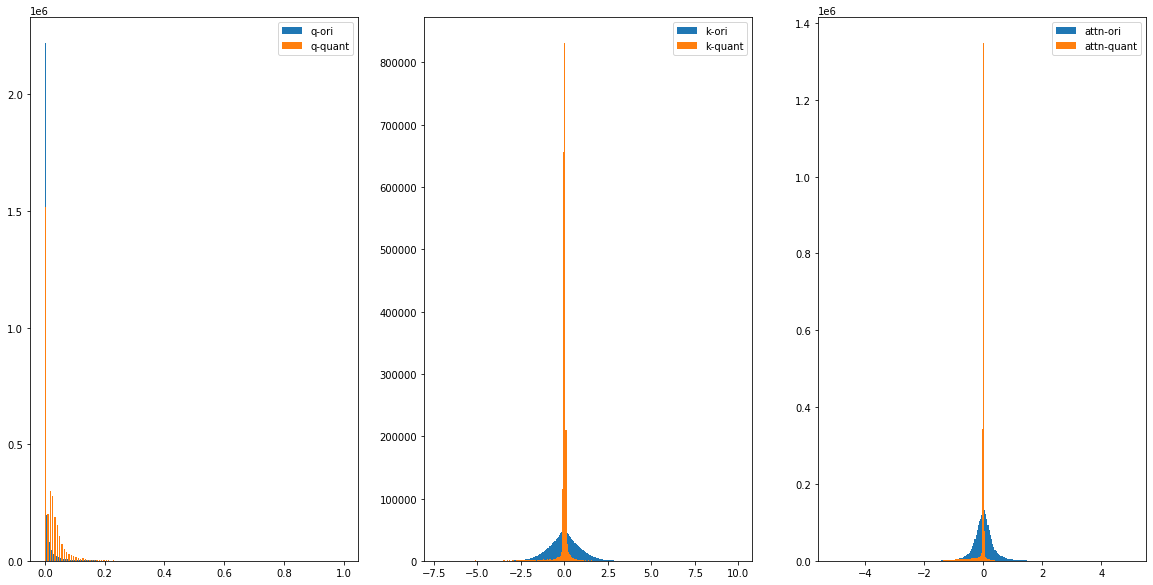

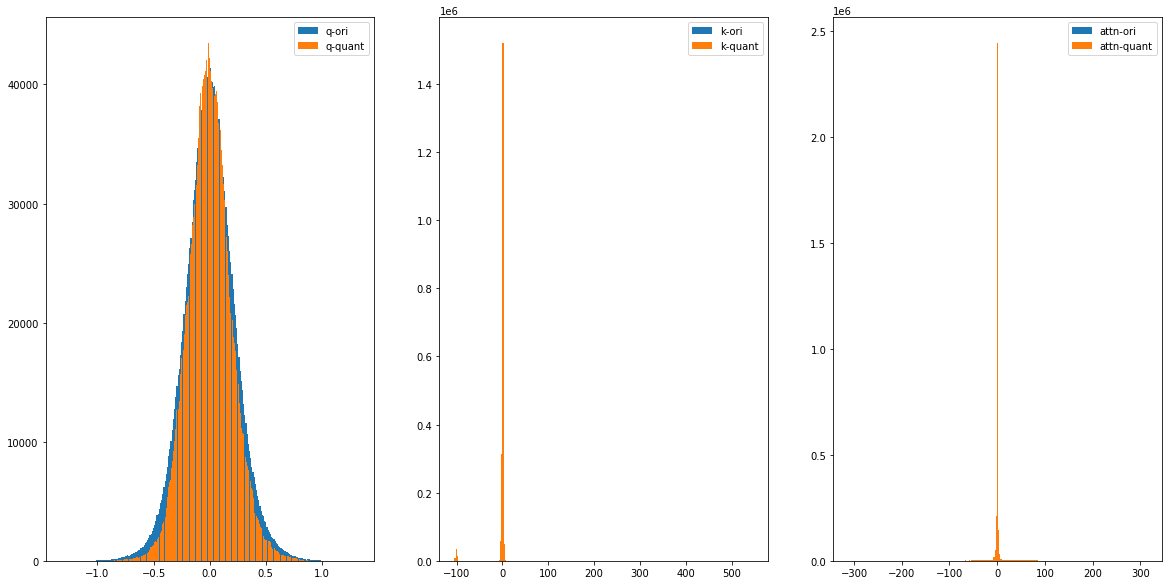

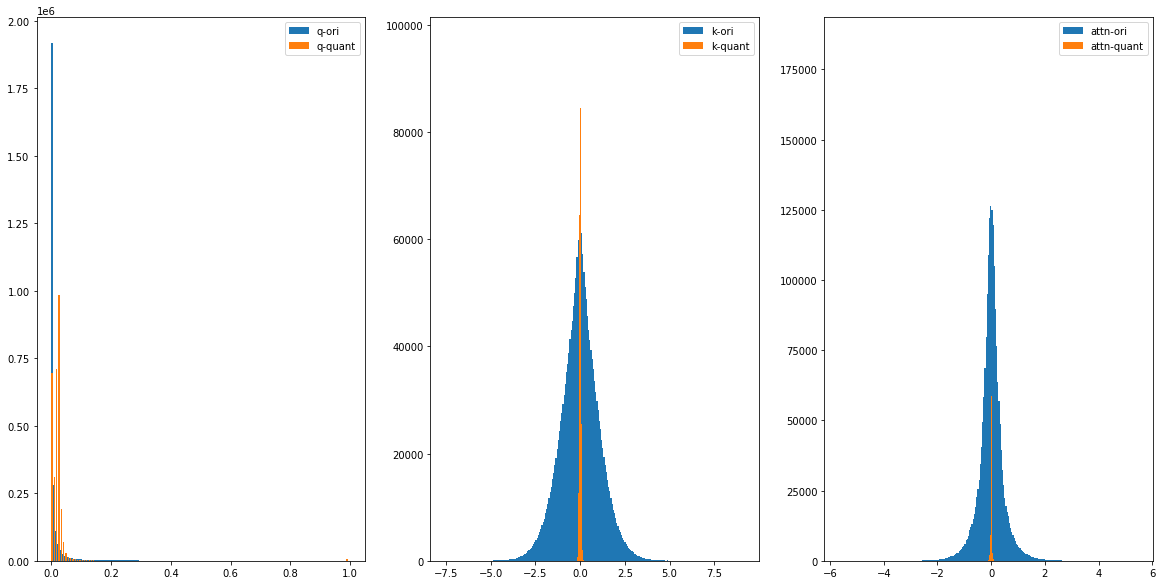

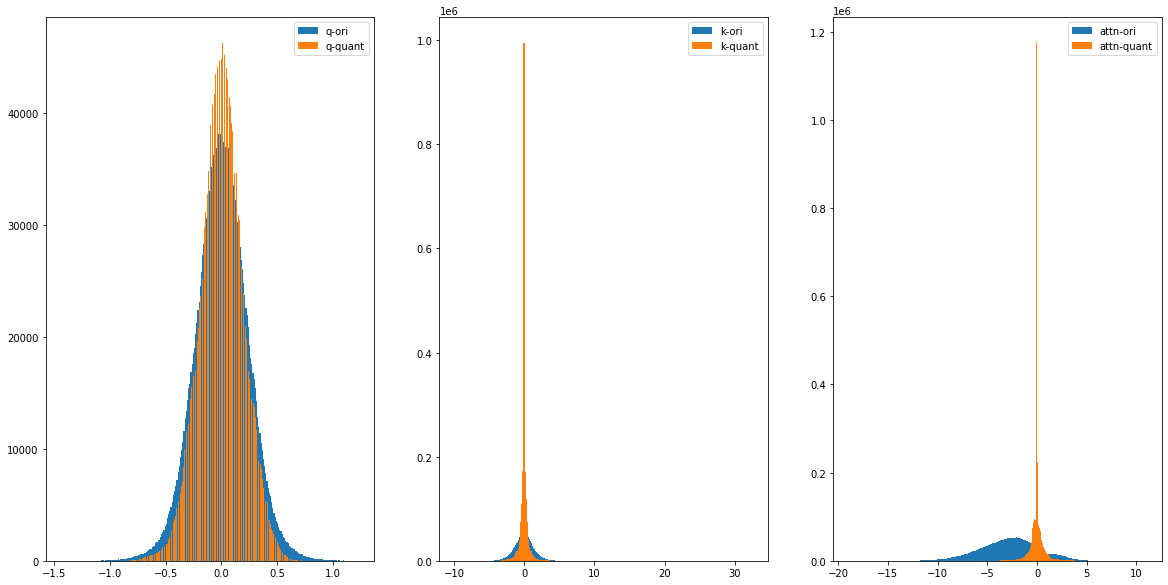

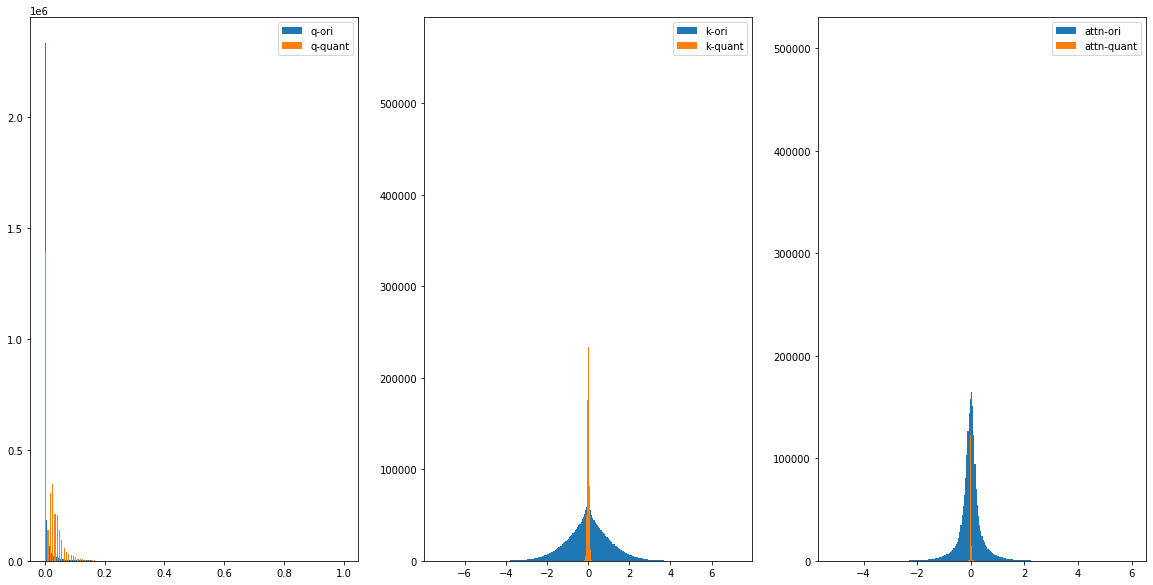

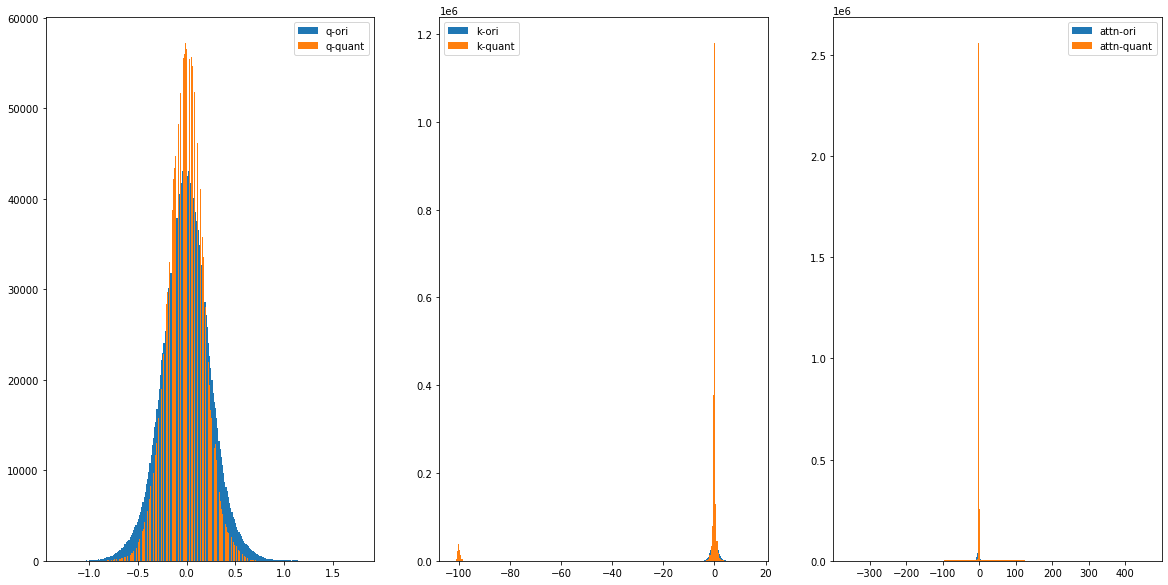

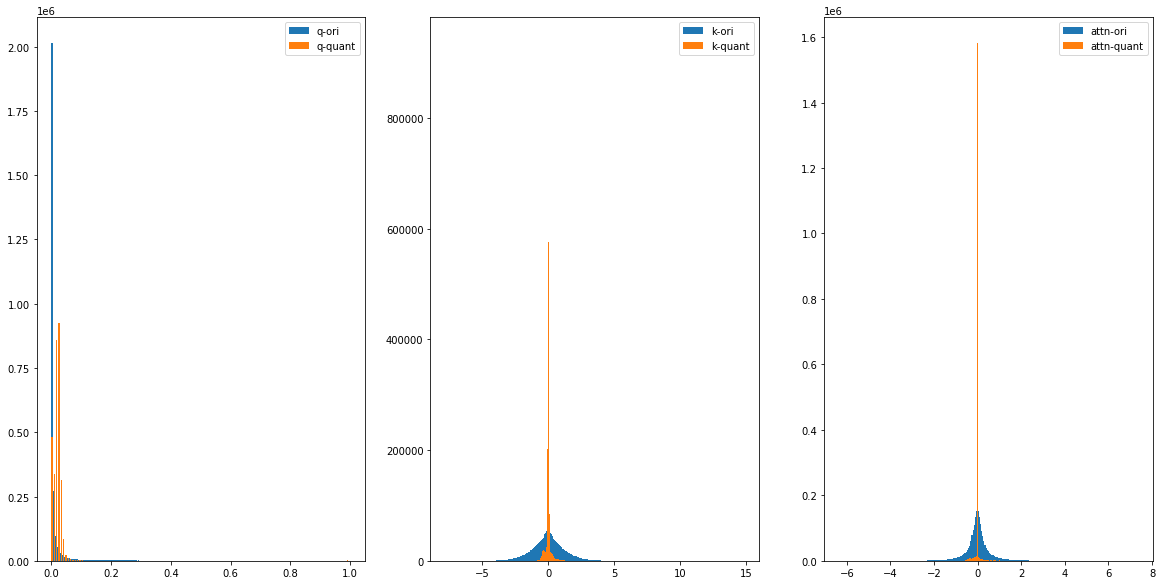

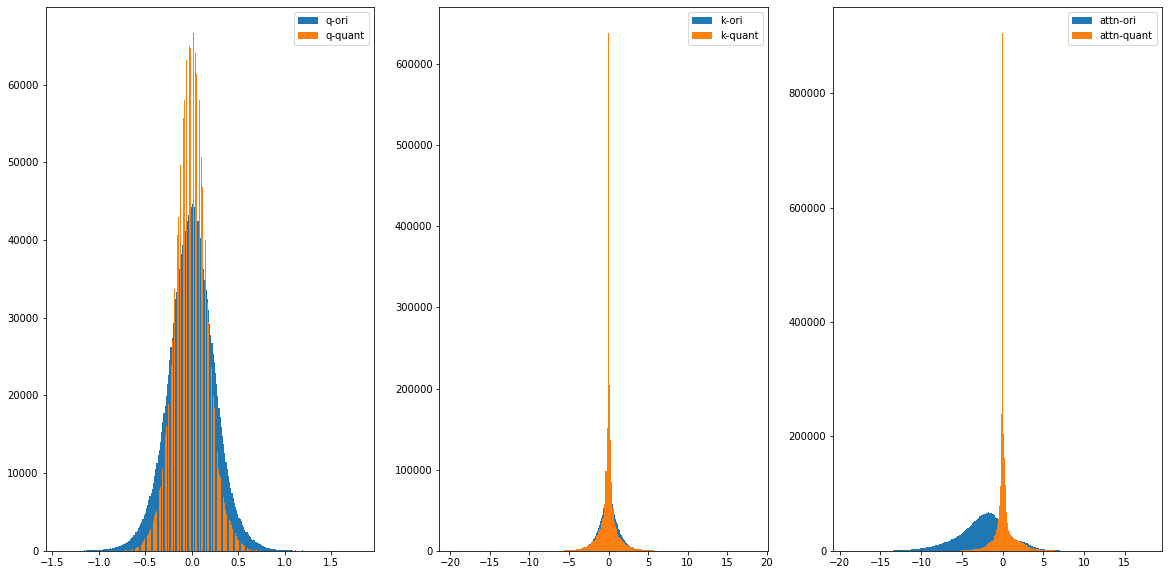

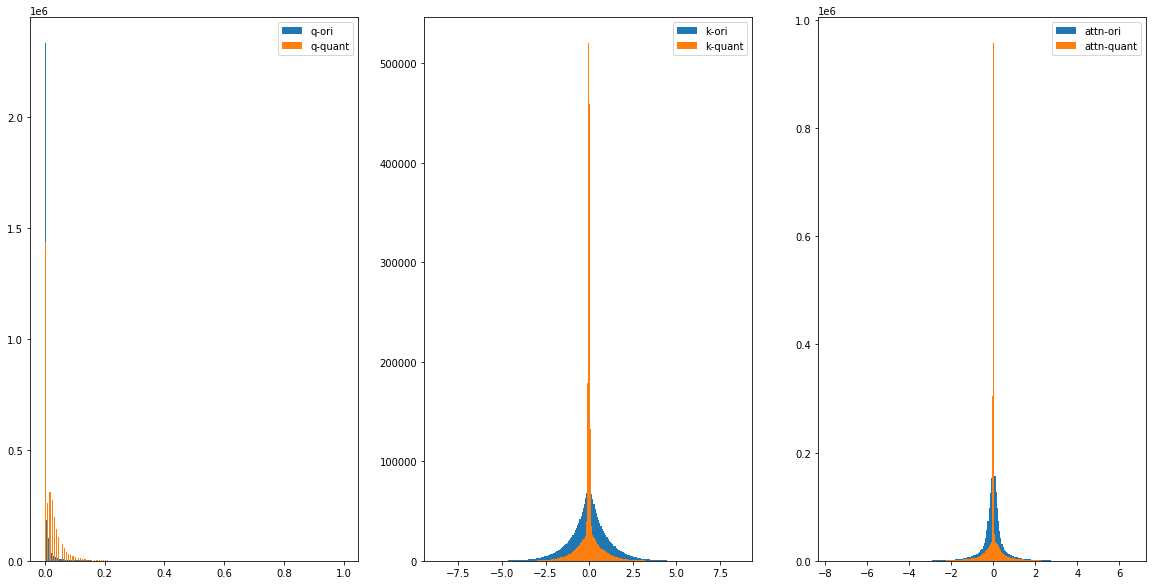

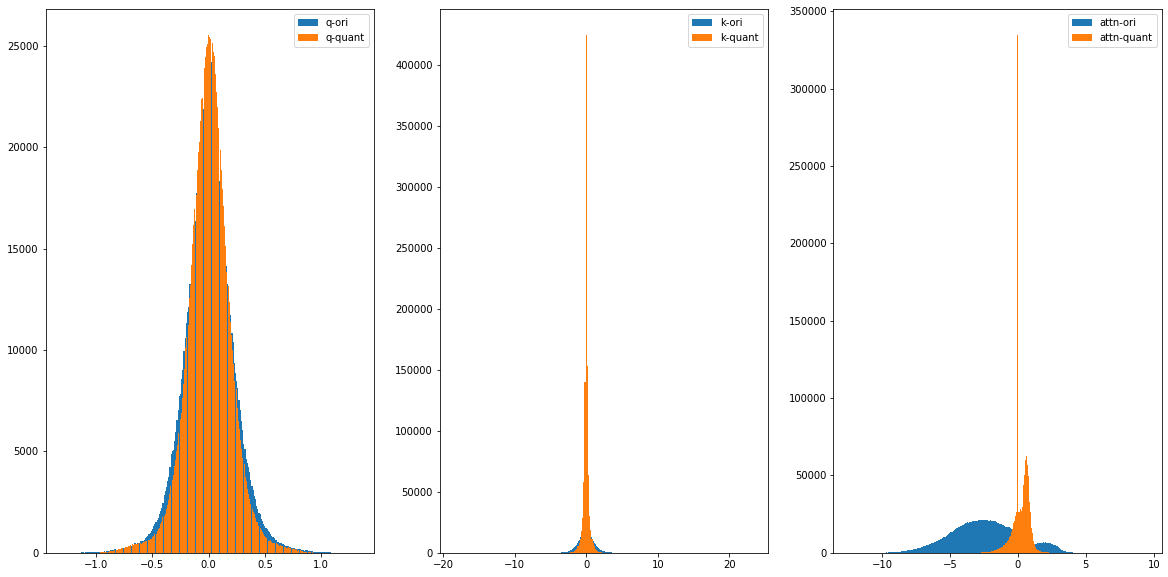

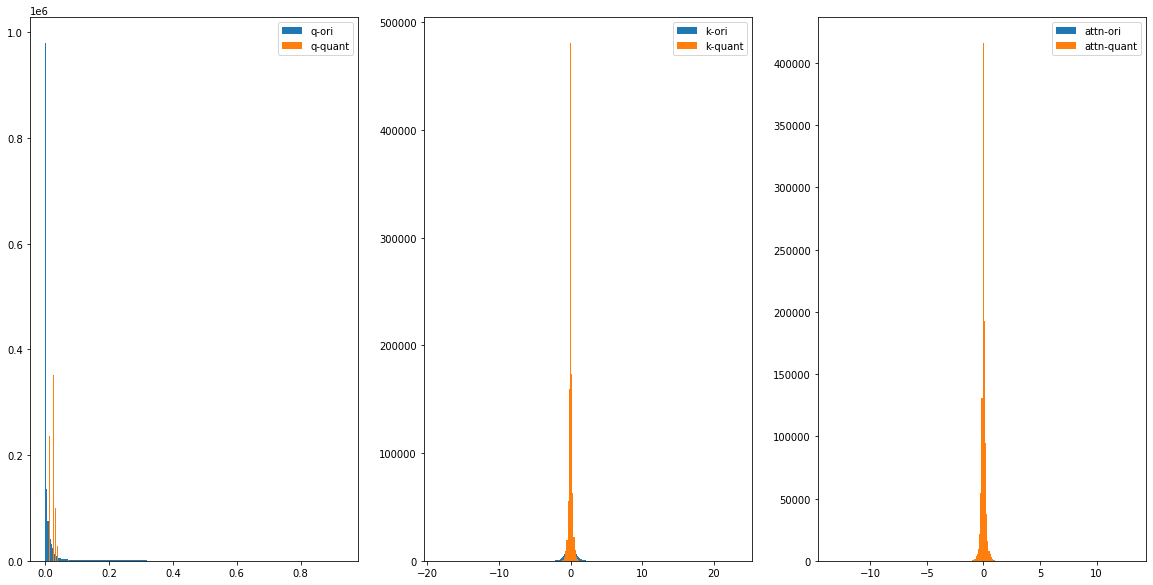

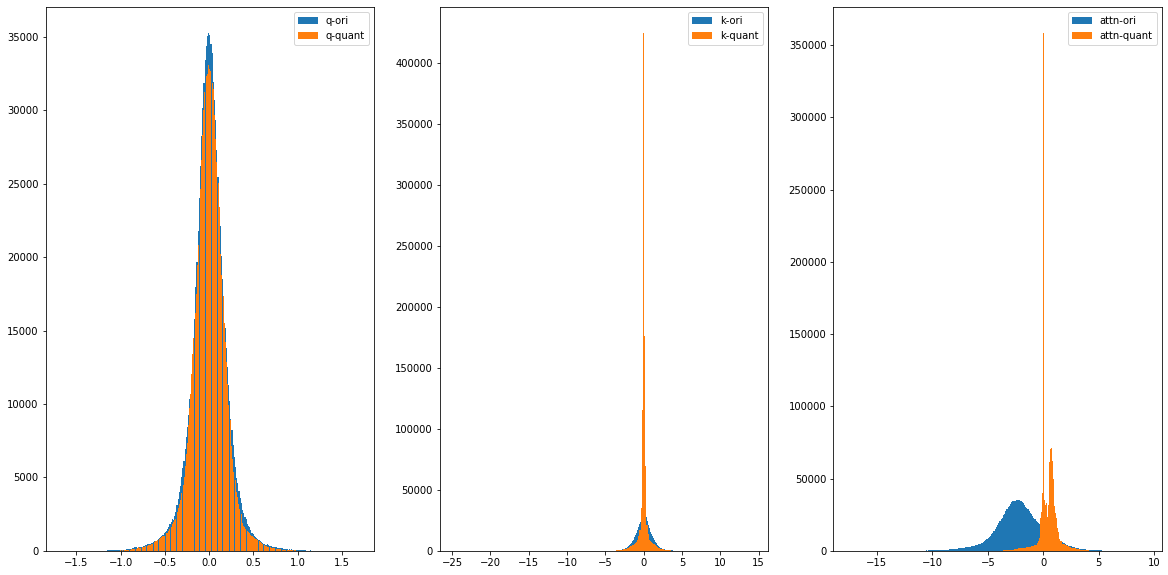

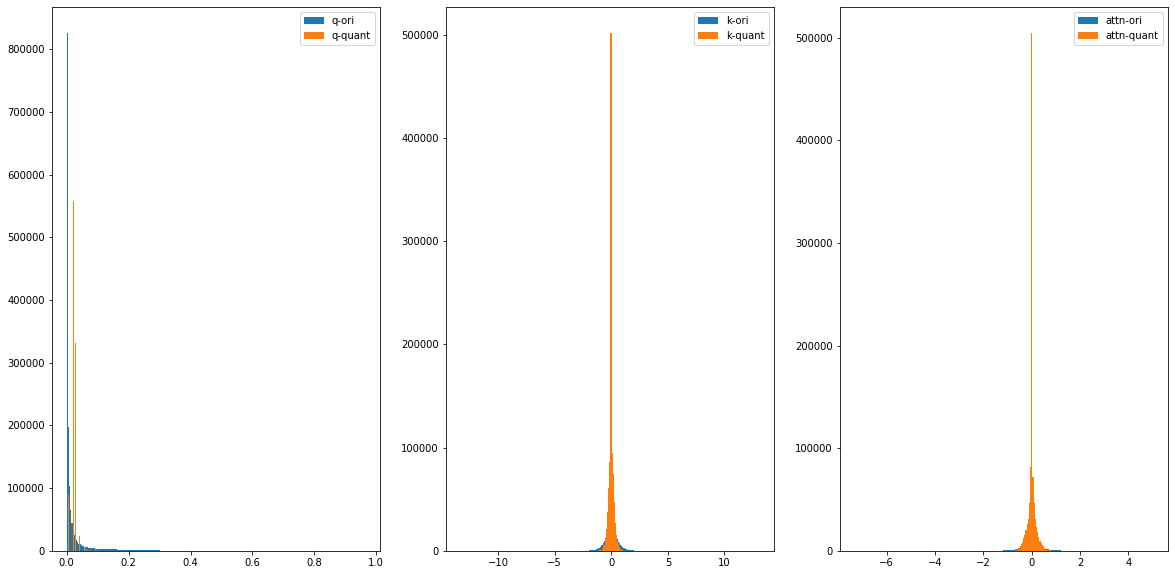

In [4]:
from torch.nn import Module
torch.tensor
def plot2_hist(input1:list,input2,key): # input1:ori input2:quant
    plt.figure(figsize=(20,10),label=key)
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    np.concatenate([i[0] for i in input1])

    q_in_ori = np.concatenate([i[0] for i in input1]).flatten()
    q_in_quant = np.concatenate([i[0] for i in input2]).flatten()
    assert(q_in_ori.shape==q_in_quant.shape)
    ax1.hist(q_in_ori,bins=255,label='q-ori')
    ax1.hist(q_in_quant,bins=255,label='q-quant')
    ax1.legend()
    # ax1.hist(np.concatenate([i[0] for i in input2]).flatten(),bins=255,label='q-quant')

    k_in_ori = np.concatenate([i[1] for i in input1]).flatten()
    k_in_quant = np.concatenate([i[1] for i in input2]).flatten()
    assert(k_in_ori.shape==k_in_quant.shape)
    ax2.hist(k_in_ori,bins=255,label='k-ori')
    ax2.hist(k_in_quant,bins=255,label='k-quant')
    ax2.legend()

    # ax2.hist(np.concatenate([i[1] for i in input1]).flatten(),bins=255,label='k-ori')
    # ax2.hist(np.concatenate([i[1] for i in input2]).flatten(),bins=255,label='k-quant')

    attn_in_ori = np.concatenate([i[2] for i in input1]).flatten()
    attn_in_quant = np.concatenate([i[2] for i in input2]).flatten()
    assert(attn_in_ori.shape==attn_in_quant.shape)
    ax3.hist(attn_in_ori,bins=255,label='attn-ori')
    ax3.hist(attn_in_quant,bins=255,label='attn-quant')
    ax3.legend()

    # ax3.hist(np.concatenate([i[2] for i in input1]).flatten(),bins=255,label='o-ori')
    # ax3.hist(np.concatenate([i[2] for i in input2]).flatten(),bins=255,label='o-quant')

    plt.pause(0.1)
    plt.show()

keys = ori_dict.keys()
for key in keys:
    plot2_hist(ori_dict[key],quant_dict[key],key)

In [2]:
torch.cuda.empty_cache() # 清空缓存
import torch.fx as fx
from torch.fx import Interpreter
class FindInput(Interpreter):
    def call_function(self, target , args , kwargs):
        if target==torch.matmul:
            quant_dict[self.name].append(args)
            # for a in args:
            #     print(a.shape)
            # print(kwargs)
            pass
        return super().call_function(target,args,kwargs)
    pass

find = FindInput(model.eval())
with torch.no_grad():
    for i,(img,label) in enumerate(tqdm(dataloader)):
        if i>0:
            break
        img = img.to(device)
        find.run(img)

  0%|          | 1/1563 [00:09<3:54:37,  9.01s/it]


In [4]:
quant_dict.keys()

dict_keys(['matmul_1', 'matmul_2', 'matmul_3', 'matmul_4', 'matmul_5', 'matmul_6', 'matmul_7', 'matmul_8', 'matmul_9', 'matmul_10', 'matmul_11', 'matmul_12', 'matmul_13', 'matmul_14', 'matmul_15', 'matmul_16', 'matmul_17', 'matmul_18', 'matmul_19', 'matmul_20', 'matmul_21', 'matmul_22', 'matmul_23', 'matmul_24', 'matmul_25', 'matmul_26', 'matmul_27', 'matmul_28', 'matmul_29', 'matmul_30', 'matmul_31', 'matmul_32', 'matmul_33', 'matmul_34', 'matmul_35', 'matmul_36', 'matmul_37', 'matmul_38', 'matmul_39', 'matmul_40', 'matmul_41', 'matmul_42', 'matmul_43', 'matmul_44', 'matmul_45', 'matmul_46', 'matmul_47', 'matmul_48'])